In [1]:
import numpy as np
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pathlib import Path
import pandas as pd

## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecell_tracker.segment
import livecell_tracker.annotation
import livecell_tracker.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecell_tracker.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [2]:
from pycocotools.coco import COCO

coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")
out_dir = Path("./notebook_results/a549_ccp_vim/train_data_v7/")
# coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/val.json")
# out_dir = Path("./notebook_results/a549_ccp_vim/test_data_v7/")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [3]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 dict_keys(['height', 'width', 'id', 'file_name']),
 '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile7_DIC-FITC.tif')

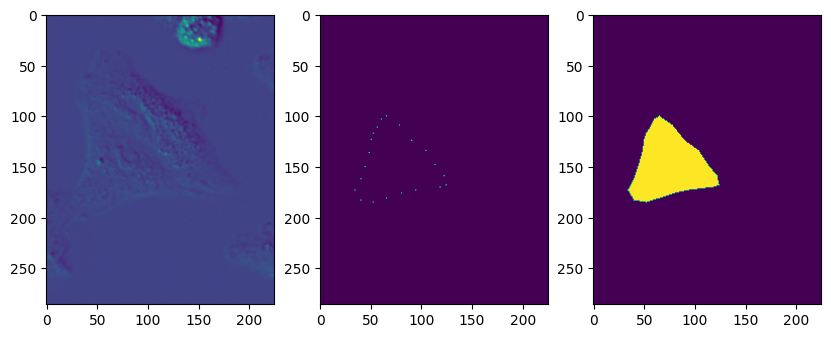

In [4]:
from typing import List

from livecell_tracker.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)


# # for testing
# single_cells = single_cells[:20]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cell_id = 10
axes[0].imshow(single_cells[cell_id].get_img_crop(padding=100))
axes[1].imshow(single_cells[cell_id].get_contour_mask_closed_form(padding=100))
axes[2].imshow(single_cells[cell_id].get_contour_mask(padding=100))


In [5]:
len(single_cells)

294

save a list of single cell objects

In [6]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [7]:
contour_mask = single_cells[cell_id].get_contour_mask(padding=100)
contour_mask.astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

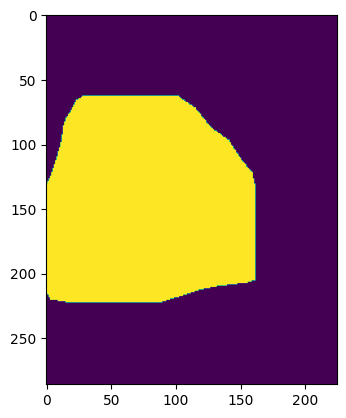

In [8]:
import cv2 as cv
from livecell_tracker.preprocess.utils import dilate_or_erode_mask

plt.imshow(dilate_or_erode_mask(contour_mask.astype(np.uint8), 1))


In [9]:
sample_sc = single_cells[cell_id]
sample_sc.meta

{'img_id': 7,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile8_DIC-FITC.tif'}

In [10]:
import glob

raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print("sample seg paths:", seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0] # get rid of extension
    substr = substr[4:]  # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(
        substr, return_path_and_time=True, ignore_missing=True
    )
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = seg_data
assert len(seg_data) == len(raw_img_dataset)

for sc in single_cells:
    assert sc.timeframe in seg_data.time2url
    sc.mask_dataset = seg_data

sample seg paths: ['../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile8_DIC-FITC.png', '../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile0_DIC-FITC.png']
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY2_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile2_DIC-FITC
skip due to substr not fo

## Generate Synthetic Undersegmentation data

<AxesSubplot: >

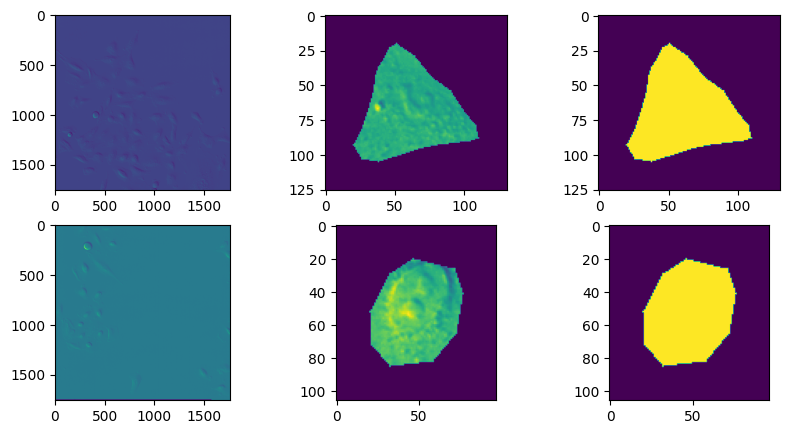

In [11]:
sc1 = single_cells[10]
sc2 = single_cells[1]

padding=20
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
sc1.show(padding=padding, ax=axes[0][0])
sc1.show_contour_img(padding=padding, ax=axes[0][1])
sc1.show_contour_mask(padding=padding, ax=axes[0][2])
sc2.show(padding=padding, ax=axes[1][0])
sc2.show_contour_img(padding=padding, ax=axes[1][1])
sc2.show_contour_mask(padding=padding, ax=axes[1][2])

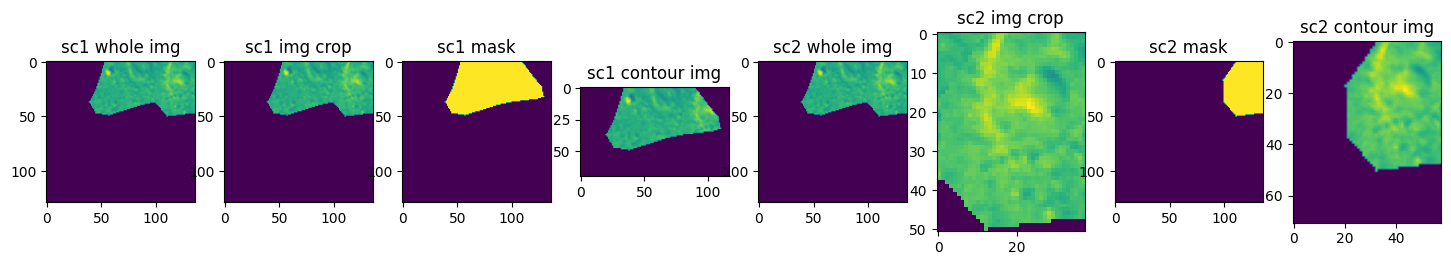

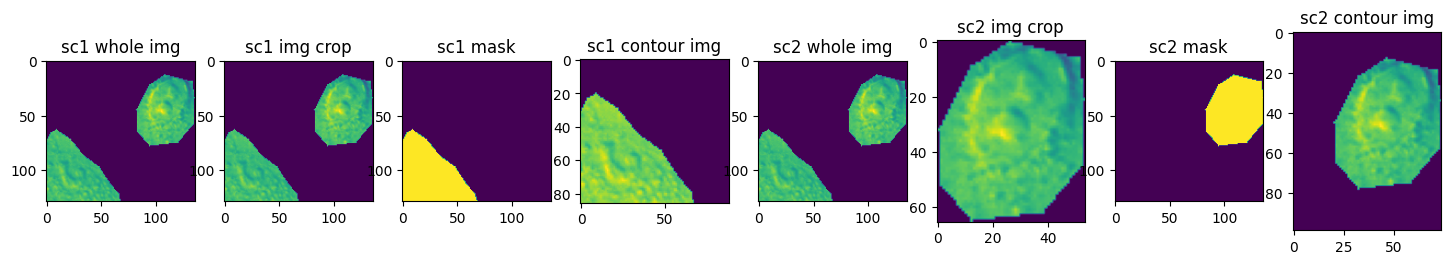

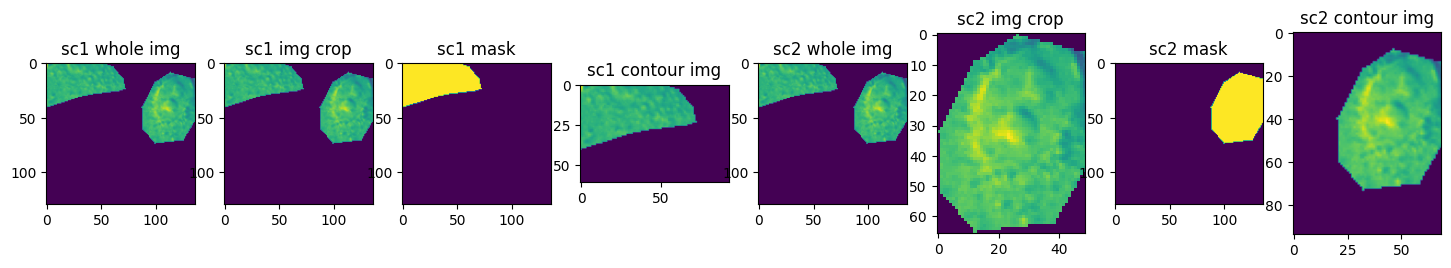

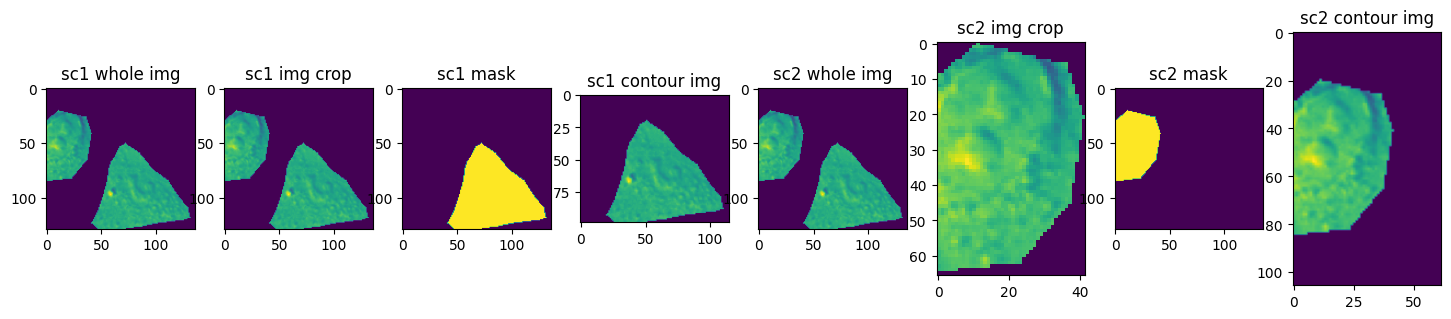

In [12]:
from livecell_tracker.core.datasets import SingleImageDataset


def check_contour_in_boundary(contour, boundary):
    return np.all(contour >= 0) and np.all(contour < boundary)


def adjust_contour_to_bounds(contour, bounds, bound_shift=-1):
    bounds = np.array(bounds)
    if not check_contour_in_boundary(contour, bounds):
        contour = contour.copy()
        contour[contour < 0] = 0
        contour = np.where(contour >= bounds, bounds + bound_shift, contour)
    return contour

def shift_contour_randomly(sc_center, contour, bounds):
    random_center = np.random.randint(low=0, high=bounds, size=2)
    shift = random_center - sc_center
    shift = shift.astype(int)
    contour_shifted = contour + shift
    return random_center, contour_shifted, shift

def compute_two_contours_min_distance(contour1, contour2):
    min_dist = np.inf
    for p1 in contour1:
        for p2 in contour2:
            dist = np.linalg.norm(p1 - p2)
            if dist < min_dist:
                min_dist = dist
    return min_dist


def _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=False):
    if not in_place:
        new_img = new_img.copy()
    sc_ori_space_pixel_xy_arr = np.array(new_sc_mask.nonzero()).T - shift
    sc_ori_space_pixel_xy_arr[sc_ori_space_pixel_xy_arr < 0] = 0
    new_img[new_sc_mask] = sc.get_contour_img()[sc_ori_space_pixel_xy_arr[:, 0], sc_ori_space_pixel_xy_arr[:, 1]]
    return new_img
    

def add_sc_to_img(sc, new_img, mask, bg_img, in_place=False, mask_inplace=True, fix_sc_pos=False):
    bg_shape = np.array(bg_img.shape)
    sc_prop = sc.compute_regionprops()
    sc_contour_coords = sc.get_contour_coords_on_crop().astype(int)
    if fix_sc_pos:
        sc_new_center = sc_prop.centroid
        sc_new_contour = sc_contour_coords
        shift = 0
    else:
        sc_new_center, sc_new_contour, shift = shift_contour_randomly(sc_prop.centroid, sc_contour_coords, bounds=bg_shape)
    sc_new_contour = adjust_contour_to_bounds(sc_new_contour, bg_shape)
    new_sc_mask = SingleCellStatic.gen_contour_mask(sc_new_contour, bg_img, bbox=None, crop=False)
    new_sc_mask_bool = new_sc_mask > 0 # convert to bool
    new_img = _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=in_place)

    if mask_inplace:
        mask = mask.copy()
    mask[new_sc_mask_bool] = True
    return new_img, sc_new_contour, mask, shift

def combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, bg_scale=1.5, fix_sc1=False):
    def _gen_empty_bg_img():
        sc1_shape = sc1.get_img_crop().shape
        sc2_shape = sc2.get_img_crop().shape
        bg_shape = np.array([max(sc1_shape[0], sc2_shape[0]), max(sc1_shape[1], sc2_shape[1])])
        bg_shape = (bg_shape * bg_scale).astype(int)
        bg_img = np.zeros(shape=bg_shape)
        return bg_img
    
    if bg_img is None:
        bg_img = _gen_empty_bg_img()

    bg_shape = np.array(bg_img.shape)
    new_img = bg_img.copy()
    new_mask = np.zeros(shape=bg_shape, dtype=bool)

    _, sc1_new_contour, sc1_new_mask, shift1 = add_sc_to_img(sc1, new_img, bg_img=bg_img, mask=new_mask, in_place=True, fix_sc_pos=fix_sc1)
    _, sc2_new_contour, sc2_new_mask, shift2 = add_sc_to_img(sc2, new_img, bg_img=bg_img, mask=new_mask, in_place=True)

    new_sc1 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc1_new_contour, img_dataset=SingleImageDataset(new_img), mask_dataset=SingleImageDataset(sc1_new_mask))
    new_sc2 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc2_new_contour, img_dataset=SingleImageDataset(new_img), mask_dataset=SingleImageDataset(sc2_new_mask))
    return new_sc1, new_sc2

# has_overlap = np.any(new_sc1_mask & new_sc2_mask)
# print(has_overlap)
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# ax = axes[0][0]
# ax.imshow(new_sc1_mask | new_sc2_mask)
# ax = axes[0][1]
# ax.imshow(new_img)
bg_scale = 3.0

def viz_check_combined_sc_result(sc1, sc2):
    fig, axes = plt.subplots(1, 8, figsize=(18, 5))
    ax_idx = 0
    ax = axes[ax_idx]
    sc1.show_whole_img(ax=ax)
    ax.set_title("sc1 whole img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show(ax=ax)
    ax.set_title("sc1 img crop")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show_mask(ax=ax, padding=20)
    ax.set_title("sc1 mask")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show_contour_img(ax=ax, padding=20)
    ax.set_title("sc1 contour img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_whole_img(ax=ax)
    ax.set_title("sc2 whole img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show(ax=ax, crop=True)
    ax.set_title("sc2 img crop")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_mask(ax=ax, padding=20)
    ax.set_title("sc2 mask")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_contour_img(ax=ax, padding=20)
    ax.set_title("sc2 contour img")
    ax_idx += 1

    plt.show()

for i in range(4):
    new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None)
    viz_check_combined_sc_result(new_sc1, new_sc2)

# for i in range(4):
#     new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, fix_sc1=True)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

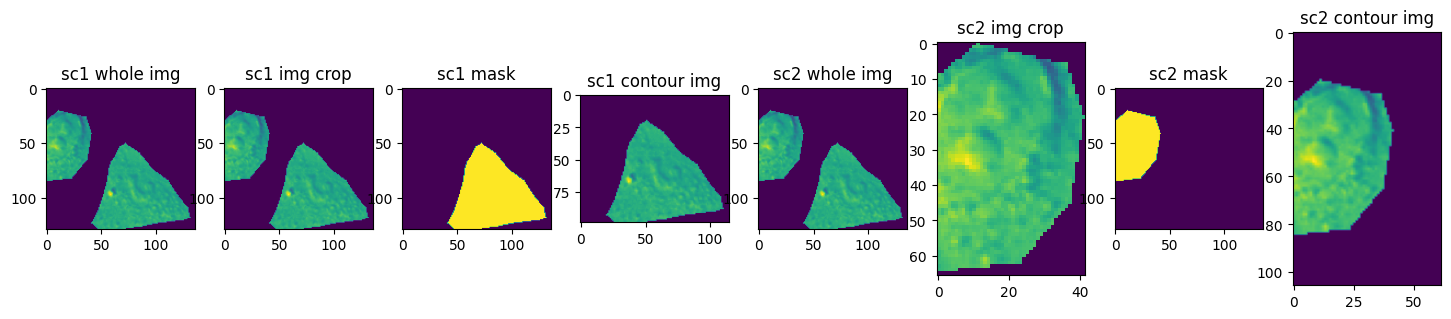

In [13]:
viz_check_combined_sc_result(new_sc1, new_sc2)

In [14]:
def gen_synthetic_overlap_scs(sc1, sc2, max_overlap_percent=0.2, bg_scale=2.0, fix_sc1=False, min_reserved_area_percent = 0.7, max_try=1000):
    # TODO: optimize in the future via computational geometry; now simply use monte carlo for generating required synthetic data
    is_success = False
    counter = 0
    while not is_success and counter < max_try:
        is_success = True
        new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, bg_scale=bg_scale, fix_sc1=fix_sc1)
        # check overlap
        overlap_mask = np.logical_and(new_sc1.get_mask(), new_sc2.get_mask())
        overlap_percent = float(np.sum(overlap_mask)) / min(np.sum(new_sc1.get_mask()), np.sum(new_sc2.get_mask()))
        if overlap_percent > 0 and overlap_percent < max_overlap_percent:
            pass
        else:
            is_success = False

        # check area percent to prevent scs that are too small
        area = float(np.sum((new_sc1.get_contour_mask()>0).flatten())) + np.sum((new_sc2.get_contour_mask()>0).flatten())
        old_area = float(np.sum((sc1.get_contour_mask()>0).flatten())) + np.sum((sc2.get_contour_mask()>0).flatten())
        if (area / old_area)  < min_reserved_area_percent:
            is_success = False
        counter += 1

    return new_sc1, new_sc2, overlap_percent, is_success



# # check results
# for i in tqdm(range(4)):
#     new_sc1, new_sc2, _, is_success = gen_synthetic_overlap_scs(sc1, sc2)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

### Generate synthetic non-overlapping underseg cells 

In [15]:
def compute_distance_by_contour(sc1, sc2):
    # compute distance between two scs by their contour
    c1, c2 = sc1.get_contour(), sc2.get_contour()
    return compute_two_contours_min_distance(c1, c2)

sc3 = single_cells[3]
# fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# sc1.show_contour_img(ax=axes[0], padding=10000)
# sc2.show_contour_img(ax=axes[1], padding=10000)
# sc3.show_contour_img(ax=axes[2], padding=10000)


compute_distance_by_contour(sc1, sc2), compute_distance_by_contour(sc1, sc3), compute_distance_by_contour(sc2, sc3)

(382.227680839575, 1350.431412549338, 958.7935127022919)

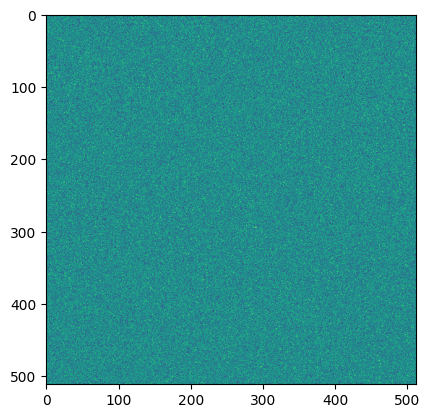

In [16]:
def gen_gauss_sc_bg(sc: SingleCellStatic, shape):
    """generate background for sc by gaussian noise"""
    img = sc.get_img()
    mask = sc.get_mask().astype(bool)
    bg_mask = np.logical_not(mask)

    # compute gauss distribution of background pixels
    pixels = img[bg_mask].flatten()
    mean = np.mean(pixels)
    std = np.std(pixels)
    res_bg_img = np.random.normal(0, 1, shape)
    res_bg_img = res_bg_img * std + mean
    return res_bg_img

plt.imshow(gen_gauss_sc_bg(sc1, (512, 512)))
    

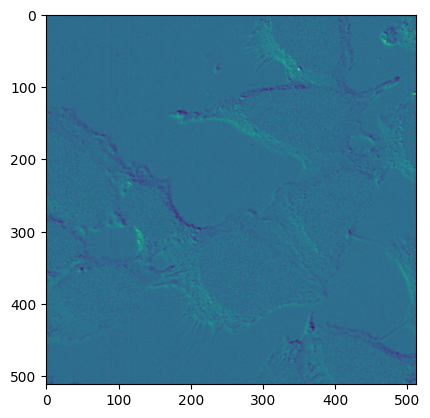

In [17]:
def gen_sc_bg_crop(sc, shape):
    """generate background for sc by cropping from the sc's image. For regions belong to single cells, remove cells and fill with gaussian noise."""
    img = sc.get_img()
    mask = sc.get_mask().astype(bool)
    bg_mask = np.logical_not(mask)
    if not (img.shape[0] >= shape[0] and img.shape[1] >= shape[1]):
        print("Shape of sc is smaller than the required shape, return None...")
        return None
    # compute gauss distribution of background pixels
    pixels = img[bg_mask].flatten()
    mean = np.mean(pixels)
    std = np.std(pixels)

    # randomly crop a region from the large image
    bounds = np.array(img.shape) - np.array(shape)
    crop_row, crop_col = np.random.randint(low=0, high=bounds, size=2)
    res_bg_img = np.array(img[crop_row:crop_row+shape[0], crop_col:crop_col+shape[1]])
    res_bg_mask = np.array(bg_mask[crop_row:crop_row+shape[0], crop_col:crop_col+shape[1]])

    res_bg_img[~res_bg_mask] = np.random.normal(0, 1, np.sum(~res_bg_mask)) * std + mean
    return res_bg_img


plt.imshow(gen_sc_bg_crop(sc1, (512, 512)))

In [18]:
def move_two_scs(sc1: SingleCellStatic, sc2: SingleCellStatic, pos_offset_vec, bg_img, inplace=False):
    if not inplace:
        sc1 = sc1.copy()
        sc2 = sc2.copy()
    img_space_dims = bg_img.shape
    pos_offset_vec = np.array(pos_offset_vec).astype(int)
    new_contour = np.array(sc2.get_contour()) + pos_offset_vec
    contour_before_adjust = new_contour.copy()
    tmp_sc2_bbox_before_adjust = SingleCellStatic.get_bbox_from_contour(contour_before_adjust)
    new_contour = adjust_contour_to_bounds(new_contour, img_space_dims)
    tmp_sc2 = sc2.copy()
    tmp_sc2.update_contour(new_contour, update_bbox=True)

    new_img = bg_img.copy()
    new_mask = np.zeros(bg_img.shape, dtype=np.uint8)
    sc1_bbox, sc2_bbox = sc1.get_bbox(), sc2.get_bbox()
    new_sc_bbox = tmp_sc2.get_bbox()
    projected_new_sc_bbox = (new_sc_bbox.reshape(2, 2) - pos_offset_vec).flatten()

    # Note that the boundaries are imgage dims + 1 because if skimage bbox's definition is [min_row, min_col, max_row, max_col)
    projected_new_sc_bbox = adjust_contour_to_bounds(projected_new_sc_bbox.reshape(2, 2), np.array(img_space_dims), bound_shift=0).flatten()
    if projected_new_sc_bbox[0] == img_space_dims[0]:
        projected_new_sc_bbox[0] -= 1
    if projected_new_sc_bbox[1] == img_space_dims[1]:
        projected_new_sc_bbox[1] -= 1
    
    # fix a corner case that may cause the projected_new_sc_bbox to be empty
    if projected_new_sc_bbox[2] == projected_new_sc_bbox[0]:
        projected_new_sc_bbox[2] += 1
    if projected_new_sc_bbox[3] == projected_new_sc_bbox[1]:
        projected_new_sc_bbox[3] += 1
    # print("dims: ", img_space_dims)
    # print("projected_new_sc_bbox: ", projected_new_sc_bbox)
    # print("new_sc_bbox: ", new_sc_bbox)

    # update datasets
    # TODO: consider if we have more datasets in single cell objects?
    new_img[sc1_bbox[0]:sc1_bbox[2], sc1_bbox[1]:sc1_bbox[3]] = sc1.get_img_crop()
    new_img[new_sc_bbox[0]:new_sc_bbox[2], new_sc_bbox[1]:new_sc_bbox[3]] = sc2.get_img_crop(bbox=projected_new_sc_bbox)
    new_mask[sc1_bbox[0]:sc1_bbox[2], sc1_bbox[1]:sc1_bbox[3]] |= sc1.get_mask_crop()
    new_mask[new_sc_bbox[0]:new_sc_bbox[2], new_sc_bbox[1]:new_sc_bbox[3]] |= sc2.get_mask_crop(bbox=projected_new_sc_bbox)
    
    # set image datasets of scs
    sc1.img_dataset = SingleImageDataset(new_img)
    sc1.mask_dataset = SingleImageDataset(new_mask)

    sc2.img_dataset = sc1.img_dataset
    sc2.mask_dataset = sc1.mask_dataset
    sc2.update_contour(tmp_sc2.get_contour(), update_bbox=True)

    return sc1, sc2

def move_two_syn_scs_close_or_apart(sc1: SingleCellStatic, sc2: SingleCellStatic, dist, bg_img, inplace=False, apart=False):
    if not inplace:
        sc1 = sc1.copy()
        sc2 = sc2.copy()
    overlap = sc1.compute_overlap_percent(sc2)
    img_space_dims = bg_img.shape
    assert overlap <= 1e-5, "Two scs should not overlap"

    # move sc2 toward sc1
    norm_vec = (sc1.get_center(crop=False) - sc2.get_center(crop=False))
    norm_vec = norm_vec / np.linalg.norm(norm_vec)
    pos_offset_vec = (norm_vec * dist).astype(int)
    if apart:
        pos_offset_vec = -pos_offset_vec
    return move_two_scs(sc1, sc2, pos_offset_vec=pos_offset_vec, bg_img=bg_img)

In [19]:

def move_util_in_range(sc1: SingleCellStatic, sc2: SingleCellStatic, dist_per_move, bg_img, min_dist=-np.inf, max_dist=np.inf, inplace=False, max_move=100, allow_overlap=False):
    """utilize move_two_syn_scs_close_or_apart to move two scs within a certain distance range"""
    if not inplace:
        sc1 = sc1.copy()
        sc2 = sc2.copy()

    # move sc2 toward sc1
    norm_vec = (sc1.get_center(crop=False) - sc2.get_center(crop=False))
    norm_vec = norm_vec / np.linalg.norm(norm_vec)

    cur_dist = compute_two_contours_min_distance(sc1.get_contour(), sc2.get_contour())
    if dist_per_move is None:
        # # TODO: make distance per move more efficient 
        # if cur_dist > max_dist:
        #     dist_per_move = (cur_dist - max_dist) / 2
        # elif cur_dist < min_dist:
        #     dist_per_move = (min_dist - cur_dist) / 2
        # else:
        #     dist_per_move = (max_dist - min_dist) / 2
        dist_per_move = (max_dist - min_dist) / 2

    pos_offset_vec_toward = (norm_vec * dist_per_move).astype(int)
    pos_offset_vec = pos_offset_vec_toward
    if cur_dist < min_dist:
        pos_offset_vec = - pos_offset_vec

    # print("start dist: ", cur_dist, "pos_offset_vec: ", pos_offset_vec, "min_dist: ", min_dist, "max_dist: ", max_dist, "allow_overlap: ", allow_overlap)
    counter = 0
    iou = sc1.compute_iou(sc2)
    while (cur_dist < min_dist or cur_dist > max_dist or (not allow_overlap and iou > 0)) and counter < max_move:
        sc1, sc2 = move_two_scs(sc1, sc2, pos_offset_vec=pos_offset_vec, bg_img=bg_img, inplace=inplace)
        cur_dist = compute_two_contours_min_distance(sc1.get_contour(), sc2.get_contour())
        iou = sc1.compute_iou(sc2)
        # print("cur_dist: ", cur_dist, "iou: ", iou, "pos_offset_vec: ", pos_offset_vec)
        norm_vec = (sc1.get_center(crop=False) - sc2.get_center(crop=False))
        norm_vec = norm_vec / np.linalg.norm(norm_vec)
        pos_offset_vec_toward = (norm_vec * dist_per_move).astype(int)
        if iou > 0 or cur_dist < min_dist:
            pos_offset_vec = - pos_offset_vec_toward
        else:
            pos_offset_vec = pos_offset_vec_toward
        counter += 1
    return sc1, sc2

def gen_synthetic_nonoverlap_scs(sc1: SingleCellStatic, sc2: SingleCellStatic, min_dist=-np.inf, max_dist=np.inf, min_reserved_area_percent = 0.7, bg_scale=3.0, fix_sc1=False, max_try=1000, gen_bg_func=None, use_move_close=True, dist_per_move=None):
    is_success = False
    counter = 0
    sc1_shape = sc1.get_contour_mask().shape
    sc2_shape = sc2.get_contour_mask().shape
    max_shape = np.max(np.array([sc1_shape, sc2_shape]), axis=0) * bg_scale

    syn_bg_shape = (int(max_shape[0]), int(max_shape[1]))

    while not is_success and counter < max_try:
        is_success = True
        bg_img = None
        if gen_bg_func is not None:
            bg_img = gen_bg_func(sc1, shape=syn_bg_shape)
            if bg_img is None:
                is_success = False
                continue
        
        # TODO: we can improve this function by replacing monte carlo method
        # TODO: calculate distance between two scs and move two scs together can satisfy the conditions efficiently
        new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=bg_img, bg_scale=bg_scale, fix_sc1=fix_sc1)
        if use_move_close:
            new_sc1, new_sc2 = move_util_in_range(new_sc1, new_sc2, dist_per_move=dist_per_move, bg_img=bg_img, min_dist=min_dist, max_dist=max_dist, inplace=True, max_move=100)
        # check overlap
        overlap_percent = new_sc1.compute_iou(new_sc2)
        if overlap_percent > 1e-5:
            is_success = False
        dist = compute_distance_by_contour(new_sc1, new_sc2)
        if dist < min_dist or dist > max_dist:
            is_success = False

        # check area percent to prevent scs that are too small
        area = float(np.sum((new_sc1.get_contour_mask()>0).flatten())) + np.sum((new_sc2.get_contour_mask()>0).flatten())
        old_area = float(np.sum((sc1.get_contour_mask()>0).flatten())) + np.sum((sc2.get_contour_mask()>0).flatten())
        if (area / old_area)  < min_reserved_area_percent:
            is_success = False

        # print("counter: {}, overlap: {}, dist: {}, %%area: {}".format(counter, overlap_percent, dist, area / old_area))
        counter += 1
    return new_sc1, new_sc2, dist, is_success

# # check results
# min_dist = 30
# max_dist = 100
# for i in tqdm(range(2)):
#     new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_sc_bg_crop, min_dist=min_dist, max_dist=max_dist, dist_per_move=30)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

# for i in tqdm(range(2)):
#     new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=min_dist, max_dist=max_dist, dist_per_move=30)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

Test move cells functionality

  0%|          | 0/5 [00:00<?, ?it/s]

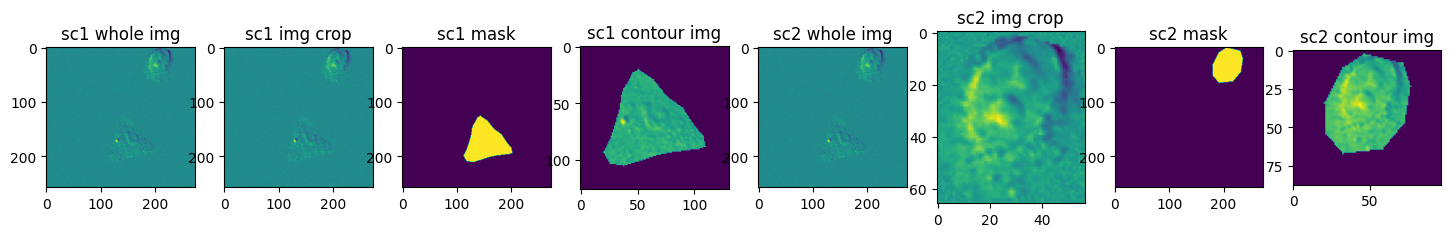

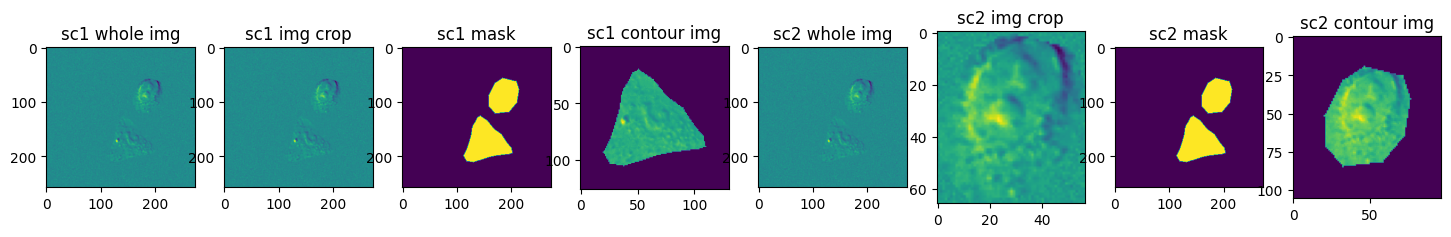

 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

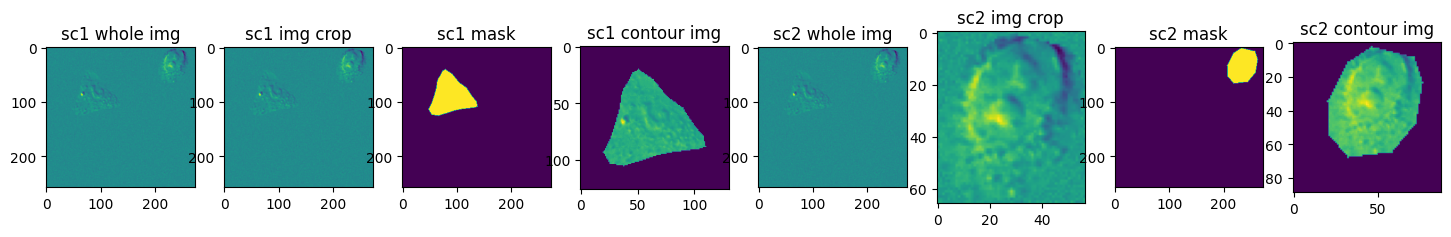

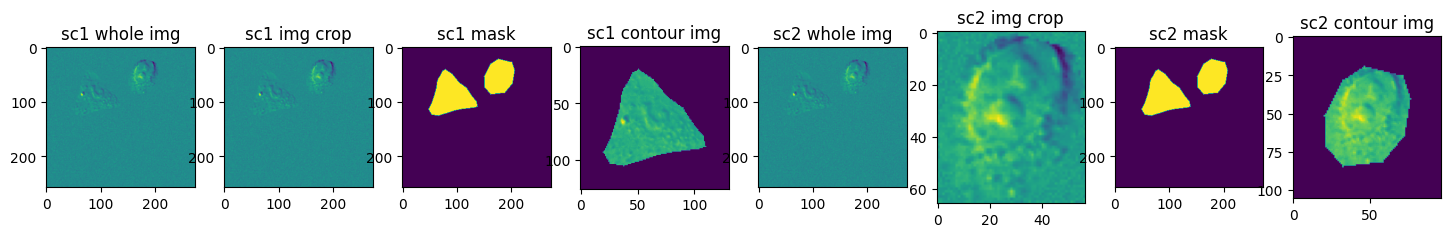

 40%|████      | 2/5 [00:04<00:05,  2.00s/it]

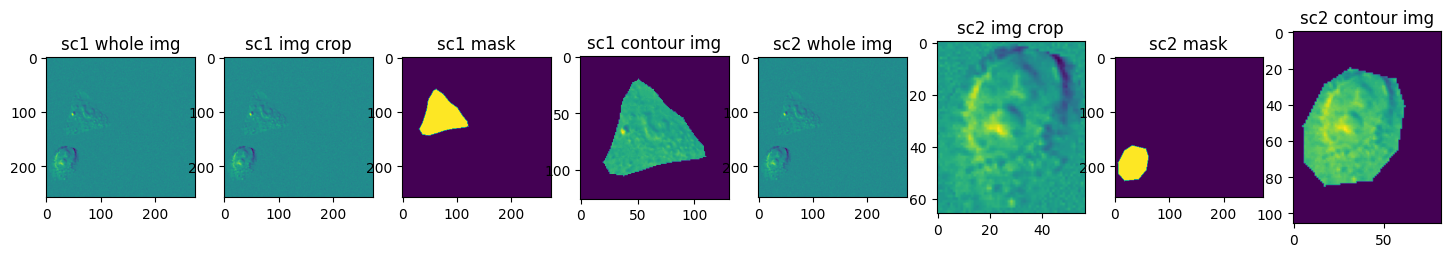

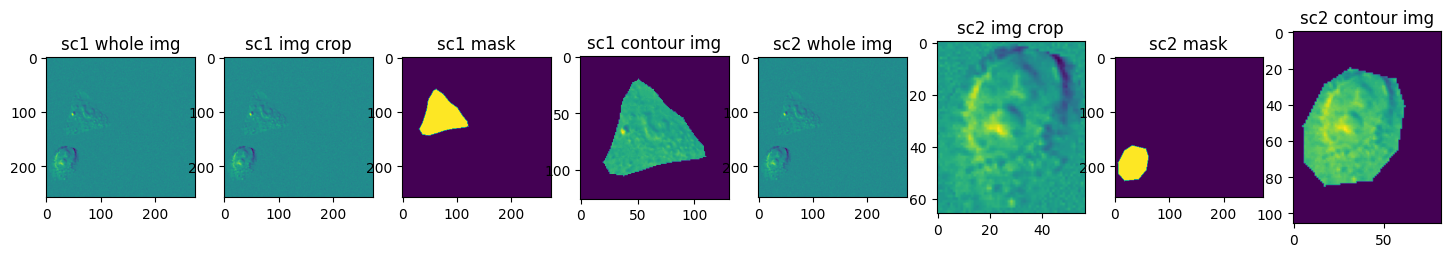

 60%|██████    | 3/5 [00:05<00:03,  1.83s/it]

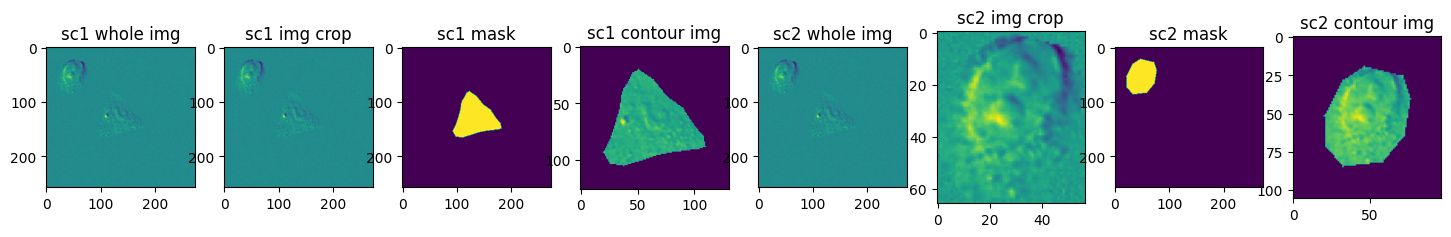

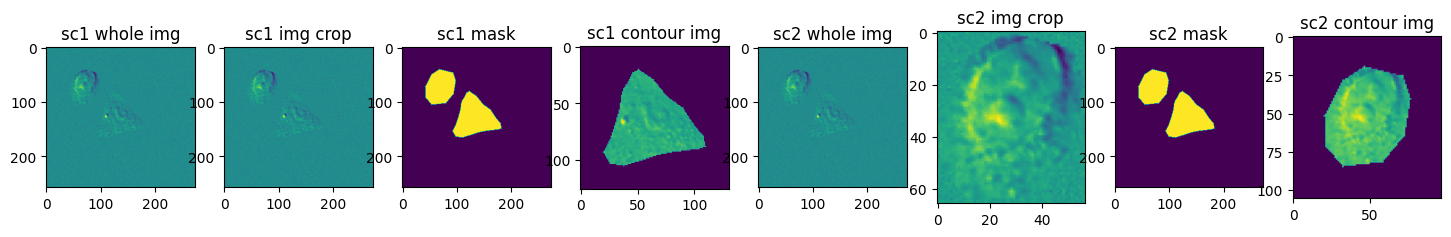

 80%|████████  | 4/5 [00:11<00:03,  3.28s/it]

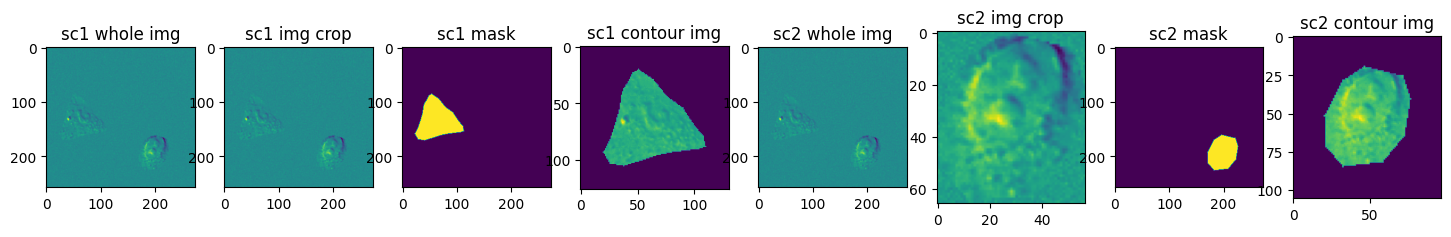

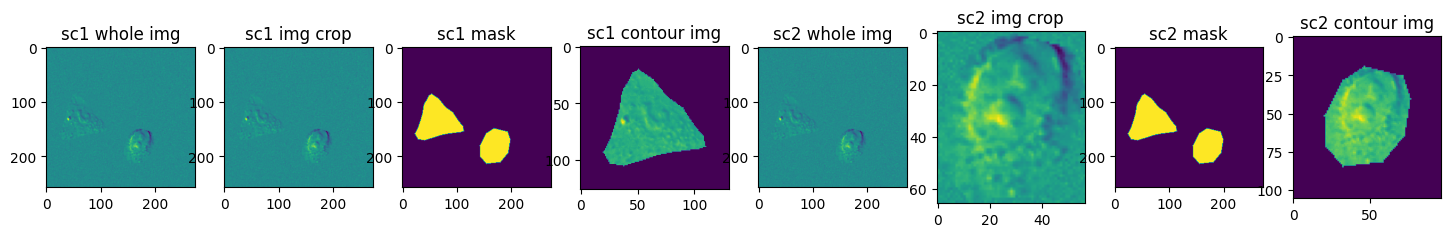

100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


In [20]:

for i in tqdm(range(5)):
    new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=10, max_dist=1000,  min_reserved_area_percent=1)
    viz_check_combined_sc_result(new_sc1, new_sc2)
    # move_two_syn_scs_close_or_apart(new_sc1, new_sc2, dist=40, bg_img=gen_gauss_sc_bg(new_sc1, shape=new_sc1.get_img().shape), inplace=True)
    move_util_in_range(new_sc1, new_sc2, dist_per_move=30, bg_img=gen_gauss_sc_bg(new_sc1, shape=new_sc1.get_img().shape), min_dist=10, max_dist=40, inplace=True, max_move=100)
    viz_check_combined_sc_result(new_sc1, new_sc2)

In [21]:
from typing import Tuple
from skimage.measure import regionprops
import pandas as pd
from livecell_tracker.core.io_utils import save_tiff
from livecell_tracker.segment.ou_utils import csn_augment_helper, underseg_overlay_gt_masks, gen_aug_diff_mask


check sc areas 
```
for sc in single_cells:
    prop = sc.compute_regionprops()
    assert prop.area > 5
```

In [22]:
def augment_and_save_merged_sc(sc: SingleCellStatic, scale_factors, scs, img_id, seg_label, syn_id, out_dir):
    # img_crop = sc.get_img_crop()
    # seg_crop = sc.get_mask_crop()

    # Note: do not use get_img_crop() and get_mask_crop() here, because we want to use the original image and mask
    # which are consistent across scs passed in
    img_crop = sc.get_img()
    seg_crop = sc.get_mask()

    syn_underseg_out_dir = out_dir
    raw_out_dir = syn_underseg_out_dir / "raw"
    seg_out_dir = syn_underseg_out_dir / "seg"
    gt_out_dir = syn_underseg_out_dir / "gt"
    gt_label_out_dir = syn_underseg_out_dir / "gt_label_mask"
    augmented_seg_dir = syn_underseg_out_dir / "augmented_seg"
    raw_transformed_img_dir = syn_underseg_out_dir / "raw_transformed_img"
    augmented_diff_seg_dir = syn_underseg_out_dir / "augmented_diff_seg"

    # makedirs
    all_dirs = [syn_underseg_out_dir, raw_out_dir, seg_out_dir, gt_out_dir, gt_label_out_dir, augmented_seg_dir, raw_transformed_img_dir, augmented_diff_seg_dir]
    for directory in all_dirs:
        if not directory.exists():
            print(">>> creating dir: ", directory)
            os.makedirs(directory, exist_ok=True)


    # generate combined gt label mask
    combined_gt_label_mask = np.zeros(seg_crop.shape, dtype=int)
    for i, tmp_sc in enumerate(scs):
        # mask = SingleCellStatic.gen_skimage_bbox_img_crop(sc.bbox, tmp_sc.get_mask())
        mask = tmp_sc.get_mask().astype(bool)
        if mask.shape != combined_gt_label_mask.shape:
            print("mask dim: ", mask.shape)
            print("combined_gt_label_mask dim: ", combined_gt_label_mask.shape)
        combined_gt_label_mask[mask] = i + 1

    raw_img_path = raw_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    seg_img_path = seg_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_img_path = gt_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_label_img_path = gt_label_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))

    underseg_train_tuples = []
    augmented_data = []
    filename_pattern = "syn-underseg-img-%d_seg-%d.tif"
    res_dict = csn_augment_helper(img_crop=img_crop, 
        seg_crop=seg_crop, 
        combined_gt_label_mask=combined_gt_label_mask,
        overseg_raw_seg_crop=None,
        overseg_raw_seg_img_path=None,
        scale_factors=scale_factors,
        train_path_tuples=underseg_train_tuples,
        augmented_data=augmented_data,
        img_id=img_id,
        seg_label=syn_id,
        gt_label=-1,
        raw_img_path=raw_img_path,
        seg_img_path=seg_img_path,
        gt_img_path=gt_img_path,
        gt_label_img_path=gt_label_img_path,
        augmented_seg_dir=augmented_seg_dir,
        augmented_diff_seg_dir=augmented_diff_seg_dir,
        filename_pattern=filename_pattern,
        raw_transformed_img_dir=raw_transformed_img_dir,
        df_save_path=syn_underseg_out_dir/"data.csv",
    )
    return res_dict
        
    

In [23]:
import itertools
from skimage.measure import find_contours
import cv2

def show_cv2_contours(contours, img):
    im = np.expand_dims(img.astype(np.uint8), axis=2).repeat(3, axis=2) 
    for k, _ in enumerate(contours):
        im = cv.drawContours(im, contours, k, (0, 230, 255), 6)
    plt.imshow(im)
    plt.show()

def find_contours_opencv(mask) -> list:
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = list(contours)
    for i, contour in enumerate(contours):
        contour = np.array(contour)
        contour = contour[:, :, ::-1]
        contour = contour.reshape(-1, 2)
        contours[i] = contour
    return contours

def merge_two_scs_overlap(sc1: SingleCellStatic, sc2: SingleCellStatic):
    new_mask = np.logical_or(sc1.get_mask().astype(bool), sc2.get_mask().astype(bool))
    # plt.imshow(new_mask)
    # plt.show()
    # print(np.unique(new_mask))
    # contours = find_contours(new_mask, fully_connected="high")

    contours = find_contours_opencv(new_mask.astype(np.uint8))
    assert len(contours) != 0, "must contain at least one contour"
    if len(contours) > 1:
        print("WARNING: more than one contour found, return merge failure to the caller...")
        return None, False
    new_contour = contours[0]
    res_sc = SingleCellStatic(
        timeframe=SingleImageDataset.DEFAULT_TIME,
        contour=new_contour,
        img_dataset=sc1.img_dataset,
        mask_dataset=SingleImageDataset(new_mask),
    )
    return res_sc, True



def merge_two_scs_nonoverlap(sc1: SingleCellStatic, sc2: SingleCellStatic, max_dilate_iter=998, kernel_shape=(3, 3)):
    new_mask = np.logical_or(sc1.get_mask().astype(bool), sc2.get_mask().astype(bool))

    contours = find_contours_opencv(new_mask.astype(np.uint8))
    assert len(contours) != 0, "must contain at least one contour"
    if len(contours) != 2:
        print("WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...")
        return None, False

    # dilate until the two contours are merged
    kernel = np.ones(kernel_shape, np.uint8)
    counter = 0
    while len(contours) != 1 and counter < max_dilate_iter:
        new_mask = cv2.dilate(new_mask.astype(np.uint8), kernel, iterations=1)
        contours = find_contours_opencv(new_mask.astype(np.uint8))
        counter += 1

    if len(contours) != 1:
        print("WARNING: #contours should be exactly 1 after merging two cells in the non-overlap case, return merge failure to the caller...")
        return None, False
    
    new_contour = contours[0]
    res_sc = SingleCellStatic(
        timeframe=SingleImageDataset.DEFAULT_TIME,
        contour=new_contour,
        img_dataset=sc1.img_dataset,
        mask_dataset=SingleImageDataset(new_mask),
    )
    return res_sc, True


def gen_underseg_scs_sample(scs, num_cells, save_dir=None, sample_id=None, augment_scale_factors=None,viz_check=False, sc_generator_func=gen_synthetic_overlap_scs, sc_generator_func_kwargs={}, merge_func=merge_two_scs_overlap):
    assert len(scs) > 0, "tmp_scs is empty"
    cur_merged_sc = scs[0].copy()
    # merged_scs contains each individual single AFTER merging
    _merged_scs = None
    is_success = True
    for j in range(1, num_cells):
        is_success = True
        cur_sc = scs[j]
        cur_merged_sc, new_sc2, _, is_gen_success = sc_generator_func(cur_merged_sc, cur_sc, fix_sc1=True, **sc_generator_func_kwargs)
        is_success &= is_gen_success
        if not is_success:
            break

        if _merged_scs is None:
            _merged_scs = [cur_merged_sc]
        
        _merged_scs.append(new_sc2)

        assert cur_merged_sc.get_mask().shape == new_sc2.get_mask().shape, "contact developer: two generated underseg scs should have the same shape"
        cur_merged_sc, is_merge_success = merge_func(cur_merged_sc, new_sc2)
        is_success &= is_merge_success
        if not is_success:
            break
    
    # at some point, the merging process failed
    if not is_success:
        print("synthesize failure for combination:", scs)
        return {"is_success": False}
    
    if viz_check:
        viz_check_combined_sc_result(cur_merged_sc, new_sc2)

    # Now we make sure that the masks of the merged scs have the same shape (in the same space)
    # for operate them easier later (e.g. merge the mask and generate label masks)
    # the scs' bbox coordinates keeps the same, relative to the cur_merged_sc
    # the image and mask dataset may be different in each iteration above
    # thus we need to update the img_dataset and mask_dataset for each sc in merged_syn_scs
    for sc in _merged_scs:
        sc.img_dataset = cur_merged_sc.img_dataset

        # all datasets below should be single image datasets
        cur_merged_mask_shape = cur_merged_sc.get_mask().shape
        sc_mask_in_merged_space = np.zeros(cur_merged_mask_shape, dtype=np.uint8)
        sc.update_bbox()

        # update sc_mask by intersection of bbox
        # note that the new sc_mask should be smaller than the original sc_mask due to our simulator's scale factor setting
        # sometimes the bbox is out of range, we need to check it.
        # TODO: investigate why the following condition is not always true...
        is_bbox_make_sense = sc.bbox[0] >= 0 and sc.bbox[1] >= 0 and sc.bbox[2] <= cur_merged_mask_shape[0] and sc.bbox[3] <= cur_merged_mask_shape[1]
        if not is_bbox_make_sense:
            print("generated sc_mask of the merged cell is smaller than that of one sc: sc bbox is out of range, sc.bbox=%s, sc_mask_shape=%s" % (str(sc.bbox), str(cur_merged_mask_shape)))
            return {"is_success": False}

        # when we generate the synthetic underseg scs, we fix coordinates of the first sc, so the cooridnates of the synthetic cells are always fixed relative to the first sc and in the same space. 
        sc_mask_in_merged_space[sc.bbox[0]:sc.bbox[2], sc.bbox[1]:sc.bbox[3]] = sc.get_mask()[sc.bbox[0]:sc.bbox[2], sc.bbox[1]:sc.bbox[3]]
        if viz_check:
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(sc.get_mask())
            axes[0].set_title("sc mask")
            axes[1].imshow(sc_mask_in_merged_space)
            axes[1].set_title("sc mask after update")
            plt.show()
        sc.mask_dataset = SingleImageDataset(sc_mask_in_merged_space)
        contours = find_contours_opencv(sc_mask_in_merged_space)
        if len(contours) > 1 or len(contours) == 0:
            print("[WARNING] contours numbers=", len(contours), " when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...")
            is_success = False
            return {
                "is_success": False,
            }
        sc.update_contour(contours[0])
        assert sc.get_mask().shape == cur_merged_sc.get_mask().shape, "Two generated underseg scs should have the same shape"

    cur_merged_sc.meta = {
        "num_merged_cells": num_cells,
    }
    if save_dir:
        assert sample_id is not None, "sample_id should be provided if save_dir is provided"
        assert augment_scale_factors is not None, "augment_scale_factors should be provided if save_dir is provided"
        res_dict = augment_and_save_merged_sc(cur_merged_sc, augment_scale_factors, scs=_merged_scs, img_id=sample_id, seg_label=sample_id, syn_id=sample_id, out_dir=save_dir)
        df = res_dict["df"]
    return {
        "is_success": is_success,
        "merged_scs": _merged_scs,
        "cur_merged_sc": cur_merged_sc,
        "df": df,
    }
            

def _gen_underseg_scs_sample_wrapper(inputs):
    return gen_underseg_scs_sample(**inputs)


def gen_underseg_scs(scs, num_cells = 3, total_sample_num = 1000, return_scs=False, save_dir: Path=None, augment_scale_factors=np.linspace(0, 0.1, 10), shuffle=True, sample_id_offset=0, viz_check=False, parallel=True, sc_generator_func=gen_synthetic_overlap_scs, sc_generator_func_kwargs=dict(), merge_func=merge_two_scs_overlap):
    import random
    import math
    import tqdm
    i = sample_id_offset
    scs = list(scs)
    # random.shuffle(scs)
    def _process_sequential():
        with tqdm.tqdm(total=total_sample_num) as pbar:
            counter = 0
            for i in enumerate(range(num_cells)):
                # sample n scs from scs
                tmp_scs = random.sample(scs, num_cells)
                sample_id = i + sample_id_offset
                res_data = gen_underseg_scs_sample(tmp_scs, num_cells, viz_check=viz_check, save_dir=save_dir, sample_id=sample_id, augment_scale_factors=augment_scale_factors, sc_generator_func=sc_generator_func, sc_generator_func_kwargs=sc_generator_func_kwargs, merge_func=merge_func)
                if not res_data["is_success"]:
                    continue
                _merged_scs = res_data["merged_scs"]
                cur_merged_sc = res_data["cur_merged_sc"]

                sample_id += 1
                counter += 1
                pbar.update(1)
                if counter >= total_sample_num:
                    break

    # parallel version
    def process_parallel(required_sample_num, all_df, counter, cur_id):
        inputs = []
        for i in range(required_sample_num):
            tmp_scs = random.sample(scs, num_cells)
            inputs.append({
                    "scs": tmp_scs,
                    "num_cells": num_cells,
                    "save_dir": save_dir,
                    "sample_id": cur_id + sample_id_offset,
                    "augment_scale_factors": augment_scale_factors,
                    "viz_check": viz_check,
                    "sc_generator_func": sc_generator_func,
                    "sc_generator_func_kwargs": sc_generator_func_kwargs,
                    "merge_func": merge_func,
                })
            cur_id += 1

        from multiprocessing import Pool
        pool = Pool()
        res_single_cells = []
        for res_dict in tqdm.tqdm(pool.imap_unordered(_gen_underseg_scs_sample_wrapper, inputs), total=len(inputs)):
            if not res_dict["is_success"]:
                continue
            _merged_scs = res_dict["merged_scs"]
            cur_merged_sc = res_dict["cur_merged_sc"]
            df = res_dict["df"]
            if all_df is None:
                all_df = df
            else:
                all_df = pd.concat([all_df, df], ignore_index=True)
            counter += 1
        pool.close()
        pool.join()
        return all_df, counter, cur_id
    
    if parallel:
        all_df = None
        counter = 0
        cur_id = 0
        while counter < total_sample_num:
            print(">>>>>>> parallely generate underseg scs, generated sample num: ", counter, "cur_id=", cur_id, "total_sample_num:", total_sample_num, "<<<<<<<")
            all_df, counter, cur_id = process_parallel(total_sample_num - counter, all_df, counter, cur_id)
        return all_df
    else:
        _process_sequential()


Viz merge two cells

Overlap case

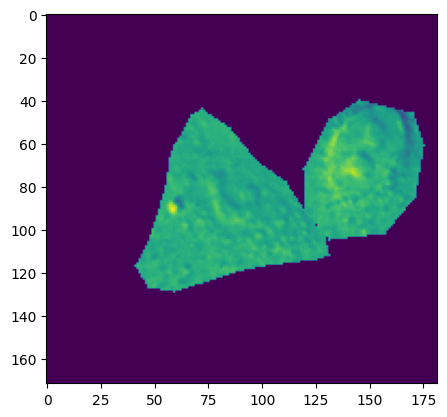

In [24]:
new_sc1, new_sc2, _, _ = gen_synthetic_overlap_scs(sc1, sc2, min_reserved_area_percent=1)
sc3, is_success = merge_two_scs_overlap(new_sc1, new_sc2)
if is_success:
    sc3.show()

Nonoverlap case

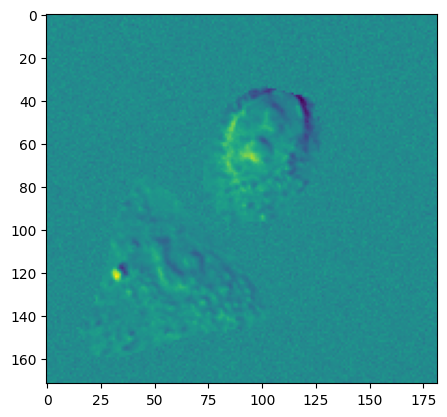

In [25]:
new_sc1, new_sc2, _, _ = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=10, max_dist=50, bg_scale=2, min_reserved_area_percent=1)
sc3, is_success = merge_two_scs_nonoverlap(new_sc1, new_sc2)
if is_success:
    sc3.show()

show nonoverlap merge case: merge by dilation. sc3 represents a generated under-segmentation case.

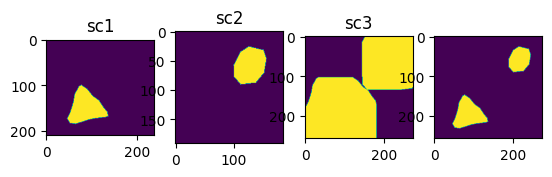

In [26]:
new_sc1, new_sc2, _, _ = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_sc_bg_crop)
sc3, is_success = merge_two_scs_nonoverlap(new_sc1, new_sc2)
if is_success:
    fig, axes = plt.subplots(1, 4)
    padding = 100
    new_sc1.show_mask(ax=axes[0], crop=True, padding=padding)
    axes[0].set_title("sc1")
    new_sc2.show_mask(ax=axes[1], crop=True, padding=padding)
    axes[1].set_title("sc2")
    sc3.show_mask(ax=axes[2], crop=True, padding=padding)
    axes[2].set_title("sc3")

    axes[3].imshow(new_sc1.get_mask() + new_sc2.get_mask())


In [27]:
def test_gen_underseg_scs():
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=1)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=1, num_cells=4, total_sample_num=1)

def gen_syn_overlap_underseg_data_v7(sample_num=10):
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    # generate training data
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)


def gen_syn_overlap_underseg_test_data_v7(sample_num = 100):
    def _save_all_df(all_df):
        all_df.to_csv(out_dir / "synthetic_underseg_overlap" / "data.csv", index=False)

    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    # generate training data
    all_df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)



def gen_syn_nonoverlap_underseg_train_data(gen_bg_func, subdir, sample_num = 10):
    underseg_out_dir = out_dir / subdir
    def _save_all_df(all_df):
        all_df.to_csv(underseg_out_dir / "data.csv", index=False)

    # generate training data    
    generator_args = {
        "min_dist": 3,
        "max_dist": 20,
        "bg_scale": 3,
        "gen_bg_func": gen_bg_func
    }
    all_df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num, sc_generator_func=gen_synthetic_nonoverlap_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num, sc_generator_func=gen_synthetic_nonoverlap_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2, sc_generator_func=gen_synthetic_nonoverlap_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)


Single core version for testing

In [28]:
def test_gen():
    subdir = Path("synthetic_underseg_nonoverlap_test")
    underseg_out_dir = out_dir / subdir
    generator_args = {"min_dist": 10, "max_dist": 30, "bg_scale": 3, "gen_bg_func": gen_gauss_sc_bg}
    df = gen_underseg_scs(
        scs=single_cells,
        save_dir=underseg_out_dir,
        sample_id_offset=0,
        num_cells=3,
        total_sample_num=5,
        sc_generator_func=gen_synthetic_nonoverlap_scs,
        sc_generator_func_kwargs=generator_args,
        merge_func=merge_two_scs_nonoverlap,
        viz_check=True,
        parallel=True,
    )


In [31]:
test_gen()

>>>>>>> parallely generate underseg scs, generated sample num:  0 cur_id= 0 total_sample_num: 5 <<<<<<<


  0%|          | 0/5 [00:00<?, ?it/s]

>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test
>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test/raw
>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test/seg
>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test/gt
>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test/gt_label_mask
>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test/augmented_seg
>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test/raw_transformed_img
>>> creating dir:  notebook_results/a549_ccp_vim/train_data_v7/synthetic_underseg_nonoverlap_test/augmented_diff_seg


 40%|████      | 2/5 [00:14<00:19,  6.46s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


>>>>>>> parallely generate underseg scs, generated sample num:  4 cur_id= 5 total_sample_num: 5 <<<<<<<


100%|██████████| 1/1 [00:07<00:00,  7.52s/it]


In [32]:
# train data
gen_syn_nonoverlap_underseg_train_data(gen_bg_func=gen_gauss_sc_bg, subdir=Path("synthetic_underseg_nonoverlap_gauss"), sample_num=500);

# test data
# gen_syn_nonoverlap_underseg_train_data(gen_bg_func=gen_gauss_sc_bg, subdir=Path("synthetic_underseg_nonoverlap_gauss"), sample_num=100)

>>>>>>> parallely generate underseg scs, generated sample num:  0 cur_id= 0 total_sample_num: 500 <<<<<<<


  0%|          | 0/500 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc10>]


  0%|          | 1/500 [00:04<34:59,  4.21s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd90>]


  0%|          | 2/500 [00:05<18:24,  2.22s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef910>]


  1%|          | 3/500 [00:06<15:57,  1.93s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>]


  1%|          | 4/500 [00:07<12:52,  1.56s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  1%|          | 5/500 [00:12<22:33,  2.73s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef850>]


  1%|          | 6/500 [00:14<20:32,  2.50s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>]


  1%|▏         | 7/500 [00:15<16:25,  2.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  2%|▏         | 8/500 [00:26<40:59,  5.00s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef430>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef220>]


  2%|▏         | 11/500 [00:31<24:30,  3.01s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef430>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef220>]


  2%|▏         | 12/500 [00:32<18:38,  2.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8eaa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef910>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa30>]


  3%|▎         | 14/500 [00:35<15:30,  1.91s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▍         | 20/500 [00:46<10:13,  1.28s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee500>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>]


  4%|▍         | 22/500 [00:49<10:38,  1.34s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee1d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee410>]


  5%|▍         | 23/500 [00:49<08:04,  1.02s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef670>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6d0>]


  5%|▌         | 25/500 [00:57<19:16,  2.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>]


  5%|▌         | 26/500 [00:59<18:54,  2.39s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee350>]


  6%|▌         | 28/500 [01:08<28:00,  3.56s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▌         | 29/500 [01:08<20:39,  2.63s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee1d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee410>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeb90>]


  6%|▌         | 31/500 [01:23<43:41,  5.59s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef220>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eefe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efee0>]


  6%|▋         | 32/500 [01:26<35:38,  4.57s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3c4c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eefe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdc0>]


  7%|▋         | 35/500 [01:32<21:18,  2.75s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>]


  7%|▋         | 36/500 [01:34<19:57,  2.58s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2200>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef640>]


  7%|▋         | 37/500 [01:36<18:00,  2.33s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 38/500 [01:40<22:42,  2.95s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>]


  8%|▊         | 39/500 [01:44<24:36,  3.20s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>]


  8%|▊         | 40/500 [01:44<17:56,  2.34s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 41/500 [01:45<13:35,  1.78s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 42/500 [01:48<15:59,  2.10s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>]


  9%|▊         | 43/500 [01:55<29:15,  3.84s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>]


  9%|▉         | 44/500 [01:58<25:40,  3.38s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9d0>]


  9%|▉         | 45/500 [01:59<19:50,  2.62s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|▉         | 49/500 [02:15<31:16,  4.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 50/500 [02:24<41:27,  5.53s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 52/500 [02:28<29:07,  3.90s/it]

synthesize failure for combination:  2[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efeb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>] 


 11%|█         | 53/500 [02:29<21:10,  2.84s/it]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff70>]


 11%|█         | 55/500 [02:31<15:32,  2.10s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d0c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd30>]


 11%|█         | 56/500 [02:41<30:08,  4.07s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 11%|█▏        | 57/500 [02:50<38:32,  5.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 58/500 [02:50<28:21,  3.85s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 59/500 [02:53<26:26,  3.60s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dc90>]


 12%|█▏        | 60/500 [02:54<22:30,  3.07s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 62/500 [02:58<17:31,  2.40s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 66/500 [03:08<23:25,  3.24s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 67/500 [03:10<19:31,  2.71s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeb90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef640>]


 14%|█▍        | 69/500 [03:12<14:10,  1.97s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 14%|█▍        | 70/500 [03:17<19:29,  2.72s/it]

synthesize failure for combination:

 14%|█▍        | 71/500 [03:22<23:26,  3.28s/it]

 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff70>]


 15%|█▍        | 73/500 [03:24<17:12,  2.42s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff10>]


 15%|█▍        | 74/500 [03:36<34:13,  4.82s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▌        | 75/500 [03:38<27:29,  3.88s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ca30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f280>]


 15%|█▌        | 76/500 [03:38<20:53,  2.96s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee440>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6191930>]


 15%|█▌        | 77/500 [03:40<18:20,  2.60s/it]

[WARNING] contours numbers= 

 16%|█▌        | 78/500 [03:48<29:32,  4.20s/it]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▌        | 81/500 [03:52<17:04,  2.45s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effd0>]


 17%|█▋        | 83/500 [03:53<10:24,  1.50s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 84/500 [03:53<08:41,  1.25s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>]


 17%|█▋        | 85/500 [03:59<17:09,  2.48s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>]


 18%|█▊        | 90/500 [04:19<19:52,  2.91s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>]


 18%|█▊        | 91/500 [04:21<17:05,  2.51s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef670>]


 18%|█▊        | 92/500 [04:27<24:53,  3.66s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efaf0>]


 19%|█▉        | 94/500 [04:36<26:12,  3.87s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▉        | 95/500 [04:38<20:54,  3.10s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▉        | 97/500 [04:43<20:09,  3.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 20%|█▉        | 99/500 [04:52<26:43,  4.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 20%|██        | 100/500 [05:03<40:41,  6.10s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 20%|██        | 101/500 [05:06<33:37,  5.06s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 103/500 [05:20<38:48,  5.86s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef700>]


 21%|██        | 104/500 [05:23<32:18,  4.89s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 105/500 [05:24<24:20,  3.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 106/500 [05:24<17:44,  2.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██▏       | 107/500 [05:32<28:40,  4.38s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 22%|██▏       | 108/500 [05:41<38:02,  5.82s/it]

 22%|██▏       | 110/500 [05:47<28:45,  4.42s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 115/500 [05:58<14:57,  2.33s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 117/500 [06:00<09:48,  1.54s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▎       | 118/500 [06:03<12:56,  2.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 119/500 [06:06<15:29,  2.44s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fa30>]


 24%|██▍       | 121/500 [06:19<27:58,  4.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 122/500 [06:21<24:13,  3.85s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee410>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eedd0>]


 25%|██▍       | 123/500 [06:25<23:31,  3.74s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff15a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3d0>]


 25%|██▌       | 125/500 [06:33<26:30,  4.24s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▌       | 126/500 [06:41<32:32,  5.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▌       | 129/500 [06:44<17:36,  2.85s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb20>]


 26%|██▌       | 130/500 [06:46<16:23,  2.66s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2b30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3d0>]


 26%|██▋       | 132/500 [06:46<09:42,  1.58s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 133/500 [06:47<08:30,  1.39s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba8f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61baaa0>]


 27%|██▋       | 134/500 [06:49<08:43,  1.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef430>]


 27%|██▋       | 135/500 [06:50<07:56,  1.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 136/500 [06:51<07:48,  1.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e020>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e650>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e170>]


 28%|██▊       | 138/500 [07:06<29:52,  4.95s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 139/500 [07:11<29:02,  4.83s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 140/500 [07:17<30:31,  5.09s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e650>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e170>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f820>]


 28%|██▊       | 141/500 [07:24<34:52,  5.83s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d0c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d390>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e650>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e170>]


 28%|██▊       | 142/500 [07:32<37:48,  6.34s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 29%|██▉       | 145/500 [07:48<29:12,  4.94s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|██▉       | 148/500 [07:49<11:48,  2.01s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|██▉       | 149/500 [07:50<10:54,  1.86s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef430>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef20>]


 30%|███       | 150/500 [07:53<12:57,  2.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|███       | 151/500 [08:03<25:21,  4.36s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███       | 153/500 [08:07<17:39,  3.05s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███       | 155/500 [08:09<11:59,  2.09s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 161/500 [08:46<28:55,  5.12s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef880>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618d3c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618dbd0>]


 33%|███▎      | 164/500 [08:50<15:07,  2.70s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>]


 33%|███▎      | 165/500 [08:54<17:53,  3.20s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 166/500 [09:04<27:36,  4.96s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>]


 34%|███▍      | 169/500 [09:13<20:09,  3.65s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>]


 34%|███▍      | 170/500 [09:19<24:53,  4.53s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 171/500 [09:22<21:35,  3.94s/it]

synthesize failure for combination: [WARNING] contours numbers=[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef760>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618d120>]
 

 34%|███▍      | 172/500 [09:25<19:45,  3.61s/it]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▍      | 174/500 [09:27<13:36,  2.51s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▌      | 177/500 [09:31<10:20,  1.92s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdc0>]


 36%|███▌      | 179/500 [09:41<16:18,  3.05s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 180/500 [09:41<12:04,  2.27s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>]


 36%|███▋      | 182/500 [09:43<08:45,  1.65s/it]

[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 2
 synthesize failure for combination: when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 
[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee90>]


 37%|███▋      | 185/500 [09:52<13:42,  2.61s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f4f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fb20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fa00>]


 37%|███▋      | 187/500 [10:07<22:58,  4.40s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 188/500 [10:08<18:38,  3.58s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 189/500 [10:10<16:01,  3.09s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 191/500 [10:40<50:57,  9.89s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 192/500 [10:44<42:09,  8.21s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f4f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fb20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fa00>]


 39%|███▉      | 194/500 [10:48<25:22,  4.97s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618d3c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618d8a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618fa60>]


 39%|███▉      | 197/500 [11:00<22:27,  4.45s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|███▉      | 198/500 [11:06<23:49,  4.73s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee500>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef20>]


 40%|████      | 202/500 [11:26<24:18,  4.89s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 205/500 [11:41<21:39,  4.40s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 206/500 [11:44<20:11,  4.12s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████▏     | 207/500 [11:56<30:45,  6.30s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 208/500 [12:06<36:08,  7.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616db40>]


 42%|████▏     | 210/500 [12:20<31:58,  6.61s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fb50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f640>]


 42%|████▏     | 211/500 [12:26<30:57,  6.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 212/500 [12:29<26:05,  5.44s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 214/500 [12:48<38:48,  8.14s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 215/500 [12:53<34:49,  7.33s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9c30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba8f0>]


 43%|████▎     | 217/500 [12:59<24:00,  5.09s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdf0>]


 44%|████▎     | 218/500 [13:16<40:08,  8.54s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d0c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d4e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616db70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e890>]


 44%|████▍     | 219/500 [13:17<29:34,  6.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 220/500 [13:17<21:35,  4.63s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 221/500 [13:18<16:22,  3.52s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9c30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba8f0>]


 44%|████▍     | 222/500 [13:22<15:56,  3.44s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 45%|████▍     | 223/500 [13:24<14:08,  3.06s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9c30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba8f0>]


 45%|████▍     | 224/500 [13:24<10:23,  2.26s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef640>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee440>]


 45%|████▌     | 225/500 [13:26<09:58,  2.18s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef640>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee440>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6191570>]


 45%|████▌     | 226/500 [13:28<09:57,  2.18s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▌     | 228/500 [13:36<14:08,  3.12s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▌     | 230/500 [13:49<20:37,  4.58s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee440>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6193ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6191570>]


 46%|████▋     | 232/500 [13:57<18:36,  4.17s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6191570>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6192b90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61930d0>]


 47%|████▋     | 233/500 [13:59<14:38,  3.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ca30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f940>]


 47%|████▋     | 234/500 [14:00<11:35,  2.61s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 237/500 [14:15<19:47,  4.52s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d4e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616db70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e890>]


 48%|████▊     | 238/500 [14:15<14:02,  3.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 48%|████▊     | 240/500 [14:23<14:14,  3.28s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 48%|████▊     | 242/500 [14:25<08:57,  2.08s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 244/500 [14:44<22:55,  5.37s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 245/500 [14:52<25:11,  5.93s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef670>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>]


 50%|████▉     | 249/500 [15:06<16:30,  3.95s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2b30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6185030>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6185240>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6187fd0>]


 50%|█████     | 251/500 [15:12<14:49,  3.57s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 256/500 [15:25<08:56,  2.20s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 260/500 [15:37<12:39,  3.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 261/500 [15:45<18:44,  4.71s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 265/500 [16:11<27:21,  6.98s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d810>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e350>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e5c0>]


 53%|█████▎    | 266/500 [16:13<21:23,  5.48s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 267/500 [16:17<19:08,  4.93s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▎    | 268/500 [16:22<19:09,  4.95s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▍    | 269/500 [16:26<18:05,  4.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▍    | 270/500 [16:30<17:03,  4.45s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▍    | 273/500 [16:44<16:35,  4.38s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efeb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619cfd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619dcc0>]
[WARNING] contours numbers=

 55%|█████▍    | 274/500 [16:44<12:04,  3.21s/it]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▌    | 275/500 [16:44<08:35,  2.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff24a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dd50>]


 55%|█████▌    | 276/500 [16:46<07:24,  1.98s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff15a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619e080>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619cfd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619dcc0>]


 55%|█████▌    | 277/500 [16:47<06:21,  1.71s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 278/500 [16:55<13:56,  3.77s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 280/500 [17:01<11:38,  3.18s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 281/500 [17:02<10:05,  2.77s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 284/500 [17:25<24:34,  6.83s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d540>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dea0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dd50>]


 57%|█████▋    | 285/500 [17:28<19:27,  5.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e170>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e920>]


 57%|█████▋    | 287/500 [17:31<11:48,  3.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 58%|█████▊    | 288/500 [17:31<08:50,  2.50s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 58%|█████▊    | 290/500 [17:42<12:42,  3.63s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e0e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618efe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618f4f0>]


 58%|█████▊    | 292/500 [17:52<14:52,  4.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7f0>]


 59%|█████▊    | 293/500 [17:55<12:40,  3.68s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6199150>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6199300>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6198b50>]


 59%|█████▉    | 295/500 [17:56<06:56,  2.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▉    | 296/500 [18:00<09:19,  2.74s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 60%|█████▉    | 298/500 [18:06<09:37,  2.86s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 60%|██████    | 302/500 [18:20<10:32,  3.19s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 303/500 [18:22<09:58,  3.04s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▏   | 309/500 [18:39<08:23,  2.64s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e680>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eb90>]


 62%|██████▏   | 310/500 [18:41<08:07,  2.56s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▏   | 311/500 [18:47<10:52,  3.45s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d0c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616de10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dbd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e980>]


 63%|██████▎   | 313/500 [18:57<13:49,  4.44s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ed70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>]


 63%|██████▎   | 315/500 [18:59<08:22,  2.72s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 316/500 [19:01<07:58,  2.60s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff40>]


 63%|██████▎   | 317/500 [19:02<05:43,  1.88s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3f5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff40>]


 64%|██████▍   | 319/500 [19:07<06:22,  2.11s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d240>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e680>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eb90>]


 64%|██████▍   | 321/500 [19:10<05:41,  1.91s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>]


 64%|██████▍   | 322/500 [19:10<04:07,  1.39s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6191330>]


 65%|██████▍   | 323/500 [19:17<09:18,  3.16s/it]

[WARNING] contours numbers=[WARNING] contours numbers=  22   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▍   | 324/500 [19:20<09:00,  3.07s/it]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 326/500 [19:29<10:50,  3.74s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 327/500 [19:41<16:16,  5.65s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 66%|██████▌   | 329/500 [19:50<13:51,  4.86s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2b30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>]


 66%|██████▌   | 330/500 [19:50<10:27,  3.69s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>]


 67%|██████▋   | 334/500 [20:00<08:29,  3.07s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ed70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e8f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618f610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618ed40>]


 67%|██████▋   | 336/500 [20:06<08:33,  3.13s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 67%|██████▋   | 337/500 [20:15<13:31,  4.98s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 338/500 [20:20<13:06,  4.86s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 339/500 [20:20<09:21,  3.49s/it]

synthesize failure for combination:WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 
[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e020>]synthesize failure for combination:
 

 68%|██████▊   | 340/500 [20:23<09:08,  3.43s/it]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197430>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197ee0>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▊   | 343/500 [20:25<04:24,  1.68s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e020>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eef0>]


 69%|██████▉   | 344/500 [20:26<03:38,  1.40s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 345/500 [20:26<02:53,  1.12s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e290>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e020>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eef0>]


 69%|██████▉   | 346/500 [20:33<07:26,  2.90s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 347/500 [20:37<07:32,  2.96s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|██████▉   | 348/500 [20:40<07:50,  3.10s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeb90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed70>]


 70%|██████▉   | 349/500 [20:43<08:02,  3.20s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeb90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6187eb0>]


 70%|███████   | 350/500 [20:46<07:12,  2.88s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|███████   | 352/500 [20:48<05:06,  2.07s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 353/500 [21:03<14:14,  5.82s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 355/500 [21:10<10:32,  4.36s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9c30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba8f0>]


 71%|███████   | 356/500 [21:11<08:14,  3.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████▏  | 357/500 [21:14<07:47,  3.27s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>]


 72%|███████▏  | 359/500 [21:18<06:10,  2.63s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 361/500 [21:34<13:10,  5.69s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 363/500 [21:39<09:41,  4.25s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 364/500 [21:45<10:36,  4.68s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619dbd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619ea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619da20>]


 73%|███████▎  | 365/500 [21:45<07:47,  3.47s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ca30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616ded0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d6f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f8b0>]


 73%|███████▎  | 366/500 [21:46<06:06,  2.73s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 367/500 [21:55<09:40,  4.37s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e050>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fbe0>]WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...


 74%|███████▎  | 368/500 [21:57<08:08,  3.70s/it]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197430>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197ee0>]


 74%|███████▍  | 370/500 [21:58<04:24,  2.03s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2200>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61960b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6197430>]


 74%|███████▍  | 372/500 [22:10<08:14,  3.86s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▍  | 373/500 [22:10<05:51,  2.77s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ed70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e8f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618f610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618ed40>]

 75%|███████▍  | 374/500 [22:18<08:59,  4.28s/it]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616de10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dbd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e980>]


 75%|███████▌  | 375/500 [22:18<06:19,  3.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▌  | 376/500 [22:27<09:56,  4.81s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 379/500 [22:35<07:02,  3.49s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 380/500 [22:36<05:11,  2.60s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618edd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e8f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618f610>]


 76%|███████▌  | 381/500 [22:36<03:49,  1.93s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▋  | 382/500 [22:50<10:54,  5.55s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 388/500 [23:06<04:53,  2.62s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 389/500 [23:06<03:55,  2.12s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2200>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff10>]


 78%|███████▊  | 390/500 [23:08<03:21,  1.83s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619e140>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619dbd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619ffa0>]


 78%|███████▊  | 391/500 [23:09<03:05,  1.70s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618d480>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e0e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618efe0>]


 78%|███████▊  | 392/500 [23:11<03:05,  1.72s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 394/500 [23:28<08:07,  4.60s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616ef80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f1c0>]


 79%|███████▉  | 395/500 [23:29<06:08,  3.51s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619ba00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619b2e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619ae30>]


 79%|███████▉  | 396/500 [23:31<05:12,  3.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 398/500 [23:39<06:04,  3.57s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|████████  | 400/500 [23:50<07:37,  4.58s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████  | 403/500 [23:59<05:48,  3.59s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee410>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6199780>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619bd90>]


 81%|████████  | 405/500 [24:05<04:48,  3.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████▏ | 407/500 [24:15<06:13,  4.01s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 408/500 [24:17<05:19,  3.47s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 410/500 [24:18<02:56,  1.96s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f4f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e4d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f5b0>]


 82%|████████▏ | 411/500 [24:22<03:50,  2.59s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 414/500 [24:30<03:37,  2.53s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>]


 83%|████████▎ | 415/500 [24:37<05:07,  3.62s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 416/500 [24:40<04:50,  3.46s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9d20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9990>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9c30>]


 83%|████████▎ | 417/500 [24:43<04:53,  3.54s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=

 84%|████████▎ | 418/500 [24:44<03:26,  2.52s/it]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 84%|████████▍ | 420/500 [24:49<03:30,  2.63s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d6f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fa90>]


 84%|████████▍ | 421/500 [24:51<03:23,  2.58s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>]


 84%|████████▍ | 422/500 [24:52<02:48,  2.16s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eb00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616db70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f4f0>]


 85%|████████▍ | 423/500 [24:56<03:08,  2.45s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eb00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616db70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f4f0>]


 85%|████████▍ | 424/500 [24:58<02:54,  2.29s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 85%|████████▌ | 426/500 [25:01<02:29,  2.02s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 85%|████████▌ | 427/500 [25:02<01:57,  1.60s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 428/500 [25:02<01:33,  1.30s/it]

[WARNING] contours numbers= 2WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...synthesize failure for combination:
 

 86%|████████▌ | 429/500 [25:03<01:27,  1.23s/it]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eef0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f9a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f100>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3f5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee440>]


 86%|████████▌ | 431/500 [25:06<01:29,  1.30s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ed70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618d900>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e8f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618db10>]


 86%|████████▋ | 432/500 [25:10<02:09,  1.90s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 433/500 [25:12<02:14,  2.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 436/500 [25:28<03:30,  3.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dbd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616e980>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f460>]


 88%|████████▊ | 438/500 [25:42<05:42,  5.53s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 440/500 [25:46<03:53,  3.90s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▊ | 443/500 [25:48<01:45,  1.86s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8ed70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e8c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618f6d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618ef50>]


 89%|████████▉ | 444/500 [25:48<01:17,  1.38s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d6f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fa90>]


 89%|████████▉ | 446/500 [25:52<01:34,  1.74s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 447/500 [25:53<01:16,  1.45s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616ee30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d4e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f070>]


 90%|████████▉ | 448/500 [25:53<00:59,  1.15s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8c700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efeb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee500>]


 90%|████████▉ | 449/500 [26:06<03:49,  4.51s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|█████████ | 450/500 [26:07<02:48,  3.38s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|█████████ | 451/500 [26:09<02:28,  3.04s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 453/500 [26:10<01:27,  1.86s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d570>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616dcc0>]


 91%|█████████ | 454/500 [26:11<01:02,  1.37s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 455/500 [26:16<01:51,  2.48s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 456/500 [26:16<01:24,  1.93s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7c8d510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9990>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61b9c30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61ba6e0>]


 92%|█████████▏| 458/500 [26:30<03:21,  4.79s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 459/500 [26:31<02:33,  3.74s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 462/500 [26:34<01:17,  2.03s/it]

[WARNING] contours numbers= 3  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 463/500 [26:39<01:42,  2.77s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 464/500 [26:40<01:17,  2.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 466/500 [26:42<00:59,  1.76s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2b30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61854e0>]


 94%|█████████▎| 468/500 [26:48<01:13,  2.28s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 469/500 [26:49<01:01,  2.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 471/500 [26:53<00:59,  2.04s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619dd20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619dbd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619df60>]


 95%|█████████▌| 475/500 [26:58<00:41,  1.65s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 478/500 [27:03<00:33,  1.50s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efeb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618e8c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618f6d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c618ef50>]


 96%|█████████▌| 479/500 [27:06<00:40,  1.94s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 480/500 [27:08<00:35,  1.77s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616d900>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f880>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616fbe0>]


 96%|█████████▌| 481/500 [27:08<00:25,  1.37s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2200>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6196b00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6196020>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6196350>]


 96%|█████████▋| 482/500 [27:09<00:25,  1.44s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 484/500 [27:19<00:48,  3.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 487/500 [27:20<00:19,  1.51s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 489/500 [27:24<00:16,  1.54s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 490/500 [27:27<00:20,  2.02s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616f3a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c616eb00>]


 98%|█████████▊| 492/500 [27:30<00:15,  1.91s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▊| 493/500 [27:36<00:21,  3.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 494/500 [27:42<00:24,  4.01s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619ad70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6199780>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c619bd90>]


 99%|█████████▉| 495/500 [27:43<00:14,  2.95s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 496/500 [27:47<00:12,  3.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|█████████▉| 498/500 [28:44<00:35, 17.63s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 500/500 [29:21<00:00,  3.52s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  185 cur_id= 500 total_sample_num: 500 <<<<<<<



  0%|          | 0/315 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efaf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb50>]


  0%|          | 1/315 [00:01<05:54,  1.13s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef4f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef910>]


  1%|          | 3/315 [00:01<02:28,  2.10it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc10>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>]


  2%|▏         | 5/315 [00:01<01:23,  3.71it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>]


  2%|▏         | 6/315 [00:02<01:28,  3.48it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effd0>]


  2%|▏         | 7/315 [00:03<02:35,  1.98it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2c0>]


  3%|▎         | 8/315 [00:05<04:38,  1.10it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed10>]


  3%|▎         | 9/315 [00:07<07:10,  1.41s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  3%|▎         | 10/315 [00:08<06:08,  1.21s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▍         | 14/315 [00:18<09:56,  1.98s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef190>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3a0>]


  5%|▌         | 16/315 [00:21<08:48,  1.77s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>]


  6%|▌         | 18/315 [00:23<06:36,  1.34s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▌         | 19/315 [00:25<07:49,  1.59s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▋         | 20/315 [00:26<06:40,  1.36s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a740>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39d20>]


  7%|▋         | 22/315 [00:32<10:39,  2.18s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aeef20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a740>]


  7%|▋         | 23/315 [00:33<08:02,  1.65s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b386d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff06a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0340>]


  8%|▊         | 25/315 [00:35<06:34,  1.36s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a740>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04040>]


  8%|▊         | 26/315 [00:35<04:58,  1.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▊         | 27/315 [00:36<04:40,  1.03it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▉         | 28/315 [00:37<04:28,  1.07it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▉         | 29/315 [00:38<04:38,  1.03it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 32/315 [00:41<04:51,  1.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 33/315 [00:46<09:49,  2.09s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2050>]


 11%|█         | 34/315 [00:46<07:57,  1.70s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2050>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbe80>]


 11%|█▏        | 36/315 [00:48<05:39,  1.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 37/315 [00:50<06:23,  1.38s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef340>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef190>]


 12%|█▏        | 38/315 [00:54<09:51,  2.14s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 39/315 [00:55<09:01,  1.96s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 42/315 [00:57<04:52,  1.07s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee500>]


 14%|█▎        | 43/315 [00:58<05:24,  1.19s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 14%|█▍        | 44/315 [00:59<05:23,  1.19s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 14%|█▍        | 45/315 [01:01<05:48,  1.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff01f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff06a0>]


 15%|█▍        | 46/315 [01:01<04:26,  1.01it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▌        | 48/315 [01:02<03:22,  1.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▌        | 50/315 [01:06<06:19,  1.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5f65450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e040a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05570>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb03a0>]


 16%|█▌        | 51/315 [01:10<08:49,  2.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 52/315 [01:10<06:33,  1.49s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 54/315 [01:15<08:33,  1.97s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fccca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed780>]


 18%|█▊        | 56/315 [01:16<05:19,  1.23s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff01f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff06a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa54b0>]


 18%|█▊        | 57/315 [01:18<06:32,  1.52s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05840>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>]


 18%|█▊        | 58/315 [01:19<05:31,  1.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a9e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eecb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef0a0>]


 19%|█▊        | 59/315 [01:21<06:18,  1.48s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb03a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a277c0>]


 20%|█▉        | 62/315 [01:25<05:53,  1.40s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa54b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc3a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172800>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2ad0>]


 20%|██        | 63/315 [01:26<05:17,  1.26s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 65/315 [01:28<04:01,  1.04it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 66/315 [01:28<03:22,  1.23it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5f65450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d58970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a770>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5f30>]


 21%|██▏       | 67/315 [01:30<04:12,  1.02s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e078e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04e20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7a0>]


 22%|██▏       | 69/315 [01:30<02:21,  1.73it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fccca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd1f00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd01c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd3820>]


 23%|██▎       | 73/315 [01:39<04:56,  1.23s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 74/315 [01:41<05:54,  1.47s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee500>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee860>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69e70>]


 24%|██▍       | 75/315 [01:42<04:56,  1.23s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcfc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5570>]


 24%|██▍       | 76/315 [01:42<03:57,  1.01it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aefa30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5570>]


 24%|██▍       | 77/315 [01:43<04:00,  1.01s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69e70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>]


 25%|██▍       | 78/315 [01:43<02:54,  1.36it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3c160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb3a90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69690>]


 25%|██▌       | 79/315 [01:44<03:02,  1.29it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a243d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24b80>]


 25%|██▌       | 80/315 [01:44<02:24,  1.63it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2a10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff06a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1660>]


 26%|██▌       | 82/315 [01:50<06:37,  1.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 84/315 [01:52<04:50,  1.26s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd16f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79785b0>]


 27%|██▋       | 85/315 [01:57<08:31,  2.23s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff25f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd1f00>]


 28%|██▊       | 87/315 [02:00<08:06,  2.13s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 88/315 [02:01<06:05,  1.61s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3ebc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79785b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15c00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16d10>]


 29%|██▉       | 92/315 [02:11<08:47,  2.36s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61606a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7978550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16980>]


 30%|██▉       | 93/315 [02:16<11:33,  3.12s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|██▉       | 94/315 [02:17<08:39,  2.35s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███       | 97/315 [02:20<05:13,  1.44s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███▏      | 99/315 [02:25<06:45,  1.88s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef760>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef790>]


 32%|███▏      | 100/315 [02:25<05:28,  1.53s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 102/315 [02:28<05:18,  1.50s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5f30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a770>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d58970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24d60>]


 33%|███▎      | 103/315 [02:31<06:57,  1.97s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 107/315 [02:40<08:10,  2.36s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3bd90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7978550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16980>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25d20>]


 34%|███▍      | 108/315 [02:41<06:31,  1.89s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▍      | 109/315 [02:41<04:43,  1.38s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7978550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06da0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e064d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06ef0>]


 35%|███▌      | 111/315 [02:43<03:34,  1.05s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd01c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61606a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61602e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25d20>]


 36%|███▌      | 113/315 [02:47<05:39,  1.68s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 116/315 [02:52<06:16,  1.89s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 117/315 [02:57<09:08,  2.77s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797bfd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15540>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17ca0>]


 38%|███▊      | 119/315 [03:01<08:05,  2.48s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bb6a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>]


 39%|███▉      | 123/315 [03:11<07:40,  2.40s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15c00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14df0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991030>]


 39%|███▉      | 124/315 [03:11<05:35,  1.76s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69690>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb50>]


 40%|████      | 126/315 [03:13<03:31,  1.12s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 129/315 [03:24<06:48,  2.19s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5f65450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd3130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e060e0>]


 41%|████▏     | 130/315 [03:24<05:03,  1.64s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee470>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed780>]


 42%|████▏     | 131/315 [03:24<03:49,  1.25s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 132/315 [03:29<06:37,  2.17s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 133/315 [03:30<06:00,  1.98s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 134/315 [03:31<05:05,  1.69s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 135/315 [03:32<04:03,  1.35s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3e50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff01c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7979000>]


 43%|████▎     | 136/315 [03:33<04:12,  1.41s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 137/315 [03:34<03:11,  1.08s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff01c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7979000>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1300>]


 45%|████▍     | 141/315 [03:45<07:37,  2.63s/it]

[WARNING] contours numbers=[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 45%|████▌     | 142/315 [03:45<05:33,  1.93s/it]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5f30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf370>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe80>]


 46%|████▌     | 144/315 [03:47<03:45,  1.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▌     | 145/315 [03:53<07:04,  2.50s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef4f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcfdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>]


 47%|████▋     | 147/315 [03:58<07:13,  2.58s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 148/315 [04:01<08:07,  2.92s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 149/315 [04:04<07:21,  2.66s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bae00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd01c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf2b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce0e0>]


 48%|████▊     | 150/315 [04:05<06:17,  2.29s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bae00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf2b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce0e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef970>]


 48%|████▊     | 152/315 [04:12<08:17,  3.05s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 154/315 [04:16<06:31,  2.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 155/315 [04:16<04:47,  1.80s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|████▉     | 156/315 [04:19<05:14,  1.98s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|████▉     | 157/315 [04:20<04:50,  1.84s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 160/315 [04:25<04:24,  1.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 161/315 [04:30<07:02,  2.74s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed780>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1ed0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d606c520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb80>]


 52%|█████▏    | 163/315 [04:31<04:09,  1.64s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2a10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79baaa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14880>]


 52%|█████▏    | 164/315 [04:35<06:11,  2.46s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 166/315 [04:39<05:31,  2.22s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06a70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef7f0>]


 53%|█████▎    | 168/315 [04:44<05:49,  2.38s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▍    | 171/315 [04:49<05:02,  2.10s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▍    | 172/315 [04:50<04:05,  1.71s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 177/315 [04:54<02:07,  1.09it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 178/315 [04:54<01:39,  1.37it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bae00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f03d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1750>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a680>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 181/315 [04:57<01:52,  1.20it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fccca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff01c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797b670>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5000>]


 58%|█████▊    | 183/315 [05:00<02:28,  1.12s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef7f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee080>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24040>]


 59%|█████▊    | 185/315 [05:02<02:40,  1.24s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3bbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b384f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a470>]


 59%|█████▉    | 187/315 [05:06<03:11,  1.49s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd01c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d606c520>]


 60%|█████▉    | 188/315 [05:07<02:32,  1.20s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1750>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7978c70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797b1c0>]


 60%|██████    | 189/315 [05:10<03:56,  1.88s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 60%|██████    | 190/315 [05:12<04:02,  1.94s/it]

[WARNING] contours numbers=[WARNING] contours numbers=  22   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 191/315 [05:14<04:04,  1.97s/it]

 61%|██████▏   | 193/315 [05:16<02:47,  1.37s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▏   | 194/315 [05:23<05:28,  2.71s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79784f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24e50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a241f0>]


 62%|██████▏   | 195/315 [05:25<05:19,  2.66s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24e50>]


 62%|██████▏   | 196/315 [05:26<04:27,  2.25s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 197/315 [05:27<03:38,  1.85s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 198/315 [05:32<05:29,  2.82s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd16f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1420>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a274c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15210>]


 63%|██████▎   | 199/315 [05:39<07:41,  3.98s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 200/315 [05:39<05:37,  2.93s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3c1f0>]


 64%|██████▍   | 201/315 [05:42<05:32,  2.92s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf220>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fced10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce2f0>]


 64%|██████▍   | 203/315 [05:49<05:47,  3.10s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 206/315 [05:57<05:01,  2.76s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a620>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a243d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf220>]


 66%|██████▌   | 208/315 [06:04<05:48,  3.26s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 66%|██████▋   | 209/315 [06:06<04:54,  2.78s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 215/315 [06:12<01:56,  1.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 217/315 [06:15<02:12,  1.35s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|██████▉   | 219/315 [06:19<02:22,  1.48s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|██████▉   | 220/315 [06:31<07:28,  4.72s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcfdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e040a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1a80>]


 70%|███████   | 222/315 [06:32<04:08,  2.67s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 223/315 [06:36<04:22,  2.86s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 224/315 [06:36<03:18,  2.18s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aeffd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc2b0>]


 71%|███████▏  | 225/315 [06:45<06:09,  4.11s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 226/315 [06:46<04:53,  3.30s/it]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6500>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a650>]
synthesize failure for combination:

 72%|███████▏  | 227/315 [06:47<03:35,  2.45s/it]

 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25a80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5720>]


 73%|███████▎  | 229/315 [06:48<02:13,  1.56s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 230/315 [06:52<03:03,  2.16s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff18d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccfd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd750>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>]


 73%|███████▎  | 231/315 [06:53<02:45,  1.97s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5f30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d58970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efac0>]


 74%|███████▎  | 232/315 [06:55<02:48,  2.03s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5f65450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2a40>]


 74%|███████▍  | 233/315 [06:57<02:43,  1.99s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcfdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f40040>]


 74%|███████▍  | 234/315 [06:59<02:30,  1.86s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▍  | 235/315 [07:01<02:28,  1.85s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcfdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f40040>]


 75%|███████▌  | 237/315 [07:02<01:39,  1.28s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 238/315 [07:03<01:29,  1.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 239/315 [07:04<01:13,  1.03it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 240/315 [07:14<04:50,  3.87s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79baad0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3e5c0>]


 77%|███████▋  | 241/315 [07:15<03:41,  2.99s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 77%|███████▋  | 244/315 [07:18<01:51,  1.57s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d606c520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa74c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bb730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcefb0>]


 78%|███████▊  | 245/315 [07:18<01:27,  1.25s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 246/315 [07:18<01:11,  1.04s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 247/315 [07:20<01:26,  1.27s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5f65450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25f90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>]


 79%|███████▊  | 248/315 [07:21<01:23,  1.24s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 249/315 [07:23<01:27,  1.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 250/315 [07:24<01:16,  1.17s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 251/315 [07:26<01:44,  1.63s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d606c520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17430>]


 80%|████████  | 252/315 [07:28<01:35,  1.51s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24ee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fee0>]


 81%|████████▏ | 256/315 [07:36<02:23,  2.44s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 258/315 [07:38<01:33,  1.64s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14220>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14eb0>]


 82%|████████▏ | 259/315 [07:39<01:13,  1.32s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69690>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed150>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa54b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccf70>]


 83%|████████▎ | 261/315 [07:41<01:03,  1.17s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa54b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccf70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f02e0>]


 83%|████████▎ | 262/315 [07:41<00:50,  1.05it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 263/315 [07:44<01:09,  1.33s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff18d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14220>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14eb0>]


 84%|████████▍ | 265/315 [07:51<02:28,  2.97s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1b70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3ceb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1810>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd16f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b389a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a080>]


 85%|████████▍ | 267/315 [07:54<01:46,  2.22s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2c80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcfdf0>]


 85%|████████▌ | 268/315 [07:58<02:00,  2.55s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fce7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcfdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25e40>]


 85%|████████▌ | 269/315 [07:59<01:39,  2.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 273/315 [08:03<00:49,  1.18s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 275/315 [08:03<00:27,  1.44it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 276/315 [08:04<00:25,  1.51it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcce20>]


 89%|████████▊ | 279/315 [08:11<01:11,  1.98s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|████████▉ | 282/315 [08:18<00:59,  1.81s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef880>]


 90%|████████▉ | 283/315 [08:21<01:17,  2.41s/it]

[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15600>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14df0>]
 2

 90%|█████████ | 284/315 [08:22<01:01,  1.98s/it]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa55a0>]


 91%|█████████ | 286/315 [08:23<00:37,  1.30s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fccca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14b20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15e10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14df0>]


 91%|█████████ | 287/315 [08:30<01:11,  2.57s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████▏| 288/315 [08:34<01:20,  2.99s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 293/315 [08:49<01:11,  3.26s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172800>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79922f0>]


 94%|█████████▎| 295/315 [08:58<01:24,  4.23s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d606c520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed780>]


 94%|█████████▍| 296/315 [09:00<01:05,  3.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▍| 299/315 [09:05<00:39,  2.49s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef0a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aedb10>]


 96%|█████████▌| 301/315 [09:09<00:29,  2.12s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 302/315 [09:11<00:25,  1.93s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 303/315 [09:13<00:24,  2.02s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 304/315 [09:16<00:25,  2.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 305/315 [09:19<00:25,  2.55s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 307/315 [09:24<00:20,  2.60s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 309/315 [09:28<00:12,  2.13s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 310/315 [09:30<00:11,  2.28s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 313/315 [11:29<00:53, 26.98s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 315/315 [19:56<00:00,  3.80s/it] 

>>>>>>> parallely generate underseg scs, generated sample num:  297 cur_id= 815 total_sample_num: 500 <<<<<<<



  0%|          | 0/203 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eff10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efee0>]


  0%|          | 1/203 [00:01<03:55,  1.17s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed40>]


  1%|          | 2/203 [00:01<02:01,  1.66it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef490>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef4c0>]


  2%|▏         | 5/203 [00:05<04:23,  1.33s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee260>]


  3%|▎         | 6/203 [00:06<03:11,  1.03it/s]

synthesize failure for combination: WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160760>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef20>][<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d000>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef1f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe80>]



  3%|▎         | 7/203 [00:07<03:16,  1.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  5%|▌         | 11/203 [00:09<02:28,  1.29it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▌         | 12/203 [00:11<03:02,  1.05it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▋         | 13/203 [00:14<04:29,  1.42s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7d0>]


  7%|▋         | 14/203 [00:17<06:15,  1.99s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7c0>]


  7%|▋         | 15/203 [00:19<06:06,  1.95s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 16/203 [00:20<04:54,  1.57s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef190>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>]


  8%|▊         | 17/203 [00:20<03:49,  1.23s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▉         | 19/203 [00:24<04:29,  1.46s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|▉         | 20/203 [00:26<04:56,  1.62s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3fc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef880>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef910>]


 10%|█         | 21/203 [00:26<03:33,  1.17s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d000>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7a0>]


 11%|█         | 22/203 [00:27<03:51,  1.28s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>]


 12%|█▏        | 24/203 [00:29<03:02,  1.02s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 25/203 [00:32<04:46,  1.61s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 27/203 [00:33<03:11,  1.09s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff14e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3db10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef20>]


 15%|█▌        | 31/203 [00:41<04:50,  1.69s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2d70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1300>]


 16%|█▌        | 32/203 [00:41<04:05,  1.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▋        | 33/203 [00:43<04:10,  1.47s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee200>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1fc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1a50>]


 17%|█▋        | 34/203 [00:46<05:14,  1.86s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 35/203 [00:46<03:46,  1.35s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd27d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd3490>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd3250>]


 18%|█▊        | 36/203 [00:47<03:25,  1.23s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef640>]


 19%|█▉        | 39/203 [00:52<03:33,  1.30s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0190>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797ab90>]


 20%|█▉        | 40/203 [00:56<05:47,  2.13s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 42/203 [01:02<07:07,  2.65s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 43/203 [01:02<05:36,  2.10s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 45/203 [01:05<04:25,  1.68s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 46/203 [01:07<04:17,  1.64s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aedc30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1a50>]


 23%|██▎       | 47/203 [01:08<03:52,  1.49s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▎       | 48/203 [01:09<03:53,  1.51s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 49/203 [01:13<05:22,  2.10s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef190>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2c0>]


 25%|██▍       | 50/203 [01:14<04:28,  1.75s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▌       | 51/203 [01:14<03:40,  1.45s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▌       | 52/203 [01:15<03:05,  1.23s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▌       | 53/203 [01:17<03:13,  1.29s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 54/203 [01:19<03:42,  1.49s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 29%|██▉       | 59/203 [01:25<02:26,  1.02s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|███       | 61/203 [01:29<03:18,  1.40s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███       | 62/203 [01:29<02:44,  1.16s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e074f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04880>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06830>]


 31%|███       | 63/203 [01:30<02:43,  1.17s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 65/203 [01:33<02:59,  1.30s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 66/203 [01:34<02:38,  1.15s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee020>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04b80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e040a0>]


 33%|███▎      | 67/203 [01:35<02:05,  1.08it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd990>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd6c0>]


 33%|███▎      | 68/203 [01:35<01:34,  1.43it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1fc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7979ea0>]


 35%|███▌      | 72/203 [01:43<03:17,  1.51s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3cee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2530>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2170>]


 36%|███▌      | 73/203 [01:45<03:16,  1.51s/it]

[WARNING] contours numbers= 2 

 36%|███▋      | 74/203 [01:46<03:08,  1.46s/it]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 76/203 [01:50<03:32,  1.67s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 77/203 [01:52<03:28,  1.66s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 78/203 [01:53<03:25,  1.64s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 39%|███▉      | 79/203 [01:54<02:41,  1.30s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|███▉      | 81/203 [02:02<06:03,  2.98s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 83/203 [02:06<05:06,  2.56s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e040a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa54e0>]


 42%|████▏     | 85/203 [02:10<04:27,  2.26s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee30>]


 43%|████▎     | 87/203 [02:12<03:04,  1.59s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 88/203 [02:15<04:10,  2.17s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 90/203 [02:25<05:51,  3.11s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 45%|████▌     | 92/203 [02:29<04:47,  2.59s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6052da0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25330>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25870>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797aa70>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69a80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38580>]


 46%|████▋     | 94/203 [02:29<02:54,  1.60s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5ba0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2d70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3fd0>]


 47%|████▋     | 95/203 [02:36<04:58,  2.76s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 96/203 [02:37<04:06,  2.30s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6052da0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25870>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797ad70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797aa70>]


 48%|████▊     | 97/203 [02:38<03:28,  1.97s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 102/203 [02:50<04:03,  2.41s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 103/203 [02:57<06:18,  3.79s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 105/203 [02:58<03:43,  2.28s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa7940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04b80>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 107/203 [03:00<02:47,  1.74s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e056c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06bf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07c10>]


 53%|█████▎    | 108/203 [03:00<02:16,  1.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▎    | 109/203 [03:01<01:56,  1.24s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04b80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741630>]


 54%|█████▍    | 110/203 [03:02<01:45,  1.14s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2530>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2170>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3190>]


 56%|█████▌    | 113/203 [03:05<01:22,  1.09it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7978610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06f20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccca0>]


 56%|█████▌    | 114/203 [03:05<01:09,  1.29it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 115/203 [03:11<03:29,  2.38s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 116/203 [03:13<03:02,  2.10s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3ca60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>]


 58%|█████▊    | 117/203 [03:14<02:33,  1.78s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38580>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16ef0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14df0>]


 58%|█████▊    | 118/203 [03:14<01:59,  1.41s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▊    | 119/203 [03:17<02:25,  1.73s/it]

[WARNING] contours numbers=synthesize failure for combination: 2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd30>]



 59%|█████▉    | 120/203 [03:17<01:45,  1.27s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd30>]


 61%|██████    | 124/203 [03:25<02:26,  1.86s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26860>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0940>]


 62%|██████▏   | 125/203 [03:27<02:23,  1.84s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7978610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bba90>]


 62%|██████▏   | 126/203 [03:28<02:03,  1.61s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a740>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd090>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce0e0>]


 63%|██████▎   | 128/203 [03:38<03:59,  3.19s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 64%|██████▎   | 129/203 [03:39<03:17,  2.67s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 64%|██████▍   | 130/203 [03:39<02:23,  1.97s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79783a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5450>]


 65%|██████▍   | 131/203 [03:40<01:56,  1.62s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 132/203 [03:43<02:20,  1.98s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6380>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a140>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd540>]


 66%|██████▌   | 134/203 [03:44<01:24,  1.22s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd27d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f01f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f27a0>]


 67%|██████▋   | 136/203 [03:47<01:23,  1.24s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 138/203 [03:49<01:08,  1.05s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 139/203 [03:49<00:59,  1.07it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991090>]


 70%|███████   | 143/203 [03:52<00:46,  1.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 146/203 [03:54<00:43,  1.31it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a470>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e166e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14400>]


 73%|███████▎  | 149/203 [04:00<01:18,  1.46s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24b80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbe80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6410>]


 74%|███████▍  | 150/203 [04:01<01:11,  1.36s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▌  | 153/203 [04:03<00:43,  1.16it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcdbd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcee90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14df0>]


 77%|███████▋  | 156/203 [04:12<01:40,  2.14s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>]


 78%|███████▊  | 159/203 [04:18<01:56,  2.65s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 161/203 [04:19<01:04,  1.53s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25330>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39de0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16ef0>]


 81%|████████  | 164/203 [04:21<00:34,  1.12it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a470>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797ad40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcce20>]


 81%|████████▏ | 165/203 [04:21<00:30,  1.24it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26290>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26a10>]


 83%|████████▎ | 168/203 [04:28<01:10,  2.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 84%|████████▍ | 171/203 [04:36<01:18,  2.46s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 175/203 [04:41<00:44,  1.61s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 179/203 [04:43<00:19,  1.25it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd06a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e69510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccf10>]


 89%|████████▊ | 180/203 [04:44<00:17,  1.32it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e040a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992380>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79917e0>]


 89%|████████▉ | 181/203 [04:44<00:13,  1.62it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7993f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990d90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990d30>]


 90%|████████▉ | 182/203 [04:44<00:10,  2.08it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5b70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16b30>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 185/203 [04:47<00:12,  1.39it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 187/203 [04:48<00:12,  1.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 189/203 [04:54<00:24,  1.78s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2170>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd6c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc5b0>]


 94%|█████████▎| 190/203 [04:58<00:31,  2.42s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▍| 192/203 [05:02<00:25,  2.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 193/203 [05:05<00:25,  2.56s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 194/203 [05:07<00:20,  2.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 196/203 [05:18<00:30,  4.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 197/203 [05:20<00:22,  3.74s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 198/203 [05:23<00:17,  3.41s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▊| 200/203 [05:32<00:12,  4.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 201/203 [05:51<00:17,  8.73s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|█████████▉| 202/203 [07:07<00:29, 29.04s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 203/203 [07:46<00:00,  2.30s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  371 cur_id= 1018 total_sample_num: 500 <<<<<<<



  0%|          | 0/129 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f42b00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f42b30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f40250>]


  1%|          | 1/129 [00:01<02:46,  1.30s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef190>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>]


  2%|▏         | 2/129 [00:02<02:14,  1.06s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0070>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd1d20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f40040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f43820>]


  2%|▏         | 3/129 [00:03<02:46,  1.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  3%|▎         | 4/129 [00:06<03:32,  1.70s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d8376350>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6052da0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb19c0>]


  5%|▍         | 6/129 [00:08<02:31,  1.23s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6052da0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f43820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f42b00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f42b30>]


  6%|▌         | 8/129 [00:18<07:05,  3.52s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  7%|▋         | 9/129 [00:20<06:03,  3.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 10/129 [00:21<04:44,  2.39s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 13/129 [00:22<02:19,  1.20s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd3820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3c730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3850>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3250>]


 11%|█         | 14/129 [00:23<02:09,  1.12s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb3f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e056f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3a0>]


 12%|█▏        | 15/129 [00:25<02:40,  1.41s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 17/129 [00:26<01:46,  1.05it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3cbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee00>]


 14%|█▍        | 18/129 [00:27<01:34,  1.17it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▍        | 19/129 [00:27<01:15,  1.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▌        | 20/129 [00:28<01:27,  1.25it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 22/129 [00:34<03:04,  1.72s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 23/129 [00:34<02:27,  1.39s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▉        | 25/129 [00:37<02:30,  1.45s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bab30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172710>]


 20%|██        | 26/129 [00:37<01:51,  1.08s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb0400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3cee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a740>]


 21%|██        | 27/129 [00:38<01:40,  1.02it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee500>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeb90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3d0>]


 22%|██▏       | 28/129 [00:40<02:24,  1.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▍       | 32/129 [00:52<03:55,  2.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▋       | 34/129 [00:57<04:01,  2.54s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 36/129 [01:04<04:30,  2.91s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef010>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e060e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06410>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>]


 29%|██▉       | 38/129 [01:13<05:13,  3.45s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed780>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a250c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24d30>]


 31%|███       | 40/129 [01:15<03:02,  2.05s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07a90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e059c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a250c0>]


 32%|███▏      | 41/129 [01:15<02:20,  1.59s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 43/129 [01:18<02:10,  1.52s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2920>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a470>]


 34%|███▍      | 44/129 [01:20<02:29,  1.75s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▍      | 45/129 [01:27<04:27,  3.19s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 46/129 [01:28<03:26,  2.49s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▋      | 47/129 [01:29<02:54,  2.13s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 48/129 [01:31<02:45,  2.05s/it]

synthesize failure for combination:[WARNING] contours numbers= [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06d40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d61727a0>]


 38%|███▊      | 49/129 [01:33<02:41,  2.02s/it]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|███▉      | 51/129 [01:35<02:04,  1.60s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|████      | 52/129 [01:36<01:44,  1.36s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07a90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb38b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb02b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1180>]


 41%|████      | 53/129 [01:38<02:12,  1.75s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07a90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a320>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38310>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39630>]


 43%|████▎     | 55/129 [01:43<02:32,  2.06s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 56/129 [01:43<01:54,  1.56s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 57/129 [01:43<01:25,  1.19s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a273a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed9c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172800>]


 46%|████▌     | 59/129 [01:44<00:51,  1.35it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb3f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed9c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172800>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79911b0>]


 48%|████▊     | 62/129 [01:50<01:55,  1.73s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1240>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79baef0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a273a0>]


 49%|████▉     | 63/129 [01:51<01:45,  1.59s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|████▉     | 64/129 [01:52<01:32,  1.42s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa62c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79baef0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15660>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3c730>]


 50%|█████     | 65/129 [01:52<01:07,  1.06s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 66/129 [01:57<02:06,  2.02s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d4f402b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb0400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1ae0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd3820>]


 54%|█████▍    | 70/129 [02:05<01:44,  1.77s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▌    | 71/129 [02:05<01:15,  1.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 72/129 [02:08<01:31,  1.61s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa62c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd4e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a273a0>]


 58%|█████▊    | 75/129 [02:22<02:49,  3.13s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcfc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcdc30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>]


 60%|█████▉    | 77/129 [02:23<01:27,  1.69s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79786a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aedb10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160160>]


 60%|██████    | 78/129 [02:24<01:17,  1.52s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5f65450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef3d0>]


 61%|██████    | 79/129 [02:24<00:54,  1.10s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 81/129 [02:35<02:46,  3.47s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 64%|██████▎   | 82/129 [02:35<02:02,  2.60s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 84/129 [02:42<02:14,  2.99s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06a70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aeddb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef50>]


 66%|██████▌   | 85/129 [02:43<01:41,  2.30s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15cc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3c730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a273a0>]


 67%|██████▋   | 87/129 [02:45<01:07,  1.61s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 89/129 [02:46<00:35,  1.12it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|██████▉   | 90/129 [02:50<01:17,  1.97s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 91/129 [02:51<00:59,  1.58s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 93/129 [02:55<01:00,  1.69s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb3f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79911b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991840>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79900d0>]


 75%|███████▌  | 97/129 [03:00<00:45,  1.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7dac460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1990>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aeddb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797b5e0>]


 77%|███████▋  | 99/129 [03:02<00:32,  1.07s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 100/129 [03:03<00:30,  1.04s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 101/129 [03:08<01:03,  2.25s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 102/129 [03:08<00:46,  1.71s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5ed0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf100>]


 81%|████████  | 104/129 [03:11<00:35,  1.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5ed0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce230>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf100>]


 82%|████████▏ | 106/129 [03:11<00:20,  1.12it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce230>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf100>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef3d0>]


 84%|████████▎ | 108/129 [03:15<00:28,  1.35s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a8c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79914e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79923e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991630>]


 84%|████████▍ | 109/129 [03:20<00:51,  2.59s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f0280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee440>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c5fcff70>]


 85%|████████▌ | 110/129 [03:24<00:54,  2.89s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79914e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79923e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991630>]


 87%|████████▋ | 112/129 [03:25<00:31,  1.83s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 113/129 [03:26<00:25,  1.62s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 115/129 [03:30<00:21,  1.55s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████▏| 118/129 [03:38<00:27,  2.46s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 119/129 [03:40<00:23,  2.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▍| 122/129 [03:45<00:14,  2.07s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 123/129 [04:11<00:56,  9.41s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 124/129 [04:22<00:49,  9.89s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 125/129 [04:26<00:32,  8.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 126/129 [04:27<00:18,  6.13s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 129/129 [06:09<00:00,  2.86s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  417 cur_id= 1147 total_sample_num: 500 <<<<<<<



  0%|          | 0/83 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef850>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef430>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efac0>]


  1%|          | 1/83 [00:01<01:38,  1.20s/it]


synthesize failure for combination: synthesize failure for combination:[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef400>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>]
 

  2%|▏         | 2/83 [00:01<00:49,  1.62it/s]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eefb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa90>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eefb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa90>]


  7%|▋         | 6/83 [00:07<01:53,  1.47s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b2b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd27d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd2f20>]


  8%|▊         | 7/83 [00:09<02:04,  1.64s/it]

synthesize failure for combination:
 

 10%|▉         | 8/83 [00:11<02:00,  1.61s/it]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2c0>]WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61605e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2c0>]


 12%|█▏        | 10/83 [00:12<01:20,  1.11s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeec0>]


 16%|█▌        | 13/83 [00:14<00:58,  1.20it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 15/83 [00:15<00:52,  1.28it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>]


 22%|██▏       | 18/83 [00:17<00:46,  1.39it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▌       | 21/83 [00:24<01:57,  1.90s/it]

[WARNING] contours numbers= 3  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 23/83 [00:25<01:09,  1.16s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3760>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f12a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797b5e0>]


 29%|██▉       | 24/83 [00:26<01:01,  1.04s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|███       | 25/83 [00:28<01:11,  1.22s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▍      | 29/83 [00:34<01:05,  1.21s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 34/83 [00:38<00:50,  1.03s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39660>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06650>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05150>]


 45%|████▍     | 37/83 [00:42<00:58,  1.27s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 41/83 [00:48<00:53,  1.26s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 42/83 [00:53<01:45,  2.56s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 44/83 [00:57<01:28,  2.26s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▍    | 45/83 [00:58<01:09,  1.84s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▌    | 46/83 [01:01<01:22,  2.24s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1240>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb3f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb37c0>]


 59%|█████▉    | 49/83 [01:04<00:48,  1.43s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 60%|██████    | 50/83 [01:06<00:50,  1.52s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████▏   | 51/83 [01:06<00:35,  1.11s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 52/83 [01:07<00:35,  1.15s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 54/83 [01:12<00:57,  1.98s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef0d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef880>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>]


 67%|██████▋   | 56/83 [01:22<01:45,  3.89s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 59/83 [01:26<00:50,  2.11s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 63/83 [01:31<00:25,  1.26s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bb850>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bbfa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5690>]


 78%|███████▊  | 65/83 [01:33<00:19,  1.08s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 66/83 [01:33<00:15,  1.12it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████  | 67/83 [01:35<00:16,  1.02s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 69/83 [01:41<00:24,  1.75s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3f5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb3f10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb37c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb2b30>]


 86%|████████▌ | 71/83 [01:43<00:16,  1.39s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 74/83 [01:45<00:10,  1.11s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 78/83 [01:50<00:06,  1.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 79/83 [02:01<00:16,  4.19s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 81/83 [02:15<00:11,  5.66s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 82/83 [02:54<00:15, 15.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 83/83 [03:02<00:00,  2.20s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  459 cur_id= 1230 total_sample_num: 500 <<<<<<<



  0%|          | 0/41 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef400>]


  2%|▏         | 1/41 [00:01<00:45,  1.13s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee60>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef880>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef850>]


  7%|▋         | 3/41 [00:01<00:19,  1.94it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef400>]


 10%|▉         | 4/41 [00:02<00:16,  2.27it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee230>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef550>]


 12%|█▏        | 5/41 [00:02<00:15,  2.29it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed70>]


 15%|█▍        | 6/41 [00:04<00:37,  1.06s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee60>]


 17%|█▋        | 7/41 [00:05<00:34,  1.02s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eecb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef010>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee050>]


 20%|█▉        | 8/41 [00:07<00:38,  1.16s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef220>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>]


 22%|██▏       | 9/41 [00:09<00:52,  1.65s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 10/41 [00:10<00:43,  1.39s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef1f0>]


 34%|███▍      | 14/41 [00:18<00:51,  1.90s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef1c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>]


 37%|███▋      | 15/41 [00:19<00:42,  1.64s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeec0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef190>]


 41%|████▏     | 17/41 [00:24<00:48,  2.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 18/41 [00:25<00:37,  1.62s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5e4b5b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef010>]


 46%|████▋     | 19/41 [00:26<00:28,  1.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 20/41 [00:27<00:25,  1.21s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>]


 54%|█████▎    | 22/41 [00:29<00:23,  1.23s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee530>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efaf0>]


 61%|██████    | 25/41 [00:32<00:14,  1.08it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef1c0>]


 63%|██████▎   | 26/41 [00:35<00:22,  1.49s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 66%|██████▌   | 27/41 [00:35<00:16,  1.20s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 28/41 [00:36<00:13,  1.05s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 30/41 [00:37<00:07,  1.42it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 32/41 [00:37<00:04,  1.99it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|████████  | 33/41 [00:40<00:09,  1.23s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 34/41 [00:42<00:09,  1.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 36/41 [00:47<00:09,  1.91s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|█████████ | 37/41 [00:51<00:09,  2.39s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 38/41 [01:02<00:14,  5.00s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 39/41 [01:18<00:16,  8.26s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 40/41 [01:25<00:07,  7.91s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  468 cur_id= 1271 total_sample_num: 500 <<<<<<<



  0%|          | 0/32 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeef0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee230>]


  3%|▎         | 1/32 [00:01<00:35,  1.14s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef760>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef4c0>]


  6%|▋         | 2/32 [00:01<00:21,  1.38it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>]


  9%|▉         | 3/32 [00:01<00:13,  2.23it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee050>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef310>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>]


 12%|█▎        | 4/32 [00:04<00:42,  1.53s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39180>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39cc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38c10>]


 31%|███▏      | 10/32 [00:17<00:39,  1.80s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eefe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7c0>]


 38%|███▊      | 12/32 [00:20<00:33,  1.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 13/32 [00:20<00:23,  1.23s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 14/32 [00:22<00:24,  1.35s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 15/32 [00:23<00:21,  1.29s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 16/32 [00:25<00:26,  1.65s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61602e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed5a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee200>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef220>]


 56%|█████▋    | 18/32 [00:27<00:16,  1.14s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▉    | 19/32 [00:28<00:15,  1.18s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▎   | 20/32 [00:30<00:16,  1.39s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 29/32 [01:09<00:13,  4.48s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 30/32 [01:23<00:14,  7.48s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 32/32 [03:16<00:00,  6.15s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  484 cur_id= 1303 total_sample_num: 500 <<<<<<<



  0%|          | 0/16 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef0a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd00>]


  6%|▋         | 1/16 [00:01<00:28,  1.92s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee500>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef010>]


 12%|█▎        | 2/16 [00:02<00:15,  1.07s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef2b0>]


 25%|██▌       | 4/16 [00:09<00:29,  2.47s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef4f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef8e0>]


 31%|███▏      | 5/16 [00:09<00:18,  1.65s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>]


 38%|███▊      | 6/16 [00:14<00:25,  2.51s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee260>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2f0>]


 50%|█████     | 8/16 [00:17<00:15,  1.99s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▎   | 10/16 [00:20<00:10,  1.76s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee770>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee60>]


 69%|██████▉   | 11/16 [00:21<00:07,  1.52s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▌  | 12/16 [00:21<00:04,  1.18s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████▏ | 13/16 [00:23<00:03,  1.31s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 14/16 [00:23<00:02,  1.02s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef070>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7c0>]


 94%|█████████▍| 15/16 [00:31<00:02,  2.90s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 16/16 [02:32<00:00,  9.54s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  487 cur_id= 1319 total_sample_num: 500 <<<<<<<



  0%|          | 0/13 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef040>]


 15%|█▌        | 2/13 [00:03<00:18,  1.69s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 5/13 [00:07<00:08,  1.11s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe80>]


 62%|██████▏   | 8/13 [00:12<00:07,  1.58s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 77%|███████▋  | 10/13 [00:16<00:06,  2.06s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 85%|████████▍ | 11/13 [00:21<00:05,  2.90s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 12/13 [00:27<00:03,  3.66s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee020>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efaf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef1c0>]


100%|██████████| 13/13 [01:36<00:00,  7.42s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  493 cur_id= 1332 total_sample_num: 500 <<<<<<<



  0%|          | 0/7 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>]


 14%|█▍        | 1/7 [00:00<00:03,  1.78it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eefb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeda0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef040>]


 43%|████▎     | 3/7 [00:06<00:10,  2.67s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████▏  | 5/7 [00:07<00:03,  1.51s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 6/7 [00:14<00:03,  3.42s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee2c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>]


100%|██████████| 7/7 [00:55<00:00,  7.91s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  495 cur_id= 1339 total_sample_num: 500 <<<<<<<



  0%|          | 0/5 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef340>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eece0>]


 20%|██        | 1/5 [00:00<00:02,  1.78it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|████      | 2/5 [00:05<00:09,  3.32s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef340>]


 80%|████████  | 4/5 [00:22<00:06,  6.09s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef6d0>]


100%|██████████| 5/5 [00:58<00:00, 11.71s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  496 cur_id= 1344 total_sample_num: 500 <<<<<<<



  0%|          | 0/4 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef880>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efcd0>]


 25%|██▌       | 1/4 [00:00<00:01,  2.07it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef760>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef580>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa00>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef2b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef160>]


 75%|███████▌  | 3/4 [00:08<00:03,  3.17s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef370>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef760>]


100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  496 cur_id= 1348 total_sample_num: 500 <<<<<<<



  0%|          | 0/4 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef340>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef520>]


 25%|██▌       | 1/4 [00:00<00:01,  1.70it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 2/4 [00:04<00:04,  2.45s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef640>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef220>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>]


 75%|███████▌  | 3/4 [00:13<00:05,  5.54s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 4/4 [00:41<00:00, 10.40s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  496 cur_id= 1352 total_sample_num: 500 <<<<<<<



  0%|          | 0/4 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efd60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee020>]


 25%|██▌       | 1/4 [00:02<00:07,  2.65s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7f0>]


 75%|███████▌  | 3/4 [00:09<00:03,  3.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 4/4 [00:32<00:00,  8.03s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  497 cur_id= 1356 total_sample_num: 500 <<<<<<<



  0%|          | 0/3 [00:00<?, ?it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 67%|██████▋   | 2/3 [00:13<00:06,  6.37s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 3/3 [00:20<00:00,  6.68s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  498 cur_id= 1359 total_sample_num: 500 <<<<<<<



  0%|          | 0/2 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee050>]


100%|██████████| 2/2 [00:06<00:00,  3.31s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  499 cur_id= 1361 total_sample_num: 500 <<<<<<<



  0%|          | 0/1 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2aa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff15a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2380>]


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  499 cur_id= 1362 total_sample_num: 500 <<<<<<<



  0%|          | 0/1 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3850>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1e10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1570>]


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  499 cur_id= 1363 total_sample_num: 500 <<<<<<<



  0%|          | 0/1 [00:00<?, ?it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 1/1 [00:13<00:00, 13.18s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  499 cur_id= 1364 total_sample_num: 500 <<<<<<<



100%|██████████| 1/1 [00:04<00:00,  4.77s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  0 cur_id= 0 total_sample_num: 500 <<<<<<<



  0%|          | 0/500 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1150>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb0fd0>]


  0%|          | 1/500 [00:01<10:19,  1.24s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  0%|          | 2/500 [00:02<10:22,  1.25s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  1%|          | 3/500 [00:02<07:07,  1.16it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  1%|          | 4/500 [00:02<04:39,  1.78it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  1%|          | 5/500 [00:03<03:31,  2.34it/s]

[WARNING] contours numbers= WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3be20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a050>]


  1%|          | 6/500 [00:03<02:44,  3.01it/s]

  2%|▏         | 8/500 [00:04<02:47,  2.93it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3cd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff14e0>]


  3%|▎         | 13/500 [00:05<02:05,  3.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  3%|▎         | 16/500 [00:06<02:03,  3.92it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▎         | 18/500 [00:06<01:40,  4.81it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39cc0>]


  4%|▍         | 19/500 [00:06<01:33,  5.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▍         | 20/500 [00:06<01:22,  5.82it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efbb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef340>]


  5%|▍         | 23/500 [00:08<03:07,  2.54it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  5%|▍         | 24/500 [00:08<03:12,  2.47it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1180>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1ae0>]


  6%|▌         | 28/500 [00:11<04:22,  1.80it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 39/500 [00:16<04:30,  1.70it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe80>]


  8%|▊         | 41/500 [00:18<07:01,  1.09it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▊         | 43/500 [00:19<05:04,  1.50it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2ad0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24310>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 50/500 [00:23<05:11,  1.44it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 52/500 [00:24<03:29,  2.14it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39660>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bb790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24310>]


 11%|█         | 53/500 [00:26<06:09,  1.21it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 11%|█▏        | 57/500 [00:28<05:26,  1.36it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef970>]


 12%|█▏        | 60/500 [00:31<06:42,  1.09it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 61/500 [00:31<05:12,  1.41it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 64/500 [00:33<05:04,  1.43it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff10f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1de0>]


 13%|█▎        | 66/500 [00:34<04:00,  1.81it/s]

[WARNING] contours numbers= 

 13%|█▎        | 67/500 [00:35<04:31,  1.59it/s]

2[WARNING] contours numbers=  2 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef100>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef250>]


 14%|█▍        | 71/500 [00:35<02:22,  3.01it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 14%|█▍        | 72/500 [00:36<03:19,  2.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▍        | 73/500 [00:39<07:00,  1.02it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991780>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991ba0>]


 15%|█▌        | 76/500 [00:39<03:59,  1.77it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▌        | 80/500 [00:43<05:15,  1.33it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▋        | 82/500 [00:43<03:56,  1.77it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 84/500 [00:44<03:04,  2.25it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bbfa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992ad0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991120>]


 17%|█▋        | 85/500 [00:44<03:08,  2.20it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991ba0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991780>]


 18%|█▊        | 88/500 [00:47<04:44,  1.45it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 89/500 [00:47<04:04,  1.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 90/500 [00:47<03:42,  1.85it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff04f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2dd0>]


 18%|█▊        | 92/500 [00:50<05:44,  1.19it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▊        | 93/500 [00:50<04:43,  1.44it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 20%|█▉        | 99/500 [00:53<03:21,  1.99it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 103/500 [00:58<05:48,  1.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 105/500 [00:59<05:11,  1.27it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991ba0>]


 22%|██▏       | 108/500 [01:01<04:01,  1.62it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 110/500 [01:03<04:34,  1.42it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 111/500 [01:03<04:14,  1.53it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 112/500 [01:04<03:15,  1.98it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcedd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05810>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14d60>]


 23%|██▎       | 113/500 [01:05<04:34,  1.41it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 114/500 [01:05<04:30,  1.43it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27c10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26b00>]


 24%|██▎       | 118/500 [01:08<03:33,  1.79it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 120/500 [01:09<03:17,  1.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 121/500 [01:10<04:11,  1.51it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▍       | 123/500 [01:10<02:39,  2.36it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  22  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 

 25%|██▍       | 124/500 [01:13<07:28,  1.19s/it]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▌       | 129/500 [01:18<06:57,  1.12s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▌       | 131/500 [01:19<04:38,  1.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 133/500 [01:20<03:46,  1.62it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6bc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce230>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc5b0>]


 27%|██▋       | 136/500 [01:23<04:52,  1.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 137/500 [01:25<06:15,  1.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 138/500 [01:26<07:16,  1.21s/it]

[WARNING] contours numbers= 2

 28%|██▊       | 139/500 [01:26<05:30,  1.09it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 141/500 [01:27<04:03,  1.48it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 142/500 [01:28<03:36,  1.65it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 29%|██▊       | 143/500 [01:28<03:07,  1.91it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04fa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07580>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 29%|██▉       | 146/500 [01:33<07:00,  1.19s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d060>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eea10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd31f0>]


 29%|██▉       | 147/500 [01:34<07:06,  1.21s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|██▉       | 148/500 [01:36<08:18,  1.42s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|███       | 150/500 [01:36<04:52,  1.20it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|███       | 152/500 [01:38<04:54,  1.18it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26980>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7978c70>]


 31%|███       | 153/500 [01:39<04:21,  1.33it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███▏      | 157/500 [01:42<03:54,  1.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 160/500 [01:45<06:04,  1.07s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 161/500 [01:46<05:12,  1.08it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb02b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1180>]


 33%|███▎      | 164/500 [01:46<02:39,  2.10it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 165/500 [01:47<02:39,  2.10it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 169/500 [01:53<07:17,  1.32s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 170/500 [01:56<09:51,  1.79s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 172/500 [01:56<05:36,  1.02s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▍      | 173/500 [01:57<04:18,  1.26it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▌      | 175/500 [01:57<02:48,  1.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▌      | 176/500 [01:58<03:25,  1.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 178/500 [02:00<04:09,  1.29it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5000>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb1180>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d060>]


 36%|███▋      | 182/500 [02:02<03:04,  1.72it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 185/500 [02:06<05:25,  1.03s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2ad0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a1d0>]


 38%|███▊      | 189/500 [02:07<03:12,  1.61it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38310>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38bb0>]


 38%|███▊      | 192/500 [02:11<05:12,  1.01s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6bc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd31f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf460>]


 39%|███▊      | 193/500 [02:13<06:57,  1.36s/it]

[WARNING] contours numbers=[WARNING] contours numbers=synthesize failure for combination:  [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5000>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e049a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04190>]2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 39%|███▉      | 194/500 [02:13<05:32,  1.09s/it]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|███▉      | 198/500 [02:14<02:31,  2.00it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3ca60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6500>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a230>]


 40%|███▉      | 199/500 [02:15<03:14,  1.55it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|████      | 200/500 [02:16<03:06,  1.61it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|████      | 201/500 [02:16<02:32,  1.96it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 203/500 [02:17<02:28,  2.01it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06650>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04c40>]


 41%|████      | 206/500 [02:17<01:24,  3.46it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e057b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17a00>]


 41%|████▏     | 207/500 [02:18<01:55,  2.53it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbe80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14ca0>]


 43%|████▎     | 213/500 [02:21<02:28,  1.93it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6bc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd31f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05810>]


 43%|████▎     | 216/500 [02:22<01:39,  2.86it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 220/500 [02:25<02:58,  1.57it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=

 44%|████▍     | 221/500 [02:26<02:51,  1.62it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 45%|████▌     | 225/500 [02:29<03:20,  1.37it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 45%|████▌     | 227/500 [02:29<02:24,  1.89it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▋     | 232/500 [02:35<03:32,  1.26it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 234/500 [02:37<04:03,  1.09it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172710>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039840>]


 47%|████▋     | 235/500 [02:38<03:26,  1.28it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d61727a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa7820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbe80>]


 47%|████▋     | 236/500 [02:38<02:38,  1.67it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160070>]


 48%|████▊     | 239/500 [02:39<02:29,  1.74it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 48%|████▊     | 240/500 [02:39<01:54,  2.27it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 48%|████▊     | 241/500 [02:39<01:31,  2.83it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2 2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▊     | 243/500 [02:43<04:43,  1.10s/it]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 246/500 [02:44<02:36,  1.63it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 


 49%|████▉     | 247/500 [02:44<02:19,  1.81it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79910f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79917e0>]


 50%|█████     | 250/500 [02:45<01:38,  2.53it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bbfa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603b430>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038eb0>]


 50%|█████     | 251/500 [02:45<01:38,  2.53it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 254/500 [02:47<01:39,  2.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 255/500 [02:49<03:34,  1.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 256/500 [02:49<02:51,  1.42it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████▏    | 257/500 [02:49<02:10,  1.87it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 259/500 [02:51<02:32,  1.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 260/500 [02:51<02:02,  1.96it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 264/500 [02:53<01:50,  2.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 265/500 [02:54<02:21,  1.66it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172800>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff12d0>]


 53%|█████▎    | 267/500 [02:55<02:18,  1.69it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▍    | 269/500 [02:56<01:50,  2.09it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd0e80>]


 54%|█████▍    | 270/500 [02:56<01:42,  2.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▍    | 271/500 [02:56<01:25,  2.69it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd31f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e051e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f36d0>]


 55%|█████▍    | 274/500 [02:57<00:57,  3.96it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▌    | 275/500 [02:57<00:57,  3.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▌    | 276/500 [02:58<01:06,  3.35it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603a410>]


 56%|█████▌    | 278/500 [02:59<01:43,  2.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▋    | 282/500 [03:01<02:18,  1.58it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd0e80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14310>]


 57%|█████▋    | 283/500 [03:02<01:59,  1.82it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160190>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef7f0>]


 57%|█████▋    | 284/500 [03:02<01:46,  2.02it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef7f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79914e0>]


 57%|█████▋    | 285/500 [03:03<02:20,  1.53it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 287/500 [03:04<02:13,  1.59it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6bc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce230>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3e1d0>]


 58%|█████▊    | 289/500 [03:05<01:31,  2.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 58%|█████▊    | 291/500 [03:06<01:50,  1.90it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▊    | 293/500 [03:07<01:18,  2.63it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▉    | 295/500 [03:07<01:16,  2.69it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff12d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc790>]


 60%|██████    | 300/500 [03:09<01:11,  2.81it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d060>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a680>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38310>]


 60%|██████    | 301/500 [03:09<00:59,  3.35it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 305/500 [03:10<00:40,  4.77it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd0e80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3f5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef130>]


 61%|██████    | 306/500 [03:11<00:59,  3.26it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████▏   | 307/500 [03:11<01:13,  2.64it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b389d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61607f0>]


 62%|██████▏   | 309/500 [03:13<01:49,  1.74it/s]

[WARNING] contours numbers= 2 

 62%|██████▏   | 311/500 [03:14<01:42,  1.84it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bb790>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61600d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160520>]


 63%|██████▎   | 313/500 [03:15<01:29,  2.08it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 314/500 [03:15<01:27,  2.12it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 315/500 [03:16<01:36,  1.92it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038670>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039570>]


 63%|██████▎   | 316/500 [03:17<02:01,  1.51it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 317/500 [03:17<01:47,  1.70it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2dd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff15a0>]


 64%|██████▎   | 318/500 [03:18<01:50,  1.65it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd120>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcce80>]


 64%|██████▍   | 319/500 [03:18<01:40,  1.81it/s]

[WARNING] contours numbers=

 64%|██████▍   | 320/500 [03:20<02:25,  1.24it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6bc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1b70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038670>]


 64%|██████▍   | 322/500 [03:21<01:58,  1.51it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d61727a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992fe0>]


 65%|██████▍   | 324/500 [03:21<01:15,  2.34it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05e70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26e30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26770>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 326/500 [03:22<01:16,  2.27it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991e70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992fe0>]


 65%|██████▌   | 327/500 [03:22<01:03,  2.72it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd31f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992680>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990cd0>]


 66%|██████▌   | 330/500 [03:25<01:59,  1.42it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992680>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990cd0>]


 67%|██████▋   | 335/500 [03:29<02:33,  1.08it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 338/500 [03:32<02:23,  1.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 342/500 [03:33<01:15,  2.10it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efdf0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef130>]


 69%|██████▉   | 347/500 [03:36<01:20,  1.89it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|██████▉   | 348/500 [03:36<01:08,  2.23it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06fe0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04460>]


 70%|███████   | 350/500 [03:37<00:47,  3.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|███████   | 352/500 [03:37<00:50,  2.93it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62effa0>]


 71%|███████   | 353/500 [03:38<01:09,  2.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 354/500 [03:38<00:55,  2.65it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd0e80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef130>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25270>]


 71%|███████   | 355/500 [03:38<00:46,  3.10it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2dd0>]


 71%|███████▏  | 357/500 [03:39<00:41,  3.47it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 360/500 [03:41<01:22,  1.70it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 74%|███████▎  | 368/500 [03:45<01:02,  2.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd31f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf3d0>]
 

 74%|███████▍  | 370/500 [03:45<00:44,  2.93it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▍  | 373/500 [03:47<01:13,  1.73it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▌  | 376/500 [03:48<00:47,  2.58it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2290>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1e40>]


 75%|███████▌  | 377/500 [03:48<00:47,  2.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination:[WARNING] contours numbers=  [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2dd0>]
2

 76%|███████▌  | 379/500 [03:48<00:31,  3.78it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 381/500 [03:50<00:43,  2.72it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd0e80>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06fe0>][WARNING] contours numbers=


 76%|███████▋  | 382/500 [03:50<00:48,  2.46it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a680>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed8d0>]


 77%|███████▋  | 386/500 [03:51<00:34,  3.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 77%|███████▋  | 387/500 [03:52<00:45,  2.47it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  22  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 391/500 [03:53<00:32,  3.32it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61600d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a272e0>]


 78%|███████▊  | 392/500 [03:54<00:47,  2.27it/s]

[WARNING] contours numbers=synthesize failure for combination:  2[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e153c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17250>]
 

 79%|███████▊  | 393/500 [03:54<00:53,  2.02it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 395/500 [03:55<00:37,  2.78it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7993fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79920b0>]


 79%|███████▉  | 397/500 [03:57<01:15,  1.37it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 398/500 [03:57<00:59,  1.71it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 399/500 [03:58<00:52,  1.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|████████  | 400/500 [03:58<00:46,  2.14it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa7820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3bd90>]


 80%|████████  | 401/500 [03:58<00:37,  2.67it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████  | 403/500 [03:59<00:39,  2.45it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06800>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfd0>]


 81%|████████  | 405/500 [04:00<00:42,  2.21it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 411/500 [04:04<00:49,  1.81it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06800>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160760>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61600d0>]


 83%|████████▎ | 415/500 [04:06<00:59,  1.42it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa7820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3bd90>]


 83%|████████▎ | 417/500 [04:08<01:13,  1.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 84%|████████▍ | 420/500 [04:11<01:05,  1.22it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61600d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a680>]


 85%|████████▍ | 424/500 [04:14<01:23,  1.10s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 85%|████████▌ | 426/500 [04:15<00:49,  1.50it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3bd90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741630>]


 86%|████████▌ | 430/500 [04:16<00:35,  2.00it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff39a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2ec0>]


 86%|████████▋ | 432/500 [04:18<00:35,  1.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 434/500 [04:19<00:46,  1.43it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05570>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07d90>]


 87%|████████▋ | 435/500 [04:20<00:43,  1.50it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d61727a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5720>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5060>]


 87%|████████▋ | 437/500 [04:22<00:47,  1.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 438/500 [04:24<01:23,  1.35s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|████████▉ | 449/500 [04:32<00:26,  1.92it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04040>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e054e0>]


 90%|█████████ | 450/500 [04:32<00:29,  1.70it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|█████████ | 451/500 [04:33<00:26,  1.87it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06b60>]


 91%|█████████ | 453/500 [04:34<00:31,  1.50it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 454/500 [04:35<00:23,  1.97it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 455/500 [04:35<00:26,  1.73it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc970>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038e50>]


 91%|█████████ | 456/500 [04:37<00:38,  1.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████▏| 457/500 [04:37<00:30,  1.41it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd31f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcedd0>]


 92%|█████████▏| 458/500 [04:38<00:34,  1.20it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 460/500 [04:39<00:21,  1.89it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 464/500 [04:41<00:18,  1.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee3e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06b60>]


 94%|█████████▎| 468/500 [04:45<00:21,  1.52it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 469/500 [04:45<00:16,  1.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 470/500 [04:45<00:15,  1.89it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 472/500 [04:46<00:13,  2.08it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▍| 473/500 [04:47<00:17,  1.54it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 475/500 [04:49<00:16,  1.56it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 477/500 [04:50<00:16,  1.37it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb0700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07520>]


 96%|█████████▌| 479/500 [04:52<00:20,  1.02it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04f70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38bb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff24d0>]


 96%|█████████▌| 480/500 [04:53<00:16,  1.19it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 481/500 [04:53<00:13,  1.41it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 483/500 [04:54<00:10,  1.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 487/500 [04:59<00:11,  1.10it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 488/500 [05:00<00:10,  1.19it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 490/500 [05:04<00:14,  1.43s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26c50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cd2c80>]


 98%|█████████▊| 491/500 [05:06<00:13,  1.46s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▊| 493/500 [05:09<00:09,  1.40s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5000>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038f40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603a500>]


 99%|█████████▉| 495/500 [05:18<00:14,  2.99s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 496/500 [05:22<00:12,  3.16s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|█████████▉| 498/500 [05:44<00:15,  7.69s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 500/500 [07:03<00:00,  1.18it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  251 cur_id= 500 total_sample_num: 500 <<<<<<<



  1%|          | 3/249 [00:02<02:40,  1.54it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  2%|▏         | 4/249 [00:02<01:48,  2.25it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1570>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0340>]


  3%|▎         | 7/249 [00:04<02:32,  1.59it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff12d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee60>]


  4%|▍         | 10/249 [00:05<01:32,  2.59it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  5%|▍         | 12/249 [00:05<00:54,  4.33it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▌         | 14/249 [00:05<00:46,  5.06it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efb80>]


  8%|▊         | 19/249 [00:08<01:21,  2.82it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 21/249 [00:08<01:03,  3.60it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05ae0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24ac0>]


  9%|▉         | 23/249 [00:09<01:11,  3.18it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 25/249 [00:10<02:08,  1.74it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 11%|█         | 28/249 [00:11<01:27,  2.51it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 29/249 [00:12<01:23,  2.65it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  22   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 14%|█▍        | 35/249 [00:14<01:31,  2.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 14%|█▍        | 36/249 [00:14<01:16,  2.77it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▍        | 37/249 [00:14<01:03,  3.36it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f00d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2080>]


 16%|█▌        | 40/249 [00:15<01:02,  3.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▋        | 41/249 [00:15<01:12,  2.87it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 42/249 [00:15<00:59,  3.47it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07580>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff07f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0340>]


 18%|█▊        | 44/249 [00:17<01:38,  2.08it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0340>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3190>]


 19%|█▉        | 48/249 [00:18<01:32,  2.17it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a770>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bbfa0>]


 20%|█▉        | 49/249 [00:19<01:26,  2.32it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef310>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06d40>]


 21%|██        | 52/249 [00:20<01:03,  3.08it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e053f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd990>]


 23%|██▎       | 57/249 [00:22<01:21,  2.36it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 58/249 [00:23<02:21,  1.35it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efa00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eed10>]


 24%|██▍       | 60/249 [00:25<02:07,  1.48it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 24%|██▍       | 61/249 [00:26<02:52,  1.09it/s]


[WARNING] contours numbers=synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3f5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed0c0>]
 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 66/249 [00:29<02:10,  1.40it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2


 27%|██▋       | 67/249 [00:29<01:46,  1.70it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 70/249 [00:31<01:46,  1.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 29%|██▉       | 72/249 [00:31<01:16,  2.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|██▉       | 74/249 [00:34<02:26,  1.20it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f0220>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f38b0>]


 31%|███       | 76/249 [00:34<01:40,  1.72it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███▏      | 78/249 [00:36<01:46,  1.60it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797a530>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>]


 32%|███▏      | 79/249 [00:36<01:29,  1.90it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 80/249 [00:37<01:41,  1.67it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 81/249 [00:37<01:32,  1.82it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 82/249 [00:38<01:52,  1.48it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▎      | 84/249 [00:39<01:24,  1.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccfd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcded0>]


 34%|███▍      | 85/249 [00:39<01:24,  1.94it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▍      | 86/249 [00:40<01:15,  2.15it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 89/249 [00:41<01:18,  2.03it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 90/249 [00:41<01:07,  2.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 93/249 [00:43<01:18,  1.98it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 94/249 [00:43<01:29,  1.73it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d960>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7993310>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992590>]


 38%|███▊      | 95/249 [00:44<01:19,  1.94it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3f5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24550>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>]


 39%|███▊      | 96/249 [00:44<01:12,  2.10it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|███▉      | 99/249 [00:46<01:17,  1.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 106/249 [00:50<01:39,  1.44it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 107/249 [00:51<01:36,  1.47it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 110/249 [00:52<01:19,  1.74it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee170>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aedb10>]


 46%|████▌     | 115/249 [00:54<00:59,  2.25it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 47%|████▋     | 116/249 [00:55<00:48,  2.76it/s]

 48%|████▊     | 119/249 [00:57<01:17,  1.69it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▊     | 121/249 [00:57<01:00,  2.12it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 123/249 [00:59<01:08,  1.85it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|████▉     | 124/249 [00:59<01:04,  1.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 125/249 [01:00<01:01,  2.02it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f29e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f0220>]


 51%|█████     | 127/249 [01:01<01:03,  1.91it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3f5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d60383a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038160>]


 52%|█████▏    | 130/249 [01:01<00:41,  2.85it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039060>]


 53%|█████▎    | 131/249 [01:02<00:45,  2.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 133/249 [01:03<00:58,  1.98it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07e20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603ab60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d60380d0>]


 54%|█████▍    | 135/249 [01:04<00:57,  2.00it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 55%|█████▍    | 136/249 [01:05<01:07,  1.67it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2d40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06d40>]


 55%|█████▌    | 138/249 [01:06<01:05,  1.69it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 139/249 [01:08<01:26,  1.27it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f29e0>]


 56%|█████▌    | 140/249 [01:08<01:12,  1.50it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 142/249 [01:09<00:54,  1.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bb5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3ca60>]


 57%|█████▋    | 143/249 [01:09<00:44,  2.37it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd1e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06d40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3310>]


 58%|█████▊    | 144/249 [01:10<01:03,  1.66it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▉    | 147/249 [01:13<01:21,  1.25it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3310>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2d40>]


 59%|█████▉    | 148/249 [01:13<01:12,  1.39it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd1e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2d40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990cd0>]


 60%|█████▉    | 149/249 [01:14<01:26,  1.15it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07700>]


 60%|██████    | 150/249 [01:15<01:07,  1.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 151/249 [01:15<01:07,  1.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 152/249 [01:17<01:30,  1.07it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▏   | 155/249 [01:18<01:03,  1.48it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 156/249 [01:19<01:11,  1.29it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 157/249 [01:20<01:00,  1.53it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▌   | 163/249 [01:23<01:05,  1.31it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa52a0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990fd0>]


 66%|██████▋   | 165/249 [01:24<00:57,  1.47it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 67%|██████▋   | 166/249 [01:25<00:59,  1.40it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 67%|██████▋   | 168/249 [01:26<00:41,  1.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>]


 68%|██████▊   | 169/249 [01:26<00:46,  1.74it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 170/249 [01:27<00:40,  1.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▊   | 171/249 [01:30<01:32,  1.19s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 173/249 [01:31<01:04,  1.17it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 

 70%|██████▉   | 174/249 [01:31<01:05,  1.14it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3ee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7979e40>]


 71%|███████   | 177/249 [01:32<00:32,  2.23it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3700>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991a20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e053f0>]


 73%|███████▎  | 181/249 [01:39<01:50,  1.63s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15de0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15ba0>]


 73%|███████▎  | 182/249 [01:40<01:39,  1.48s/it]

[WARNING] contours numbers= 2

 73%|███████▎  | 183/249 [01:41<01:15,  1.14s/it]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfa0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>]


 75%|███████▍  | 186/249 [01:42<00:48,  1.31it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990070>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038820>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15de0>]


 75%|███████▌  | 187/249 [01:43<00:42,  1.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 77%|███████▋  | 191/249 [01:45<00:41,  1.40it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 193/249 [01:46<00:25,  2.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 195/249 [01:47<00:28,  1.91it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 79%|███████▊  | 196/249 [01:47<00:29,  1.81it/s]


[WARNING] contours numbers= [WARNING] contours numbers=2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 198/249 [01:49<00:32,  1.57it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 199/249 [01:49<00:25,  1.96it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|████████  | 200/249 [01:49<00:19,  2.46it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07580>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79903d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991840>]


 81%|████████  | 201/249 [01:53<01:04,  1.35s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████  | 202/249 [01:53<00:48,  1.03s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 203/249 [01:53<00:37,  1.22it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 206/249 [01:55<00:33,  1.27it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d960>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160640>]


 83%|████████▎ | 207/249 [01:56<00:34,  1.23it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5450>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>]


 84%|████████▍ | 209/249 [01:57<00:21,  1.83it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 84%|████████▍ | 210/249 [01:58<00:34,  1.13it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79919f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990fd0>]


 85%|████████▍ | 211/249 [01:59<00:34,  1.09it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 213/249 [02:02<00:35,  1.02it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 214/249 [02:02<00:28,  1.23it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 218/249 [02:04<00:15,  2.01it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a3b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990dc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79920b0>]


 88%|████████▊ | 220/249 [02:05<00:17,  1.61it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 221/249 [02:07<00:29,  1.04s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 222/249 [02:08<00:23,  1.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|████████▉ | 223/249 [02:08<00:22,  1.16it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 228/249 [02:13<00:16,  1.25it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990e20>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990fd0>]


 92%|█████████▏| 230/249 [02:14<00:12,  1.51it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5510>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79911b0>]


 93%|█████████▎| 231/249 [02:14<00:10,  1.70it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▎| 233/249 [02:16<00:11,  1.38it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 235/249 [02:17<00:07,  1.81it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 237/249 [02:18<00:06,  1.74it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 239/249 [02:19<00:04,  2.25it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 241/249 [02:23<00:12,  1.50s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 242/249 [02:26<00:13,  1.93s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 244/249 [02:29<00:08,  1.70s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 247/249 [02:52<00:09,  4.95s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|█████████▉| 248/249 [02:58<00:05,  5.13s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 249/249 [03:05<00:00,  1.34it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  366 cur_id= 749 total_sample_num: 500 <<<<<<<



  0%|          | 0/134 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb38b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff14e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff14b0>]


  1%|          | 1/134 [00:01<02:27,  1.11s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aedb10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05540>]


  1%|▏         | 2/134 [00:01<01:35,  1.39it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3d30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d960>]


  3%|▎         | 4/134 [00:03<01:52,  1.16it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed9c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee860>]


  4%|▎         | 5/134 [00:03<01:18,  1.64it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▍         | 6/134 [00:03<00:57,  2.22it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e056f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3d30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0f70>]


  5%|▌         | 7/134 [00:03<00:49,  2.58it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2380>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2290>]


  7%|▋         | 9/134 [00:04<00:56,  2.22it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  7%|▋         | 10/134 [00:05<00:55,  2.24it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05540>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04b20>]


 10%|█         | 14/134 [00:06<00:44,  2.67it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 11%|█         | 15/134 [00:07<01:06,  1.80it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e07a60>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed5d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed0c0>]


 12%|█▏        | 16/134 [00:08<01:11,  1.64it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 17/134 [00:08<01:00,  1.94it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 23/134 [00:11<01:05,  1.69it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 24/134 [00:11<00:54,  2.00it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 28/134 [00:12<00:36,  2.87it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 29/134 [00:12<00:40,  2.60it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 30/134 [00:12<00:34,  3.04it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb38b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff23e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aedb10>]


 23%|██▎       | 31/134 [00:13<00:30,  3.35it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|██▉       | 40/134 [00:17<00:54,  1.73it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed6c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa62f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef970>][WARNING] contours numbers= 2
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▌      | 47/134 [00:19<00:36,  2.41it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27d00>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fce530>]


 36%|███▌      | 48/134 [00:20<00:33,  2.59it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 50/134 [00:20<00:21,  3.90it/s]

[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 2 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 51/134 [00:20<00:31,  2.68it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6410>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa6500>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff26e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa62f0>]


 40%|████      | 54/134 [00:21<00:16,  4.81it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 56/134 [00:22<00:26,  3.00it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 58/134 [00:22<00:25,  3.03it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▋     | 62/134 [00:23<00:18,  3.99it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a243d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef1c0>]


 47%|████▋     | 63/134 [00:23<00:15,  4.61it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef310>]


 49%|████▊     | 65/134 [00:24<00:24,  2.86it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 67/134 [00:26<00:42,  1.59it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████▏    | 69/134 [00:29<01:13,  1.14s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 70/134 [00:30<00:58,  1.09it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d960>]


 53%|█████▎    | 71/134 [00:30<00:46,  1.34it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d960>]


 54%|█████▎    | 72/134 [00:31<00:58,  1.07it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bab30>]


 56%|█████▌    | 75/134 [00:33<00:38,  1.52it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 76/134 [00:33<00:30,  1.89it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bab30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79ba560>]


 58%|█████▊    | 78/134 [00:34<00:19,  2.90it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5f90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef730>]


 59%|█████▉    | 79/134 [00:34<00:21,  2.55it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef490>]


 60%|█████▉    | 80/134 [00:35<00:17,  3.02it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 84/134 [00:37<00:22,  2.18it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992590>]


 64%|██████▍   | 86/134 [00:40<00:40,  1.20it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 65%|██████▍   | 87/134 [00:40<00:33,  1.42it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991090>]


 66%|██████▌   | 88/134 [00:40<00:25,  1.81it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 66%|██████▋   | 89/134 [00:41<00:23,  1.91it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 93/134 [00:43<00:20,  2.03it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04730>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990fd0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991090>]


 70%|███████   | 94/134 [00:43<00:17,  2.32it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990f70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79924a0>]


 72%|███████▏  | 96/134 [00:44<00:14,  2.58it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1960>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a247f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25cc0>]


 74%|███████▍  | 99/134 [00:46<00:17,  2.05it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=

 75%|███████▍  | 100/134 [00:47<00:16,  2.01it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 102/134 [00:48<00:22,  1.41it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 106/134 [00:51<00:17,  1.62it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████  | 108/134 [00:51<00:10,  2.51it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 110/134 [00:53<00:15,  1.55it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef910>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee470>]


 84%|████████▎ | 112/134 [00:54<00:13,  1.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 116/134 [00:56<00:07,  2.47it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 119/134 [00:57<00:05,  2.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 122/134 [00:57<00:03,  3.78it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcff10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee170>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef7f0>]


 92%|█████████▏| 123/134 [00:58<00:04,  2.32it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef610>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992230>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6038e20>]


 96%|█████████▋| 129/134 [01:06<00:06,  1.24s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 133/134 [01:33<00:07,  7.35s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 134/134 [01:37<00:00,  1.37it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  433 cur_id= 883 total_sample_num: 500 <<<<<<<



  0%|          | 0/67 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee320>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aeed70>]


  1%|▏         | 1/67 [00:01<01:41,  1.54s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee860>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee320>]


  6%|▌         | 4/67 [00:03<00:42,  1.48it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  7%|▋         | 5/67 [00:03<00:31,  1.99it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▉         | 6/67 [00:04<00:34,  1.78it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee7d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0670>]


 10%|█         | 7/67 [00:05<00:44,  1.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 9/67 [00:06<00:40,  1.43it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff12d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3ee0>]


 15%|█▍        | 10/67 [00:07<00:42,  1.35it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 12/67 [00:08<00:31,  1.75it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2b90>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1210>]


 21%|██        | 14/67 [00:10<00:41,  1.26it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 16/67 [00:11<00:33,  1.52it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3ee0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f29e0>]


 25%|██▌       | 17/67 [00:12<00:29,  1.70it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>]


 30%|██▉       | 20/67 [00:14<00:27,  1.73it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 24/67 [00:16<00:20,  2.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▋     | 31/67 [00:22<00:41,  1.14s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 35/67 [00:25<00:29,  1.08it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▎    | 36/67 [00:26<00:24,  1.26it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7b3d060>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26950>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27340>]


 55%|█████▌    | 37/67 [00:26<00:20,  1.43it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 38/67 [00:27<00:22,  1.28it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bae30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bace0>]


 60%|█████▉    | 40/67 [00:28<00:16,  1.61it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 41/67 [00:29<00:15,  1.67it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1e10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3d90>]


 63%|██████▎   | 42/67 [00:29<00:12,  1.94it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 64%|██████▍   | 43/67 [00:29<00:11,  2.12it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 67%|██████▋   | 45/67 [00:30<00:09,  2.37it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39630>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1e10>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3d90>]


 75%|███████▍  | 50/67 [00:33<00:11,  1.52it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 51/67 [00:34<00:10,  1.50it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 52/67 [00:34<00:07,  1.95it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 53/67 [00:34<00:06,  2.28it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 84%|████████▎ | 56/67 [00:35<00:04,  2.65it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 61/67 [00:39<00:03,  1.55it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 62/67 [00:45<00:11,  2.26s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 63/67 [00:48<00:09,  2.49s/it]

[WARNING] contours numbers= 3  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 65/67 [01:04<00:11,  5.92s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▊| 66/67 [01:12<00:06,  6.49s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 67/67 [01:17<00:00,  1.16s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  465 cur_id= 950 total_sample_num: 500 <<<<<<<



  0%|          | 0/35 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0670>]


  3%|▎         | 1/35 [00:01<00:49,  1.45s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▌         | 2/35 [00:02<00:33,  1.01s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3d30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0f70>]


  9%|▊         | 3/35 [00:02<00:22,  1.44it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff26e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff13c0>]


 14%|█▍        | 5/35 [00:03<00:20,  1.47it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 20%|██        | 7/35 [00:04<00:15,  1.84it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff10f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff04f0>]


 26%|██▌       | 9/35 [00:05<00:11,  2.28it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e05000>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff10c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3760>]


 40%|████      | 14/35 [00:09<00:18,  1.16it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▌     | 16/35 [00:10<00:12,  1.51it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3250>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0670>]


 49%|████▊     | 17/35 [00:11<00:12,  1.42it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████▏  | 25/35 [00:16<00:08,  1.13it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efc40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eeef0>]


 77%|███████▋  | 27/35 [00:17<00:05,  1.51it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef520>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797a5c0>]


 83%|████████▎ | 29/35 [00:19<00:03,  1.52it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1240>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2590>]


 89%|████████▊ | 31/35 [00:20<00:02,  1.63it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████▏| 32/35 [00:28<00:08,  2.72s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 33/35 [00:30<00:04,  2.50s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 34/35 [00:30<00:01,  1.85s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 35/35 [00:43<00:00,  1.25s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  483 cur_id= 985 total_sample_num: 500 <<<<<<<



  0%|          | 0/17 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3850>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3250>]


 12%|█▏        | 2/17 [00:01<00:08,  1.74it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0dc0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b39570>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b38370>]


 24%|██▎       | 4/17 [00:02<00:06,  1.90it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▉    | 10/17 [00:04<00:03,  2.15it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 14/17 [00:05<00:01,  2.61it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 17/17 [00:11<00:00,  1.50it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  495 cur_id= 1002 total_sample_num: 500 <<<<<<<



  0%|          | 0/5 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff0f40>]


 20%|██        | 1/5 [00:00<00:02,  1.81it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3850>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2290>]


 60%|██████    | 3/5 [00:01<00:00,  3.17it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  497 cur_id= 1007 total_sample_num: 500 <<<<<<<



 33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  499 cur_id= 1010 total_sample_num: 500 <<<<<<<



100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


>>>>>>> parallely generate underseg scs, generated sample num:  0 cur_id= 0 total_sample_num: 1000 <<<<<<<


  0%|          | 0/1000 [00:00<?, ?it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  0%|          | 5/1000 [00:01<03:01,  5.49it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  1%|▏         | 14/1000 [00:01<01:04, 15.31it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2d10>]
[WARNING] contours numbers= 2

  2%|▏         | 17/1000 [00:02<02:07,  7.69it/s]

[WARNING] contours numbers=   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  2%|▏         | 21/1000 [00:02<01:32, 10.59it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  3%|▎         | 27/1000 [00:03<01:29, 10.92it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  3%|▎         | 31/1000 [00:03<01:42,  9.43it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

  3%|▎         | 33/1000 [00:04<02:09,  7.49it/s]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▎         | 36/1000 [00:04<01:51,  8.62it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▍         | 39/1000 [00:04<01:36, 10.01it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  4%|▍         | 43/1000 [00:04<01:35, 10.04it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 2 

  4%|▍         | 45/1000 [00:05<01:23, 11.48it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  5%|▍         | 49/1000 [00:05<01:14, 12.77it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  5%|▌         | 53/1000 [00:05<01:19, 11.91it/s]

[WARNING] contours numbers= 2WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 
synthesize failure for combination: when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▌         | 55/1000 [00:06<02:04,  7.61it/s]

 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>]


  6%|▌         | 59/1000 [00:06<01:48,  8.71it/s]

[WARNING] contours numbers= 2[WARNING] contours numbers=  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ee5c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff31c0>]
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...[WARNING] contours numbers=


  6%|▋         | 63/1000 [00:06<01:12, 12.84it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  6%|▋         | 65/1000 [00:06<01:25, 10.90it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa7940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04940>]


  7%|▋         | 71/1000 [00:07<01:17, 11.93it/s]

[WARNING] contours numbers= WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...2
 synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04340>]


  7%|▋         | 73/1000 [00:07<01:32, 10.03it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  8%|▊         | 75/1000 [00:07<01:27, 10.52it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▊         | 87/1000 [00:09<01:33,  9.79it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▉         | 91/1000 [00:09<01:40,  9.03it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▉         | 93/1000 [00:09<01:26, 10.44it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|▉         | 95/1000 [00:09<01:26, 10.45it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|▉         | 97/1000 [00:10<01:21, 11.02it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 103/1000 [00:10<01:03, 14.15it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 105/1000 [00:10<01:09, 12.95it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 11%|█         | 109/1000 [00:11<01:32,  9.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 11%|█         | 111/1000 [00:11<01:22, 10.75it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 11%|█▏        | 113/1000 [00:11<01:42,  8.66it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 12%|█▏        | 115/1000 [00:12<02:12,  6.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 127/1000 [00:12<01:26, 10.11it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed600>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcfcd0>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990ac0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a265c0>]


 13%|█▎        | 129/1000 [00:13<01:36,  9.07it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 14%|█▎        | 135/1000 [00:13<01:14, 11.55it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 14%|█▍        | 145/1000 [00:14<01:24, 10.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▍        | 147/1000 [00:14<01:18, 10.83it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▍        | 149/1000 [00:14<01:09, 12.24it/s]

[WARNING] contours numbers= 2[WARNING] contours numbers=   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2
 

 15%|█▌        | 151/1000 [00:15<01:24, 10.05it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25360>]

 15%|█▌        | 154/1000 [00:15<01:08, 12.28it/s]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▌        | 156/1000 [00:15<01:05, 12.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039bd0>]


 16%|█▌        | 160/1000 [00:15<01:10, 11.85it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7991840>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa7820>]


 16%|█▋        | 164/1000 [00:16<00:51, 16.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 166/1000 [00:16<01:23,  9.97it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bbf40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039bd0>]


 17%|█▋        | 168/1000 [00:16<01:25,  9.78it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 177/1000 [00:16<00:40, 20.18it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 180/1000 [00:17<01:17, 10.56it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 18%|█▊        | 183/1000 [00:17<01:05, 12.56it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1930>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▊        | 186/1000 [00:17<01:08, 11.84it/s]

 19%|█▉        | 188/1000 [00:18<01:05, 12.44it/s]


synthesize failure for combination: WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d60394e0>]


 19%|█▉        | 193/1000 [00:18<00:43, 18.38it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff15a0>]


 20%|█▉        | 196/1000 [00:18<00:50, 15.90it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 20%|██        | 203/1000 [00:19<01:16, 10.38it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 208/1000 [00:19<01:02, 12.65it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██        | 210/1000 [00:19<00:57, 13.63it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 21%|██▏       | 213/1000 [00:19<00:49, 15.77it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f38b0>]
[WARNING] contours numbers=[WARNING] contours numbers=  22  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 


 22%|██▏       | 215/1000 [00:20<01:19,  9.86it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 217/1000 [00:20<01:09, 11.28it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef7c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a24fa0>]


 22%|██▏       | 219/1000 [00:20<01:33,  8.33it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 221/1000 [00:20<01:26,  8.99it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aee2c0>]


 22%|██▎       | 225/1000 [00:21<01:03, 12.14it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990e20>][WARNING] contours numbers=
 

 23%|██▎       | 227/1000 [00:21<01:02, 12.44it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 229/1000 [00:21<01:01, 12.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 231/1000 [00:21<01:02, 12.40it/s]

[WARNING] contours numbers=

 23%|██▎       | 233/1000 [00:21<01:23,  9.15it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▎       | 236/1000 [00:22<01:03, 12.12it/s]

[WARNING] contours numbers= WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
2synthesize failure for combination:   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603bd30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3670>]


 24%|██▍       | 239/1000 [00:22<01:04, 11.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 24%|██▍       | 244/1000 [00:22<01:07, 11.16it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▍       | 246/1000 [00:23<01:13, 10.22it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▍       | 249/1000 [00:23<01:04, 11.70it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▌       | 251/1000 [00:23<01:07, 11.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▌       | 253/1000 [00:23<00:59, 12.45it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▌       | 255/1000 [00:23<00:59, 12.57it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▌       | 257/1000 [00:23<00:56, 13.13it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 26%|██▋       | 264/1000 [00:24<01:00, 12.26it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>]
[WARNING] contours numbers= 2 

 27%|██▋       | 267/1000 [00:24<01:05, 11.16it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 270/1000 [00:24<00:52, 13.87it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 27%|██▋       | 273/1000 [00:25<00:47, 15.17it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 281/1000 [00:26<01:14,  9.67it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 285/1000 [00:26<01:09, 10.29it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1450>]


 29%|██▉       | 293/1000 [00:27<01:26,  8.16it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 30%|███       | 300/1000 [00:28<01:23,  8.38it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 30%|███       | 302/1000 [00:28<01:20,  8.63it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1900>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef1f0>]


 30%|███       | 304/1000 [00:28<01:15,  9.25it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 31%|███       | 306/1000 [00:28<01:26,  8.01it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 321/1000 [00:30<01:48,  6.28it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 326/1000 [00:31<01:15,  8.96it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= [WARNING] contours numbers=2 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 

 33%|███▎      | 328/1000 [00:31<01:08,  9.87it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

[WARNING] contours numbers= [WARNING] contours numbers= 2 2 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 33%|███▎      | 334/1000 [00:31<00:53, 12.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▎      | 336/1000 [00:31<01:11,  9.27it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 338/1000 [00:32<01:25,  7.73it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 340/1000 [00:32<01:12,  9.12it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>]


 34%|███▍      | 343/1000 [00:32<01:00, 10.83it/s]

[WARNING] contours numbers= 2

 34%|███▍      | 345/1000 [00:33<01:25,  7.62it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▍      | 348/1000 [00:33<01:04, 10.08it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▌      | 352/1000 [00:33<01:20,  8.01it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 355/1000 [00:34<01:19,  8.15it/s]

synthesize failure for combination: 

 36%|███▌      | 356/1000 [00:34<01:19,  8.12it/s]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed600>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3fd0>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 361/1000 [00:34<01:23,  7.70it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▋      | 363/1000 [00:35<01:28,  7.19it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▋      | 364/1000 [00:35<01:37,  6.53it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb07c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3fd0>][WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 366/1000 [00:35<01:29,  7.09it/s]


[WARNING] contours numbers= [WARNING] contours numbers=2  2 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 37%|███▋      | 369/1000 [00:35<01:03,  9.97it/s]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 372/1000 [00:36<00:53, 11.80it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...[WARNING] contours numbers=
 2

 37%|███▋      | 374/1000 [00:36<01:07,  9.30it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 376/1000 [00:36<01:17,  8.04it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26e90>]


 38%|███▊      | 382/1000 [00:37<01:02,  9.82it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 39%|███▉      | 393/1000 [00:38<01:29,  6.77it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|███▉      | 395/1000 [00:39<01:29,  6.77it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|███▉      | 396/1000 [00:39<01:30,  6.64it/s]

synthesize failure for combination:[WARNING] contours numbers= [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb07c0>] 


 40%|████      | 400/1000 [00:39<01:00,  9.95it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
 synthesize failure for combination:2  [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1930>]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 41%|████      | 407/1000 [00:40<01:04,  9.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████      | 409/1000 [00:40<01:14,  7.90it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 417/1000 [00:41<00:59,  9.86it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  22   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 421/1000 [00:41<01:02,  9.26it/s]

synthesize failure for combination:  [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3fd0>]


 42%|████▏     | 423/1000 [00:42<00:58,  9.79it/s]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1900>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcdb70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15000>]


 43%|████▎     | 426/1000 [00:42<00:51, 11.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 43%|████▎     | 432/1000 [00:42<00:45, 12.45it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160460>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 43%|████▎     | 434/1000 [00:43<00:52, 10.79it/s]

 44%|████▍     | 438/1000 [00:43<00:56,  9.93it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7e0741180>]


 44%|████▍     | 444/1000 [00:44<00:52, 10.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 45%|████▍     | 446/1000 [00:44<00:54, 10.24it/s]

[WARNING] contours numbers= 2 [WARNING] contours numbers= when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 45%|████▌     | 450/1000 [00:44<00:58,  9.47it/s]

[WARNING] contours numbers=

 45%|████▌     | 453/1000 [00:45<01:03,  8.68it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▌     | 455/1000 [00:45<01:24,  6.46it/s]

[WARNING] contours numbers= 2 [WARNING] contours numbers= when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▌     | 458/1000 [00:45<01:16,  7.07it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 46%|████▋     | 465/1000 [00:46<00:47, 11.29it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 468/1000 [00:46<00:38, 13.69it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14d60>]


 47%|████▋     | 470/1000 [00:46<00:49, 10.72it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25810>]


 47%|████▋     | 472/1000 [00:47<00:57,  9.12it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 48%|████▊     | 477/1000 [00:47<01:02,  8.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 48%|████▊     | 481/1000 [00:48<00:49, 10.48it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▊     | 487/1000 [00:49<01:04,  7.94it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603bd30>]


 49%|████▉     | 491/1000 [00:49<01:11,  7.11it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 492/1000 [00:49<01:10,  7.25it/s]

[WARNING] contours numbers= [WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2


 49%|████▉     | 493/1000 [00:50<01:38,  5.15it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|████▉     | 495/1000 [00:50<01:12,  7.01it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|████▉     | 496/1000 [00:50<01:07,  7.46it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 501/1000 [00:51<01:02,  8.02it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 504/1000 [00:51<01:23,  5.96it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 508/1000 [00:52<01:02,  7.91it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7992530>]


 51%|█████     | 510/1000 [00:52<01:02,  7.80it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 512/1000 [00:52<01:05,  7.42it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d60397e0>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e15120>]

 52%|█████▏    | 515/1000 [00:52<00:55,  8.71it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25240>]


 52%|█████▏    | 517/1000 [00:52<00:49,  9.81it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172800>]


 53%|█████▎    | 527/1000 [00:54<00:56,  8.43it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2b90>][WARNING] contours numbers=


 53%|█████▎    | 529/1000 [00:54<01:13,  6.41it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 532/1000 [00:55<00:58,  7.94it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 534/1000 [00:55<00:50,  9.22it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2080>]


 54%|█████▎    | 536/1000 [00:55<01:04,  7.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▍    | 538/1000 [00:56<01:18,  5.87it/s]

[WARNING] contours numbers= 2 [WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 54%|█████▍    | 540/1000 [00:56<01:10,  6.55it/s]

[WARNING] contours numbers= 2[WARNING] contours numbers=  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

synthesize failure for combination:[WARNING] contours numbers=

 55%|█████▍    | 546/1000 [00:56<00:42, 10.70it/s]

 2 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160460>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990e20>]
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▍    | 549/1000 [00:57<00:46,  9.80it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3eb0>]


 55%|█████▌    | 551/1000 [00:57<00:51,  8.68it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26950>]


 55%|█████▌    | 552/1000 [00:57<00:56,  7.93it/s]

[WARNING] contours numbers= 2

 55%|█████▌    | 554/1000 [00:57<00:51,  8.65it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 556/1000 [00:57<00:43, 10.14it/s]

[WARNING] contours numbers=

 56%|█████▌    | 558/1000 [00:58<00:43, 10.14it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 56%|█████▌    | 562/1000 [00:58<01:11,  6.12it/s]

[WARNING] contours numbers= 2 [WARNING] contours numbers= when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 56%|█████▋    | 564/1000 [00:58<00:56,  7.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 566/1000 [00:59<00:47,  9.10it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27df0>]


 57%|█████▋    | 572/1000 [00:59<00:35, 11.91it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 574/1000 [01:00<00:58,  7.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 58%|█████▊    | 577/1000 [01:00<00:55,  7.58it/s]

[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 2
 synthesize failure for combination: when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1930>]


 58%|█████▊    | 581/1000 [01:00<00:37, 11.16it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26e90>]


 58%|█████▊    | 583/1000 [01:00<00:35, 11.91it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▊    | 587/1000 [01:01<01:00,  6.86it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...synthesize failure for combination:
 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17bb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>]


 59%|█████▉    | 592/1000 [01:02<00:49,  8.20it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▉    | 594/1000 [01:02<00:53,  7.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6172800>]


 60%|█████▉    | 597/1000 [01:02<00:48,  8.39it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 60%|█████▉    | 599/1000 [01:02<00:43,  9.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 60%|██████    | 601/1000 [01:03<00:59,  6.72it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 

 60%|██████    | 602/1000 [01:03<00:57,  6.94it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 60%|██████    | 604/1000 [01:03<00:47,  8.29it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 606/1000 [01:04<00:48,  8.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 607/1000 [01:04<00:46,  8.39it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160280>]

 61%|██████    | 609/1000 [01:04<01:04,  6.06it/s]

[WARNING] contours numbers= 
2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 61%|██████    | 611/1000 [01:04<00:50,  7.76it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd7e0>]


 61%|██████▏   | 614/1000 [01:05<00:53,  7.28it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▏   | 615/1000 [01:05<00:51,  7.49it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 62%|██████▏   | 618/1000 [01:05<01:04,  5.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17eb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26a10>]


 62%|██████▏   | 620/1000 [01:06<01:06,  5.71it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603b610>]


 62%|██████▏   | 623/1000 [01:06<00:41,  9.12it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef040>]


 63%|██████▎   | 626/1000 [01:06<00:46,  8.02it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 63%|██████▎   | 630/1000 [01:07<00:56,  6.50it/s]

[WARNING] contours numbers=synthesize failure for combination:[WARNING] contours numbers=   2[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed600>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbf10>]2 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 63%|██████▎   | 631/1000 [01:07<01:03,  5.85it/s]

 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 64%|██████▎   | 635/1000 [01:07<00:34, 10.46it/s]

[WARNING] contours numbers= 2 

 64%|██████▎   | 637/1000 [01:08<00:41,  8.81it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: 

 64%|██████▍   | 639/1000 [01:08<00:43,  8.31it/s]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb07c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e049d0>]


 64%|██████▍   | 641/1000 [01:08<00:52,  6.90it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb07c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79903d0>]


 64%|██████▍   | 642/1000 [01:09<00:59,  6.00it/s]

synthesize failure for combination: [WARNING] contours numbers=[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd7e0>] 


 65%|██████▍   | 646/1000 [01:09<00:38,  9.15it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 66%|██████▌   | 656/1000 [01:10<00:46,  7.38it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79ba560>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc970>]


 66%|██████▌   | 658/1000 [01:10<00:39,  8.69it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039750>]


 66%|██████▌   | 660/1000 [01:11<00:43,  7.85it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb07c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d797b490>]
[WARNING] contours numbers= 

 66%|██████▋   | 663/1000 [01:11<00:33, 10.10it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 67%|██████▋   | 668/1000 [01:11<00:32, 10.23it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 677/1000 [01:12<00:39,  8.15it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 68%|██████▊   | 678/1000 [01:13<00:39,  8.13it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 690/1000 [01:14<00:33,  9.38it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eef20>]


 69%|██████▉   | 692/1000 [01:14<00:29, 10.40it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bb5e0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039210>]


 69%|██████▉   | 694/1000 [01:14<00:28, 10.77it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 70%|██████▉   | 696/1000 [01:14<00:41,  7.37it/s]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|███████   | 704/1000 [01:15<00:31,  9.36it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 708/1000 [01:16<00:34,  8.45it/s]

[WARNING] contours numbers= 2[WARNING] contours numbers=  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 71%|███████   | 709/1000 [01:16<00:33,  8.62it/s]

 2 [WARNING] contours numbers= when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 72%|███████▏  | 715/1000 [01:16<00:27, 10.45it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 718/1000 [01:17<00:27, 10.35it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 720/1000 [01:17<00:29,  9.61it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 722/1000 [01:17<00:33,  8.27it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b160>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27e50>]


 72%|███████▎  | 725/1000 [01:17<00:30,  9.15it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 726/1000 [01:18<00:35,  7.76it/s]

[WARNING] contours numbers=

 73%|███████▎  | 728/1000 [01:18<00:41,  6.51it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 732/1000 [01:18<00:29,  8.99it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 74%|███████▎  | 735/1000 [01:19<00:50,  5.30it/s]

[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
[WARNING] contours numbers=  synthesize failure for combination:2 2 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef2e0>]
 

 74%|███████▍  | 738/1000 [01:19<00:35,  7.40it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2[WARNING] contours numbers=   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 74%|███████▍  | 741/1000 [01:20<00:25,  9.99it/s]

2 [WARNING] contours numbers=  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▍  | 747/1000 [01:20<00:36,  6.89it/s]

[WARNING] contours numbers=[WARNING] contours numbers= synthesize failure for combination: 2 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3cd0>]
2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▌  | 751/1000 [01:21<00:24, 10.05it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 757/1000 [01:21<00:29,  8.23it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcdb70>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14040>]


 76%|███████▌  | 759/1000 [01:22<00:34,  6.97it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e072e0>]


 76%|███████▌  | 761/1000 [01:22<00:29,  8.14it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79ba560>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e054b0>]


 76%|███████▋  | 763/1000 [01:22<00:29,  8.13it/s]

2synthesize failure for combination:   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee90>]



 76%|███████▋  | 765/1000 [01:22<00:26,  8.97it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3880>]


 77%|███████▋  | 767/1000 [01:23<00:24,  9.39it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 77%|███████▋  | 769/1000 [01:23<00:23,  9.72it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f3670>]
synthesize failure for combination:  [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1900>]


 77%|███████▋  | 771/1000 [01:23<00:27,  8.20it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 77%|███████▋  | 773/1000 [01:23<00:26,  8.71it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17b80>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 776/1000 [01:24<00:22,  9.91it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aef010>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d613b280>]


 78%|███████▊  | 779/1000 [01:24<00:27,  8.09it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e06bc0>]


 78%|███████▊  | 783/1000 [01:24<00:21, 10.26it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2aa0>]


 78%|███████▊  | 785/1000 [01:24<00:20, 10.25it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▊  | 787/1000 [01:25<00:19, 10.93it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160280>]


 79%|███████▉  | 791/1000 [01:25<00:28,  7.34it/s]

[WARNING] contours numbers=

 79%|███████▉  | 792/1000 [01:25<00:27,  7.51it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 797/1000 [01:26<00:19, 10.40it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=[WARNING] contours numbers= 

 80%|███████▉  | 799/1000 [01:26<00:23,  8.66it/s]

 2 2 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: 
[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e17bb0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef9a0>]

 80%|████████  | 805/1000 [01:26<00:16, 11.86it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=

 81%|████████  | 807/1000 [01:27<00:19, 10.10it/s]

synthesize failure for combination: 2[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef280>]
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=[WARNING] contours numbers=  2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
2

 81%|████████  | 810/1000 [01:27<00:22,  8.49it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████  | 812/1000 [01:27<00:21,  8.66it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 82%|████████▏ | 817/1000 [01:28<00:14, 12.49it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 826/1000 [01:29<00:18,  9.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 828/1000 [01:29<00:16, 10.74it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e170a0>]


 84%|████████▎ | 835/1000 [01:30<00:20,  7.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fccca0>][WARNING] contours numbers=
 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 84%|████████▍ | 838/1000 [01:30<00:16,  9.62it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 85%|████████▍ | 847/1000 [01:31<00:14, 10.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee00>]


 85%|████████▍ | 849/1000 [01:31<00:14, 10.14it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef010>]


 85%|████████▌ | 853/1000 [01:31<00:17,  8.29it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 857/1000 [01:32<00:15,  9.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 859/1000 [01:32<00:15,  9.22it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 86%|████████▌ | 861/1000 [01:32<00:14,  9.62it/s]

 87%|████████▋ | 867/1000 [01:33<00:15,  8.71it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff1e40>]


 87%|████████▋ | 868/1000 [01:33<00:16,  7.89it/s]

[WARNING] contours numbers= 2 [WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 87%|████████▋ | 869/1000 [01:33<00:20,  6.51it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 872/1000 [01:33<00:14,  8.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 880/1000 [01:35<00:15,  7.61it/s]

[WARNING] contours numbers=synthesize failure for combination:  [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27220>]2


 88%|████████▊ | 882/1000 [01:35<00:13,  8.51it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2

 89%|████████▊ | 886/1000 [01:35<00:08, 13.24it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 889/1000 [01:35<00:09, 11.66it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▉ | 893/1000 [01:36<00:13,  8.03it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 90%|████████▉ | 895/1000 [01:36<00:11,  8.75it/s]

 90%|█████████ | 902/1000 [01:36<00:06, 15.47it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|█████████ | 904/1000 [01:37<00:08, 11.98it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 906/1000 [01:37<00:12,  7.26it/s]

synthesize failure for combination:synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e14dc0>] [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd120>]



 91%|█████████▏| 913/1000 [01:38<00:09,  9.02it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7aed600>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcc460>]


 92%|█████████▏| 920/1000 [01:39<00:09,  8.01it/s]

[WARNING] contours numbers= 2[WARNING] contours numbers=  2 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 92%|█████████▏| 921/1000 [01:39<00:09,  8.29it/s]


[WARNING] contours numbers= 2

 92%|█████████▏| 923/1000 [01:39<00:07, 10.09it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 93%|█████████▎| 928/1000 [01:40<00:08,  8.63it/s]

[WARNING] contours numbers= 

 93%|█████████▎| 932/1000 [01:40<00:07,  9.55it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▎| 937/1000 [01:41<00:06,  9.26it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 939/1000 [01:41<00:07,  8.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▍| 945/1000 [01:42<00:08,  6.72it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5cb07c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfd0>]


 95%|█████████▌| 951/1000 [01:43<00:05,  9.66it/s]

[WARNING] contours numbers= 2 

 95%|█████████▌| 953/1000 [01:43<00:04, 10.51it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 960/1000 [01:44<00:04,  8.18it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 962/1000 [01:44<00:04,  8.46it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▋| 964/1000 [01:45<00:04,  8.52it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 966/1000 [01:45<00:03, 10.20it/s]

synthesize failure for combination:   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcd120>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1900>]



 97%|█████████▋| 969/1000 [01:45<00:02, 11.00it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff15a0>]


 98%|█████████▊| 977/1000 [01:46<00:02,  9.89it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bbf40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62ef220>]


 98%|█████████▊| 979/1000 [01:46<00:01, 11.19it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 2 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 983/1000 [01:47<00:02,  7.05it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 98%|█████████▊| 984/1000 [01:47<00:02,  6.89it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 989/1000 [01:47<00:01, 10.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7979e40>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27880>]


100%|█████████▉| 997/1000 [01:48<00:00, 15.87it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  648 cur_id= 1000 total_sample_num: 1000 <<<<<<<



  0%|          | 1/352 [00:01<07:38,  1.31s/it]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3d30>]


  3%|▎         | 12/352 [00:01<00:31, 10.78it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

  5%|▍         | 16/352 [00:02<00:32, 10.19it/s]


[WARNING] contours numbers= 2WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 


  5%|▌         | 19/352 [00:02<00:42,  7.84it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bac50>]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  7%|▋         | 23/352 [00:02<00:34,  9.59it/s]

[WARNING] contours numbers= 2[WARNING] contours numbers= 2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



  8%|▊         | 27/352 [00:03<00:29, 10.87it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff10f0>]


  8%|▊         | 29/352 [00:03<00:30, 10.76it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


  9%|▉         | 32/352 [00:03<00:25, 12.67it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2560>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|▉         | 34/352 [00:03<00:33,  9.38it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|█         | 36/352 [00:04<00:38,  8.22it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 47/352 [00:05<00:30,  9.99it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 15%|█▍        | 52/352 [00:05<00:25, 11.78it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 16%|█▌        | 56/352 [00:06<00:27, 10.73it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a410>]


 18%|█▊        | 64/352 [00:07<00:28, 10.26it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61604c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039060>]


 19%|█▉        | 66/352 [00:07<00:34,  8.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▉        | 67/352 [00:07<00:38,  7.44it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▉        | 68/352 [00:07<00:37,  7.55it/s]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 20%|██        | 72/352 [00:07<00:24, 11.66it/s]

 21%|██        | 74/352 [00:08<00:28,  9.74it/s]

[WARNING] contours numbers= 2 [WARNING] contours numbers=  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 76/352 [00:08<00:30,  8.93it/s]

2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 22%|██▏       | 78/352 [00:08<00:27,  9.93it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 23%|██▎       | 80/352 [00:09<00:36,  7.53it/s]

synthesize failure for combination: 

 23%|██▎       | 82/352 [00:09<00:32,  8.23it/s]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603bd30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efe50>]


 24%|██▍       | 86/352 [00:09<00:35,  7.39it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 25%|██▌       | 89/352 [00:10<00:37,  7.04it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039060>]


 28%|██▊       | 100/352 [00:11<00:23, 10.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 29%|██▉       | 102/352 [00:11<00:28,  8.76it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2 [WARNING] contours numbers=  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 30%|██▉       | 104/352 [00:11<00:28,  8.74it/s]


[WARNING] contours numbers=[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...  2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62eee90>][WARNING] contours numbers= 
2

 31%|███       | 109/352 [00:12<00:17, 13.69it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a1d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3040>]


 32%|███▏      | 112/352 [00:12<00:17, 13.91it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 114/352 [00:12<00:17, 13.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 33%|███▎      | 116/352 [00:12<00:25,  9.25it/s]

[WARNING] contours numbers=

 34%|███▎      | 118/352 [00:13<00:29,  7.99it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 34%|███▍      | 121/352 [00:13<00:22, 10.10it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 35%|███▌      | 124/352 [00:13<00:17, 12.72it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▌      | 126/352 [00:13<00:18, 12.01it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 36%|███▋      | 128/352 [00:13<00:17, 13.02it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 132/352 [00:14<00:27,  8.08it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d60380d0>]


 39%|███▉      | 139/352 [00:14<00:17, 12.05it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 40%|████      | 141/352 [00:15<00:17, 11.77it/s]


synthesize failure for combination: 

 41%|████      | 143/352 [00:15<00:19, 10.99it/s]

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603beb0>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 41%|████▏     | 146/352 [00:15<00:15, 13.30it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 148/352 [00:15<00:23,  8.87it/s]

[WARNING] contours numbers=

 43%|████▎     | 150/352 [00:16<00:19, 10.37it/s]

 2[WARNING] contours numbers=  2 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 154/352 [00:16<00:16, 12.25it/s]

[WARNING] contours numbers= 2

 44%|████▍     | 156/352 [00:16<00:19, 10.30it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 45%|████▍     | 158/352 [00:16<00:17, 11.05it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27940>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7990130>]


 46%|████▋     | 163/352 [00:17<00:30,  6.21it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 47%|████▋     | 164/352 [00:17<00:30,  6.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 48%|████▊     | 168/352 [00:18<00:20,  9.07it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7abbfd0>]


 48%|████▊     | 170/352 [00:18<00:18,  9.81it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▉     | 173/352 [00:18<00:23,  7.63it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 176/352 [00:19<00:26,  6.55it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████     | 179/352 [00:19<00:19,  8.75it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 188/352 [00:20<00:18,  9.01it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 54%|█████▎    | 189/352 [00:20<00:21,  7.54it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▍    | 192/352 [00:21<00:17,  9.18it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▍    | 193/352 [00:21<00:20,  7.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▌    | 194/352 [00:21<00:22,  7.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 55%|█████▌    | 195/352 [00:21<00:23,  6.68it/s]

[WARNING] contours numbers= 2 [WARNING] contours numbers=  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...2


 56%|█████▌    | 196/352 [00:21<00:22,  7.06it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 57%|█████▋    | 199/352 [00:21<00:14, 10.27it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d60397b0>]

 57%|█████▋    | 201/352 [00:22<00:19,  7.65it/s]


[WARNING] contours numbers=[WARNING] contours numbers=  22   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...



 58%|█████▊    | 204/352 [00:22<00:13, 10.71it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▊    | 206/352 [00:22<00:13, 10.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 59%|█████▉    | 208/352 [00:22<00:15,  9.14it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf220>]


 61%|██████    | 214/352 [00:23<00:18,  7.40it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16680>]
synthesize failure for combination:[WARNING] contours numbers=  [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e156f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039960>]2
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 61%|██████▏   | 216/352 [00:24<00:20,  6.72it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7d5a170>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2d10>]


 62%|██████▎   | 220/352 [00:24<00:15,  8.69it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=  22  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 63%|██████▎   | 223/352 [00:24<00:12, 10.70it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 64%|██████▍   | 226/352 [00:24<00:12,  9.72it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e04340>]


 65%|██████▌   | 229/352 [00:25<00:11, 10.58it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 66%|██████▌   | 231/352 [00:25<00:11, 10.62it/s]

 66%|██████▌   | 233/352 [00:25<00:10, 11.26it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a1d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61607f0>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 67%|██████▋   | 235/352 [00:25<00:10, 10.67it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 68%|██████▊   | 238/352 [00:25<00:09, 12.54it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61607f0>]


 68%|██████▊   | 240/352 [00:25<00:08, 13.57it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a1d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039b10>]


 69%|██████▉   | 244/352 [00:26<00:08, 12.16it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 70%|███████   | 248/352 [00:26<00:12,  8.32it/s]

[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...
 2 synthesize failure for combination: when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c61604c0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603bca0>]


 72%|███████▏  | 253/352 [00:27<00:07, 13.90it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 72%|███████▏  | 255/352 [00:27<00:09,  9.93it/s]

synthesize failure for combination:[WARNING] contours numbers=  2[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603b430>]
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 73%|███████▎  | 257/352 [00:27<00:09, 10.23it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 74%|███████▎  | 259/352 [00:27<00:08, 10.58it/s]

[WARNING] contours numbers= 2 

 74%|███████▍  | 261/352 [00:28<00:08, 10.48it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▍  | 263/352 [00:28<00:09,  9.17it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▌  | 265/352 [00:28<00:08, 10.36it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 268/352 [00:28<00:07, 11.24it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 synthesize failure for combination:2 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a1d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c6160040>]
 

 77%|███████▋  | 270/352 [00:28<00:07, 10.94it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3b3d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039570>]

 77%|███████▋  | 272/352 [00:29<00:08,  9.49it/s]


[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 78%|███████▊  | 274/352 [00:29<00:07, 10.42it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e156f0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fcf3d0>]


 78%|███████▊  | 276/352 [00:29<00:08,  9.01it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603aa70>]


 79%|███████▉  | 278/352 [00:30<00:10,  6.80it/s]

[WARNING] contours numbers=2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 80%|███████▉  | 280/352 [00:30<00:08,  8.78it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████  | 284/352 [00:30<00:06, 10.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 81%|████████▏ | 286/352 [00:30<00:07,  8.91it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa7310>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039300>]


 82%|████████▏ | 288/352 [00:30<00:06, 10.50it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=

 82%|████████▏ | 290/352 [00:31<00:09,  6.76it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 83%|████████▎ | 293/352 [00:31<00:07,  8.25it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 84%|████████▍ | 296/352 [00:32<00:06,  8.53it/s]

[WARNING] contours numbers= 2

 85%|████████▍ | 298/352 [00:32<00:06,  8.58it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 85%|████████▌ | 300/352 [00:32<00:06,  8.52it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 306/352 [00:33<00:04,  9.68it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 88%|████████▊ | 309/352 [00:33<00:05,  7.47it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2  2 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 89%|████████▊ | 312/352 [00:34<00:06,  6.41it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|████████▉ | 316/352 [00:34<00:04,  8.62it/s]

[WARNING] contours numbers=

 91%|█████████ | 319/352 [00:34<00:03, 10.23it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 323/352 [00:35<00:02, 10.87it/s]

[WARNING] contours numbers= 2[WARNING] contours numbers= 2   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 325/352 [00:35<00:04,  6.58it/s]

 95%|█████████▍| 333/352 [00:36<00:03,  6.18it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 335/352 [00:36<00:02,  6.73it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 95%|█████████▌| 336/352 [00:37<00:02,  6.98it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 340/352 [00:37<00:01,  8.21it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 343/352 [00:37<00:00,  9.14it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▊| 347/352 [00:38<00:00,  7.88it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 350/352 [00:38<00:00,  6.25it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 352/352 [00:45<00:00,  7.78it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  858 cur_id= 1352 total_sample_num: 1000 <<<<<<<



  1%|          | 1/142 [00:01<02:57,  1.26s/it]

 [WARNING] contours numbers=synthesize failure for combination: 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample... 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3340>]

  2%|▏         | 3/142 [00:01<00:52,  2.67it/s]


[WARNING] contours numbers=

  7%|▋         | 10/142 [00:01<00:12, 10.64it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 10%|▉         | 14/142 [00:01<00:10, 12.66it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 13%|█▎        | 18/142 [00:01<00:07, 16.51it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 17%|█▋        | 24/142 [00:02<00:11, 10.65it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f2b90>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 19%|█▉        | 27/142 [00:03<00:12,  9.53it/s]

[WARNING] contours numbers= [WARNING] contours numbers=2 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 28%|██▊       | 40/142 [00:04<00:11,  9.07it/s]

[WARNING] contours numbers=synthesize failure for combination: 2 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f1180>]
  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 46/142 [00:04<00:07, 12.96it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79bac50>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e16290>]
[WARNING] contours numbers= 2

 34%|███▍      | 48/142 [00:04<00:08, 11.10it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 37%|███▋      | 52/142 [00:05<00:09,  9.48it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 54/142 [00:05<00:08, 10.69it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603b0d0>]
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039900>]


 41%|████      | 58/142 [00:06<00:09,  8.86it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 44%|████▍     | 63/142 [00:06<00:08,  9.80it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d603a290>][WARNING] contours numbers=
 
2 

 46%|████▋     | 66/142 [00:06<00:08,  9.04it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d6039300>]
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 49%|████▊     | 69/142 [00:07<00:06, 10.49it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 50%|█████     | 71/142 [00:07<00:06, 10.80it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 51%|█████▏    | 73/142 [00:07<00:06, 11.37it/s]

[WARNING] contours numbers=[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 53%|█████▎    | 75/142 [00:07<00:06, 10.19it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe8c62efca0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79f14b0>]


 64%|██████▍   | 91/142 [00:09<00:05,  9.81it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a25060>]


 65%|██████▌   | 93/142 [00:09<00:05,  8.57it/s]

[WARNING] contours numbers=WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller... 2 
 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5fa5ea0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3040>]


 73%|███████▎  | 104/142 [00:10<00:03,  9.98it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7e059c0>]


 75%|███████▍  | 106/142 [00:10<00:03,  9.97it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 76%|███████▌  | 108/142 [00:11<00:03,  9.61it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...

 77%|███████▋  | 110/142 [00:11<00:05,  5.83it/s]


synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d79908b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d60397b0>]


 82%|████████▏ | 116/142 [00:12<00:03,  8.33it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 85%|████████▍ | 120/142 [00:12<00:02,  7.65it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 86%|████████▌ | 122/142 [00:13<00:02,  8.08it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 87%|████████▋ | 124/142 [00:13<00:02,  7.98it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 91%|█████████ | 129/142 [00:13<00:01, 12.69it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 92%|█████████▏| 131/142 [00:13<00:00, 11.34it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 94%|█████████▎| 133/142 [00:13<00:00, 10.26it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 97%|█████████▋| 138/142 [00:14<00:00,  8.10it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▊| 140/142 [00:18<00:01,  1.82it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 99%|█████████▉| 141/142 [00:19<00:00,  1.64it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 142/142 [00:19<00:00,  7.25it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  952 cur_id= 1494 total_sample_num: 1000 <<<<<<<



  0%|          | 0/48 [00:00<?, ?it/s]

synthesize failure for combination: 
[<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff29e0>]synthesize failure for combination:


  2%|▏         | 1/48 [00:01<01:02,  1.34s/it]

 [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff14b0>]


 17%|█▋        | 8/48 [00:01<00:05,  7.30it/s]

[WARNING] contours numbers= 2

 23%|██▎       | 11/48 [00:01<00:04,  9.12it/s]

  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=

 31%|███▏      | 15/48 [00:01<00:02, 12.82it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 38%|███▊      | 18/48 [00:02<00:02, 10.24it/s]

[WARNING] contours numbers=[WARNING] contours numbers=  22   when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 42%|████▏     | 20/48 [00:02<00:03,  8.71it/s]

 when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers=

 48%|████▊     | 23/48 [00:02<00:02,  9.87it/s]

 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 52%|█████▏    | 25/48 [00:03<00:02, 10.79it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 58%|█████▊    | 28/48 [00:03<00:01, 11.32it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 69%|██████▉   | 33/48 [00:03<00:01, 13.64it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 75%|███████▌  | 36/48 [00:03<00:00, 14.37it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a26b30>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff2d40>]
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d5b3a1d0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff26e0>]


 83%|████████▎ | 40/48 [00:03<00:00, 16.52it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 90%|████████▉ | 43/48 [00:04<00:00, 18.56it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 96%|█████████▌| 46/48 [00:04<00:00, 15.31it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...
[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 48/48 [00:06<00:00,  7.59it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  981 cur_id= 1542 total_sample_num: 1000 <<<<<<<



 11%|█         | 2/19 [00:01<00:09,  1.88it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7a27100>]


 21%|██        | 4/19 [00:01<00:03,  4.27it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 32%|███▏      | 6/19 [00:01<00:01,  6.52it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


 79%|███████▉  | 15/19 [00:01<00:00, 17.71it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 19/19 [00:04<00:00,  4.25it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  996 cur_id= 1561 total_sample_num: 1000 <<<<<<<



 25%|██▌       | 1/4 [00:00<00:01,  1.82it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3880>]


 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

>>>>>>> parallely generate underseg scs, generated sample num:  998 cur_id= 1565 total_sample_num: 1000 <<<<<<<



  0%|          | 0/2 [00:00<?, ?it/s]

synthesize failure for combination: [<livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7f17869b0>, <livecell_tracker.core.single_cell.SingleCellStatic object at 0x7fe7d7ff3520>]


100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  999 cur_id= 1567 total_sample_num: 1000 <<<<<<<



  0%|          | 0/1 [00:00<?, ?it/s]

[WARNING] contours numbers= 2  when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

>>>>>>> parallely generate underseg scs, generated sample num:  999 cur_id= 1568 total_sample_num: 1000 <<<<<<<



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


In [ ]:
# gen_syn_underseg_data_v7(sample_num=1000)
# gen_syn_overlap_underseg_test_data_v7()

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=3, viz_check=True)

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=2, viz_check=True)

In [33]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [ ]:
# subdir = Path("synthetic_underseg_overlap")
# overseg_out_dir = out_dir / subdir
# raw_out_dir = overseg_out_dir / "raw"

# # seg_out_dir is the directory containing all raw segmentation masks for training
# # e.g. the eroded raw segmentation masks
# seg_out_dir = overseg_out_dir / "seg"

# # raw_seg_dir is the directory containing all raw segmentation masks for recording purposes
# raw_seg_dir = overseg_out_dir / "raw_seg_crop"
# gt_out_dir = overseg_out_dir / "gt"
# gt_label_out_dir = overseg_out_dir / "gt_label_mask"
# augmented_seg_dir = overseg_out_dir / "augmented_seg"
# raw_transformed_img_dir = overseg_out_dir / "raw_transformed_img"
# augmented_diff_seg_dir = overseg_out_dir / "augmented_diff_seg"
# meta_path = overseg_out_dir / "metadata.csv"

# os.makedirs(raw_out_dir, exist_ok=True)
# os.makedirs(seg_out_dir, exist_ok=True)
# os.makedirs(raw_seg_dir, exist_ok=True)
# os.makedirs(gt_out_dir, exist_ok=True)
# os.makedirs(augmented_seg_dir, exist_ok=True)
# os.makedirs(gt_label_out_dir, exist_ok=True)
# os.makedirs(raw_transformed_img_dir, exist_ok=True)
# os.makedirs(augmented_diff_seg_dir, exist_ok=True)


# overseg_train_path_tuples = []
# augmented_overseg_data = []
# filename_pattern = "img-%d_syn-%d.tif"
# overseg_metadata = []
# underseg_erosion_scale_factors = np.linspace(0, 0.1, 10)
# for sc in tqdm(single_cells):
#     img_id = sc.timeframe
#     for syn_id, overseg_datarow in enumerate(sc.uns[overseg_uns_key]):
#         params = overseg_datarow[1]
#         img_crop = sc.get_contour_img()
#         raw_seg_crop = overseg_datarow[0]
#         eroded_seg_crop = overseg_datarow[1]

#         combined_gt_label_mask = sc.get_contour_mask()
#         assert img_crop.shape == raw_seg_crop.shape == combined_gt_label_mask.shape
#         raw_img_path = raw_out_dir / (filename_pattern % (img_id, syn_id))
#         seg_img_path = seg_out_dir / (filename_pattern % (img_id, syn_id))
#         raw_seg_img_path = raw_seg_dir / (filename_pattern % (img_id, syn_id))
#         gt_img_path = gt_out_dir / (filename_pattern % (img_id, syn_id))
#         gt_label_img_path = gt_label_out_dir / (filename_pattern % (img_id, syn_id))

#         # metadata is a dict, containing params used to genereate our synthetic overseg data
#         meta_info = overseg_datarow[2]
#         meta_info["raw_img_path"] = raw_img_path
#         meta_info["seg_img_path"] = seg_img_path
#         meta_info["gt_img_path"] = gt_img_path
        
#         overseg_metadata.append(meta_info)

#         # call csn augment helper
#         csn_augment_helper(img_crop=img_crop, 
#             seg_crop=eroded_seg_crop, 
#             combined_gt_label_mask=combined_gt_label_mask,
#             overseg_raw_seg_crop=raw_seg_crop,
#             overseg_raw_seg_img_path=raw_seg_img_path,
#             scale_factors=underseg_erosion_scale_factors,
#             train_path_tuples=overseg_train_path_tuples,
#             augmented_data=augmented_overseg_data,
#             img_id=img_id,
#             seg_label=syn_id,
#             gt_label=sc.timeframe,
#             raw_img_path=raw_img_path,
#             seg_img_path=seg_img_path,
#             gt_img_path=gt_img_path,
#             gt_label_img_path=gt_label_img_path,
#             augmented_seg_dir=augmented_seg_dir,
#             augmented_diff_seg_dir=augmented_diff_seg_dir,
#             filename_pattern=filename_pattern,
#         )


Now we need to handle two cases:
1) there is any overlap between two objects  
    a) simply dilate and create underseg cases  
2) there is no overlap (future work) 
    b) fill in the pixels in-between the two objects  
    c) 

## Combine data.csv files generated in each subfolder

In [ ]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [ ]:
len(combined_dataframe)